# Cleaning the time formats in the play-by-play data

Author: Justin Brown

Dated: 08/05/2025

---

The idea for cleaning the time formats is a 3-step process:
1. Identify patterns in the 'WCTIMESTRING' column that can be translated into a standard format. 
2. Translate those patterns into a standard format, such as 12-hour standard.
3. Exclude cleaned games that have weird event densities, such as too many events in a short time period, or too few events in a long time period.



## Finding WCTIMESTRING Patterns

The 'WCTIMESTRING' column does not all have the same format. However, some formats are consistent across the entire game, and may be translated into a standard format that could be used for calculating game durations accurately. 

In order to know if a format is translateable, we need to first identify if there is a way to represent it as a 
regular expression. If we can, and the pattern is either mutually exclusive to other patterns or ordered by specificity, 
then it's more likely that the format can be translated.

A few differentiating factors between time formats to consider are:
- **Hour Range**: Does the hour range from 0-23, 1-12, or 0-99, or 0-259, or is it unbounded?
- **Minute Range**: Does the minute range from 0-59 or is it not bounded to 60?
- **AM/PM Presence**: Does the time format always include AM/PM, sometimes include it, or never include it?
- **AM/PM Turnover**: Does the time format turnover between AM and PM at 12:00 PM, 12:00 AM, 0:00 AM, or 24:00 AM?
- **AM/PM String Consistency**: Can 'AM' have random instances of 'A', 'PM' have random instances of 'P', or are they always consistent? If they are consistent, can they be interchanged?
- **Negative Hours**: Does the time format allow negative hours, such as -1:00 AM, -2:00 PM, or -99:00 AM?
- **Negative Minutes**: Does the time format allow negative minutes, such as 0:0-30 AM, 0:0-30 PM, or -1:0-30 AM, or 0:-30 PM?
- **Zero-Padding**: Does the time format allow zero-padding, such as 01:00 AM, 01:00 PM, or does it not allow it, such as 1:00 AM, 1:00 PM?
- **Sticky AM/PM**: Does the time format remain PM once it passes a potential turnover point such as 12:00 PM, such as 13:00 PM, 25:00 PM, or 101:00 PM?

### Defining the Patterns

The cell below is a list of the currently best known patterns patterns that match the time formats found in the data.

They may not be comprehensive or completely accurate and are a work in progress.

In [16]:
import re

# Original time formats.
TIME_FORMATS = {
    '12_standard': r'^(?:0?[1-9]|1[0-2]):[0-5][0-9] [AP]M$', # Standard 12-hour
    '24_standard': r'^(?:0?[0-9]|1[0-9]|2[0-3]):[0-5][0-9]$', # Standard 24-hour
    '24_am_pm_with_sticky_pm': r'^(?:0[0-9]|1[0-1]|1[3-9]|2[0-3]):[0-5][0-9] [AP]M$|^12:[0-5][0-9] PM$', # 24-hour always including AM/PM, 12 only allowed with PM
    '24_optional_am_pm': r'^(?:0?[0-9]|1[0-1]|1[3-9]|2[0-3]):[0-5][0-9](?: ?[AP]M)?$|^12:[0-5][0-9]$|^12:[0-5][0-9] ?PM$', # 24-hour sometimes with AM/PM
    '259_hr_both_am_pm': r'^(?:\d{1,3}):[0-5]\d (?:AM|PM)$', # Forms 11:42 AM, 12:00 PM, 1:01 PM, 176:57 AM, can have inconsistent turnover.
    '99_hr_am_pm_with_sticky_pm': r'^(?!12:00 AM$)(?!24:00 AM)[0-9]{2}:[0-5][0-9] ?[AP]M$', # 99-hour always with AM/PM
    '99_hr_optional_am_pm': r'^(?!12:00 AM$)(?:0?[0-9]|[1-9]|[1-9][0-9]|99):[0-5][0-9](?: ?[AP]M)?$', # 99-hour sometimes with AM/PM
    '0_or_1_hr_0_minus_minutes_am_only_with_turnover': r'^(?:0:(?:0-(?:[1-5]?\d)|0{2}|[0-5]?\d)|1:(?:[0-5]\d)) AM$', # Forms 0:0-XX AM or 1:XX AM
    '0_or_1_hr_0_minus_minutes_pm_only_with_turnover': r'^(?:0:(?:0-(?:[1-5]?\d)|0{2}|[0-5]?\d)|1:(?:[0-5]\d)) PM$', # Forms 0:0-XX PM or 1:XX PM
    '0_hr_0_minus_minutes_turnover': r'^0:(?:0(?:-[0-5][0-9])?|[0-5][0-9]) [AP]M$', # Forms 0:0-XX or 0:XX or 0:0-X with both AM and PM
    '259_hr_am_pm_with_sticky_pm': r'^(?:0:[0-5][0-9]|[1-9]:[0-5][0-9]|1[0-1]:[0-5][0-9]) AM$|^(?:12:[0-5][0-9]|1[3-9]:[0-5][0-9]|[2-9][0-9]:[0-5][0-9]|1[0-9]{2}:[0-5][0-9]|2[0-5][0-9]:[0-5][0-9]) PM$', # Forms 0:00 AM, 11:59 AM, 12:00 PM, ... 259:59 PM
    'minus_12_hr_0_minus_minutes_am_or_a_no_turnover': r'^-\d{1,2}:0-(?:[1-5]?\d) A$|^-\d{1,2}:0-(?:[1-5]?\d) AM$|^-\d{1,2}:0{2} A$|^-\d{1,2}:0{2} AM$|^-\d{1,2}:0-(?:[1-9]|[1-5]\d) A$|^-\d{1,2}:0-(?:[1-9]|[1-5]\d) AM$|^-\d{1,2}:0-(?:[1-9]|[1-5]\d) A$|^-\d{1,2}:0-(?:[1-9]|[1-5]\d) AM$|^-\d{1,2}:00 AM$', # Forms -10:0-XX A or -10:0-XX AM, -10:00 A or -10:00 AM
    'minus_199_hr_0_minus_minutes_optional_am_or_a': r"^-1\d{2}:(?:0-(?:[1-5]?\d)|00)(?: ?A(?:M)?)?$", # Matches: -180:0-25, -180:0-9 A, -179:00 AM, etc.
    'minus_12_hr_0_minus_minutes_positive_00_minutes_optional_am_or_a_with_4am_exception_and_minus_00_minutes_am_only_exception': r"^(?:-\d{1,2}:0-(?:[1-5]?\d) ?A(?:M)?|-\d{1,2}:00 AM|4:00 AM)$", # Matches: -10:0-48 A, -10:0-9 AM, -10:00 AM, -9:00 AM, and 4:00 AM NOT -9:00 A.
}

# Time formats split into sections
TFS = {
    '12_hr': r'([1-9]|1[0-2])',  # Matches 1-12, no leading zero
    '24_hr': r'([0-9]|1[0-9]|2[0-3])',  # Matches 0-23 with no leading zero
    '36_hr': r'(?:[0-9]|1[0-9]|2[0-9]|3[0-5])',  # Matches 0-35 with no leading zero
    '48_hr': r'(?:[0-9]|1[0-9]|2[0-9]|3[0-9]|4[0-8])',  # Matches 0-48 with no leading zero
    '72_hr': r'(?:[0-9]|[1-6][0-9]|7[0-2])',  # Matches 0-72 with no leading zero
    '96_hr': r'(?:[0-9]|[1-8][0-9]|9[0-6])',  # Matches 0-96 with no leading zero
    '360_hr': r'(?:[0-9]|[1-9][0-9]|[1-2][0-9]{2}|3[0-5][0-9]|360)', # Matches 0-360 with no leading zero
    '999_hr': r'([0-9]|[1-9][0-9]|[1-9][0-9]{2}|999)',  # Matches 0-999 with no leading zero
    'neg_12_hr': r'-(?:[0-9]|1[0-2])',  # Matches -0 to -12 with no leading zero
    'neg_180_hr': r'-(?:[0-9]|[1-9][0-9]|1[0-7][0-9]|180)',  # Matches -0 to -180 with no leading zero
    'neg_12_and_4am_hr': r'(?:-(?:[0-9]|1[0-2])|4)',  # Matches -1 to -12 with no leading zero or positive 4 hour AM
    '60_min': r'([0-5][0-9])', # Matches 0-60 minutes only, formatted as :30, :45 AM, etc.
    '0_neg_min': r'0-(?:[0-5][0-9]|[0-9])(?![0-9])', # Matches 0-60 minutes only, formatted as :0-XX or :0-X, :0-XX AM, etc.
    'mixed_0_neg_pos_min': r'(?:0-(?:[0-5][0-9]|[0-9])(?![0-9])|[0-5][0-9])', # Only :0-00 to :0-59 and :00 to :59
    'no_am_or_pm_always': r'(?<![A-Za-z])$', # Matches strings that do not end with any letter (so not AM, PM, A, P, etc.)
    'am_always': r' AM$', # Matches strings that end with AM
    'pm_always': r' PM$', # Matches strings that end with PM
    'am_or_pm_always': r' [AP]M$', # Matches strings that end with AM or PM
    'am_or_a_always': r' A(?:M)?$', # Matches strings that end with A or AM
    'am_or_a_or_none': r'(?: AM| A|(?<![A-Za-z])$)', # Matches strings that end with AM, PM, A, or neither
}

# Time formats combined
TFC = {
    '12_hr_standard_no_am_or_pm': r'^' + TFS['12_hr'] + r':' + TFS['60_min'] + TFS['no_am_or_pm_always'],
    '12_hr_standard_am': r'^' + TFS['12_hr'] + r':' + TFS['60_min'] + TFS['am_always'],
    '12_hr_standard_pm': r'^' + TFS['12_hr'] + r':' + TFS['60_min'] + TFS['pm_always'],
    '12_hr_standard_am_or_pm': r'^' + TFS['12_hr'] + r':' + TFS['60_min'] + TFS['am_or_pm_always'],
    '12_hr_standard_am_or_a': r'^' + TFS['12_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_always'],
    '12_hr_standard_am_or_a_or_none': r'^' + TFS['12_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_or_none'],
    '12_hr_0_neg_minutes_no_am_or_pm_always': r'^' + TFS['12_hr'] + r':' + TFS['0_neg_min'] + TFS['no_am_or_pm_always'],
    '12_hr_0_neg_minutes_am_always': r'^' + TFS['12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_always'],
    '12_hr_0_neg_minutes_pm_always': r'^' + TFS['12_hr'] + r':' + TFS['0_neg_min'] + TFS['pm_always'],
    '12_hr_0_neg_minutes_am_or_pm_always': r'^' + TFS['12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_pm_always'],
    '12_hr_0_neg_minutes_am_or_a_always': r'^' + TFS['12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_always'],
    '12_hr_0_neg_minutes_am_or_a_or_none': r'^' + TFS['12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_or_none'],
    '12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always': r'^' + TFS['12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['no_am_or_pm_always'],
    '12_hr_mixed_0_neg_pos_minutes_am_always': r'^' + TFS['12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_always'],
    '12_hr_mixed_0_neg_pos_minutes_pm_always': r'^' + TFS['12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['pm_always'],
    '12_hr_mixed_0_neg_pos_minutes_am_or_pm_always': r'^' + TFS['12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_pm_always'],
    '12_hr_mixed_0_neg_pos_minutes_am_or_a_always': r'^' + TFS['12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_always'],
    '12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none': r'^' + TFS['12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_or_none'],
    '24_hr_standard_no_am_or_pm': r'^' + TFS['24_hr'] + r':' + TFS['60_min'] + TFS['no_am_or_pm_always'],
    '24_hr_standard_am': r'^' + TFS['24_hr'] + r':' + TFS['60_min'] + TFS['am_always'],
    '24_hr_standard_pm': r'^' + TFS['24_hr'] + r':' + TFS['60_min'] + TFS['pm_always'],
    '24_hr_standard_am_or_pm': r'^' + TFS['24_hr'] + r':' + TFS['60_min'] + TFS['am_or_pm_always'],
    '24_hr_standard_am_or_a': r'^' + TFS['24_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_always'],
    '24_hr_standard_am_or_a_or_none': r'^' + TFS['24_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_or_none'],
    '24_hr_0_neg_minutes_no_am_or_pm_always': r'^' + TFS['24_hr'] + r':' + TFS['0_neg_min'] + TFS['no_am_or_pm_always'],
    '24_hr_0_neg_minutes_am_always': r'^' + TFS['24_hr'] + r':' + TFS['0_neg_min'] + TFS['am_always'],
    '24_hr_0_neg_minutes_pm_always': r'^' + TFS['24_hr'] + r':' + TFS['0_neg_min'] + TFS['pm_always'],
    '24_hr_0_neg_minutes_am_or_pm_always': r'^' + TFS['24_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_pm_always'],
    '24_hr_0_neg_minutes_am_or_a_always': r'^' + TFS['24_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_always'],
    '24_hr_0_neg_minutes_am_or_a_or_none': r'^' + TFS['24_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_or_none'],
    '24_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always': r'^' + TFS['24_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['no_am_or_pm_always'],
    '24_hr_mixed_0_neg_pos_minutes_am_always': r'^' + TFS['24_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_always'],
    '24_hr_mixed_0_neg_pos_minutes_pm_always': r'^' + TFS['24_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['pm_always'],
    '24_hr_mixed_0_neg_pos_minutes_am_or_pm_always': r'^' + TFS['24_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_pm_always'],
    '24_hr_mixed_0_neg_pos_minutes_am_or_a_always': r'^' + TFS['24_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_always'],
    '24_hr_mixed_0_neg_pos_minutes_am_or_a_or_none': r'^' + TFS['24_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_or_none'],
    '999_hr_standard_no_am_or_pm': r'^' + TFS['999_hr'] + r':' + TFS['60_min'] + TFS['no_am_or_pm_always'],
    '999_hr_standard_am': r'^' + TFS['999_hr'] + r':' + TFS['60_min'] + TFS['am_always'],
    '999_hr_standard_pm': r'^' + TFS['999_hr'] + r':' + TFS['60_min'] + TFS['pm_always'],
    '999_hr_standard_am_or_pm': r'^' + TFS['999_hr'] + r':' + TFS['60_min'] + TFS['am_or_pm_always'],
    '999_hr_standard_am_or_a': r'^' + TFS['999_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_always'],
    '999_hr_standard_am_or_a_or_none': r'^' + TFS['999_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_or_none'],
    '999_hr_0_neg_minutes_no_am_or_pm_always': r'^' + TFS['999_hr'] + r':' + TFS['0_neg_min'] + TFS['no_am_or_pm_always'],
    '999_hr_0_neg_minutes_am_always': r'^' + TFS['999_hr'] + r':' + TFS['0_neg_min'] + TFS['am_always'],
    '999_hr_0_neg_minutes_pm_always': r'^' + TFS['999_hr'] + r':' + TFS['0_neg_min'] + TFS['pm_always'],
    '999_hr_0_neg_minutes_am_or_pm_always': r'^' + TFS['999_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_pm_always'],
    '999_hr_0_neg_minutes_am_or_a_always': r'^' + TFS['999_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_always'],
    '999_hr_0_neg_minutes_am_or_a_or_none': r'^' + TFS['999_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_or_none'],
    '999_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always': r'^' + TFS['999_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['no_am_or_pm_always'],
    '999_hr_mixed_0_neg_pos_minutes_am_always': r'^' + TFS['999_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_always'],
    '999_hr_mixed_0_neg_pos_minutes_pm_always': r'^' + TFS['999_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['pm_always'],
    '999_hr_mixed_0_neg_pos_minutes_am_or_pm_always': r'^' + TFS['999_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_pm_always'],
    '999_hr_mixed_0_neg_pos_minutes_am_or_a_always': r'^' + TFS['999_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_always'],
    '999_hr_mixed_0_neg_pos_minutes_am_or_a_or_none': r'^' + TFS['999_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_or_none'],
    'neg_12_hr_standard_no_am_or_pm': r'^' + TFS['neg_12_hr'] + r':' + TFS['60_min'] + TFS['no_am_or_pm_always'],
    'neg_12_hr_standard_am': r'^' + TFS['neg_12_hr'] + r':' + TFS['60_min'] + TFS['am_always'],
    'neg_12_hr_standard_pm': r'^' + TFS['neg_12_hr'] + r':' + TFS['60_min'] + TFS['pm_always'],
    'neg_12_hr_standard_am_or_pm': r'^' + TFS['neg_12_hr'] + r':' + TFS['60_min'] + TFS['am_or_pm_always'],
    'neg_12_hr_standard_am_or_a': r'^' + TFS['neg_12_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_always'],
    'neg_12_hr_standard_am_or_a_or_none': r'^' + TFS['neg_12_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_or_none'],
    'neg_12_hr_0_neg_minutes_no_am_or_pm_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['0_neg_min'] + TFS['no_am_or_pm_always'],
    'neg_12_hr_0_neg_minutes_am_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_always'],
    'neg_12_hr_0_neg_minutes_pm_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['0_neg_min'] + TFS['pm_always'],
    'neg_12_hr_0_neg_minutes_am_or_pm_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_pm_always'],
    'neg_12_hr_0_neg_minutes_am_or_a_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_always'],
    'neg_12_hr_0_neg_minutes_am_or_a_or_none': r'^' + TFS['neg_12_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_or_none'],
    'neg_12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['no_am_or_pm_always'],
    'neg_12_hr_mixed_0_neg_pos_minutes_am_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_always'],
    'neg_12_hr_mixed_0_neg_pos_minutes_pm_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['pm_always'],
    'neg_12_hr_mixed_0_neg_pos_minutes_am_or_pm_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_pm_always'],
    'neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_always': r'^' + TFS['neg_12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_always'],
    'neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none': r'^' + TFS['neg_12_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_or_none'],
    'neg_180_hr_standard_no_am_or_pm': r'^' + TFS['neg_180_hr'] + r':' + TFS['60_min'] + TFS['no_am_or_pm_always'],
    'neg_180_hr_standard_am': r'^' + TFS['neg_180_hr'] + r':' + TFS['60_min'] + TFS['am_always'],
    'neg_180_hr_standard_pm': r'^' + TFS['neg_180_hr'] + r':' + TFS['60_min'] + TFS['pm_always'],
    'neg_180_hr_standard_am_or_pm': r'^' + TFS['neg_180_hr'] + r':' + TFS['60_min'] + TFS['am_or_pm_always'],
    'neg_180_hr_standard_am_or_a': r'^' + TFS['neg_180_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_always'],
    'neg_180_hr_standard_am_or_a_or_none': r'^' + TFS['neg_180_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_or_none'],
    'neg_180_hr_0_neg_minutes_no_am_or_pm_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['0_neg_min'] + TFS['no_am_or_pm_always'],
    'neg_180_hr_0_neg_minutes_am_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['0_neg_min'] + TFS['am_always'],
    'neg_180_hr_0_neg_minutes_pm_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['0_neg_min'] + TFS['pm_always'],
    'neg_180_hr_0_neg_minutes_am_or_pm_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_pm_always'],
    'neg_180_hr_0_neg_minutes_am_or_a_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_always'],
    'neg_180_hr_0_neg_minutes_am_or_a_or_none': r'^' + TFS['neg_180_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_or_none'],
    'neg_180_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['no_am_or_pm_always'],
    'neg_180_hr_mixed_0_neg_pos_minutes_am_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_always'],
    'neg_180_hr_mixed_0_neg_pos_minutes_pm_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['pm_always'],
    'neg_180_hr_mixed_0_neg_pos_minutes_am_or_pm_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_pm_always'],
    'neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_always': r'^' + TFS['neg_180_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_always'],
    'neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_or_none': r'^' + TFS['neg_180_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_or_none'],
    'neg_12_and_4am_hr_standard_no_am_or_pm': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['60_min'] + TFS['no_am_or_pm_always'],
    'neg_12_and_4am_hr_standard_am': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['60_min'] + TFS['am_always'],
    'neg_12_and_4am_hr_standard_pm': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['60_min'] + TFS['pm_always'],
    'neg_12_and_4am_hr_standard_am_or_pm': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['60_min'] + TFS['am_or_pm_always'],
    'neg_12_and_4am_hr_standard_am_or_a': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_always'],
    'neg_12_and_4am_hr_standard_am_or_a_or_none': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['60_min'] + TFS['am_or_a_or_none'],
    'neg_12_and_4am_hr_0_neg_minutes_no_am_or_pm_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['0_neg_min'] + TFS['no_am_or_pm_always'],
    'neg_12_and_4am_hr_0_neg_minutes_am_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['0_neg_min'] + TFS['am_always'],
    'neg_12_and_4am_hr_0_neg_minutes_pm_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['0_neg_min'] + TFS['pm_always'],
    'neg_12_and_4am_hr_0_neg_minutes_am_or_pm_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_pm_always'],
    'neg_12_and_4am_hr_0_neg_minutes_am_or_a_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_always'],
    'neg_12_and_4am_hr_0_neg_minutes_am_or_a_or_none': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['0_neg_min'] + TFS['am_or_a_or_none'],
    'neg_12_and_4am_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['no_am_or_pm_always'],
    'neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_always'],
    'neg_12_and_4am_hr_mixed_0_neg_pos_minutes_pm_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['pm_always'],
    'neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_pm_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_pm_always'],
    'neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_a_always': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_always'],
    'neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_a_or_none': r'^' + TFS['neg_12_and_4am_hr'] + r':' + TFS['mixed_0_neg_pos_min'] + TFS['am_or_a_or_none'],
}

### Pattern analysis

**Hours:**

 The following patterns appear to cover all hour formats:
```python
'12_hr': r'^(?:[1-9]|1[0-2]):.*',  # Matches 1-12, no leading zero
'24_hr': r'^(?:[0-9]|1[0-9]|2[0-3]):.*',  # Matches 0-23 with no leading zero
'36_hr': r'^(?:[0-9]|1[0-9]|2[0-9]|3[0-5]):.*',  # Matches 0-35 with no leading zero
'48_hr': r'^(?:[0-9]|1[0-9]|2[0-9]|3[0-9]|4[0-8]):.*',  # Matches 0-48 with no leading zero
'72_hr': r'^(?:[0-9]|[1-6][0-9]|7[0-2]):.*',  # Matches 0-72 with no leading zero
'96_hr': r'^(?:[0-9]|[1-8][0-9]|9[0-6]):.*',  # Matches 0-96 with no leading zero
'360_hr': r'^(?:[0-9]|[1-9][0-9]|[1-2][0-9]{2}|3[0-5][0-9]|360):.*', # Matches 0-360 with no leading zero
'999_hr': r'^(?:[0-9]|[1-9][0-9]|[1-9][0-9]{2}|999):.*',  # Matches 0-999 with no leading zero
'neg_12_hr': r'^-(?:[0-9]|1[0-2]):.*',  # Matches -0 to -12 with no leading zero
'neg_180_hr': r'^-(?:[0-9]|[1-9][0-9]|1[0-7][0-9]|180):.*',  # Matches -0 to -180 with no leading zero
'neg_12_and_4am_hr': r'^-(?:[0-9]|1[0-2]):.*|^4:00 AM',  # Matches -1 to -12 with no leading zero or 4:00 AM only
```

Frequencies of first 5 seasons:

| Time_Format         | # without overlap    | # with overlap     |
|---------------------|----------------------|--------------------|
| 12_hr               |                  549 |                549 |
| 24_hr               |                  667 |               1216 |
| 36_hr               |                    5 |               1221 |
| 48_hr               |                   39 |               1260 |
| 72_hr               |                    0 |               1260 |
| 96_hr               |                    1 |               1261 |
| 360_hr              |                    0 |               1261 |
| 999_hr              |                    0 |               1261 |
| neg_12_hr           |                    0 |                  0 |
| neg_180_hr          |                    0 |                  0 |
| neg_12_and_4am      |                    0 |                  0 |

**Minutes:**

The following patterns appear to cover all minute formats:
```python
'60_min': r'.*:[0-5][0-9].*$', # Matches 0-60 minutes only, formatted as :30, :45 AM, etc.
'0_neg_min': r'.*:0-(?:[0-5][0-9]).*$', # Matches 0-60 minutes only, formatted as :0-XX or :0-X, :0-XX AM, etc.
'mixed_0_neg_pos_min': r'.*:(?:0-(?:[0-5][0-9]|[0-9])|[0-5][0-9]|[0-9])\D*$', # Only :0-00 to :0-59 and :00 to :59
```

Frequencies of all seasons:

| Time_Format         | Count_without_overlap | Count_with_overlap |
|---------------------|----------------------|--------------------|
| 60_min              | 37742                | 37742              |
| 0_neg_min           | 0                    | 2                  |
| mixed_0_neg_pos_min | 6                    | 37748              |

**AM/PM Patterns:**

The following patterns appear to cover all AM/PM formats:

```python
'no_am_or_pm_always': r'.*[^A-Za-z]$', # Matches strings that do not end with any letter (so not AM, PM, A, P, etc.)
'am_always': r'.* AM$', # Matches strings that end with AM
'pm_always': r'.* PM$', # Matches strings that end with PM
'am_or_pm_always': r'.* [AP]M$', # Matches strings that end with AM or PM
'am_or_a_always': r'.* A(M)?$', # Matches strings that end with A or AM
'am_or_a_or_none': r'.*(?: AM| A)$', # Matches strings that end with AM, PM, or A, or neither
'am_or_a_or_none': r'.*(?: AM| A|[^A-Za-z])$', # Matches strings that end with AM, PM, A, or neither
```

Frequencies of all seasons:

| Time_Format         | Count_without_overlap | Count_with_overlap |
|---------------------|----------------------|--------------------|
| no_am_or_pm_always  | 2                    | 2                  |
| am_always           | 591                  | 593                |
| pm_always           | 31358                | 31360              |
| am_or_pm_always     | 5792                 | 37743              |
| am_or_a_always      | 4                    | 597                |
| am_or_a_or_none     | 1                    | 598                |

**Complete patterns:**

After identifying all combinations of the main patterns, a run was performed on all games in all seasons to find the frequencies of each pattern.

The results are listed below:

| Time_Format                                         | Count_without_overlap | Count_with_overlap |
|-----------------------------------------------------|----------------------|--------------------|
| 12_hr_standard_no_am_or_pm                          | 2                    | 2                  |
| 12_hr_standard_am                                   | 576                  | 578                |
| 12_hr_standard_pm                                   | 29047                | 29049              |
| 12_hr_standard_am_or_pm                             | 5728                 | 35353              |
| 12_hr_standard_am_or_a                              | 0                    | 578                |
| 12_hr_standard_am_or_a_or_none                      | 0                    | 578                |
| 12_hr_0_neg_minutes_no_am_or_pm_always              | 0                    | 2                  |
| 12_hr_0_neg_minutes_am_always                       | 0                    | 2                  |
| 12_hr_0_neg_minutes_pm_always                       | 0                    | 2                  |
| 12_hr_0_neg_minutes_am_or_pm_always                 | 0                    | 2                  |
| 12_hr_0_neg_minutes_am_or_a_always                  | 0                    | 2                  |
| 12_hr_0_neg_minutes_am_or_a_or_none                 | 0                    | 2                  |
| 12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always    | 0                    | 2                  |
| 12_hr_mixed_0_neg_pos_minutes_am_always             | 0                    | 578                |
| 12_hr_mixed_0_neg_pos_minutes_pm_always             | 0                    | 29049              |
| 12_hr_mixed_0_neg_pos_minutes_am_or_pm_always       | 0                    | 35353              |
| 12_hr_mixed_0_neg_pos_minutes_am_or_a_always        | 0                    | 578                |
| 12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none       | 0                    | 578                |
| 24_hr_standard_no_am_or_pm                          | 0                    | 2                  |
| 24_hr_standard_am                                   | 8                    | 586                |
| 24_hr_standard_pm                                   | 2218                 | 31267              |
| 24_hr_standard_am_or_pm                             | 56                   | 37635              |
| 24_hr_standard_am_or_a                              | 0                    | 586                |
| 24_hr_standard_am_or_a_or_none                      | 0                    | 586                |
| 24_hr_0_neg_minutes_no_am_or_pm_always              | 0                    | 2                  |
| 24_hr_0_neg_minutes_am_always                       | 0                    | 2                  |
| 24_hr_0_neg_minutes_pm_always                       | 0                    | 2                  |
| 24_hr_0_neg_minutes_am_or_pm_always                 | 0                    | 2                  |
| 24_hr_0_neg_minutes_am_or_a_always                  | 0                    | 2                  |
| 24_hr_0_neg_minutes_am_or_a_or_none                 | 0                    | 2                  |
| 24_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always    | 0                    | 2                  |
| 24_hr_mixed_0_neg_pos_minutes_am_always             | 1                    | 587                |
| 24_hr_mixed_0_neg_pos_minutes_pm_always             | 0                    | 31267              |
| 24_hr_mixed_0_neg_pos_minutes_am_or_pm_always       | 0                    | 37636              |
| 24_hr_mixed_0_neg_pos_minutes_am_or_a_always        | 0                    | 587                |
| 24_hr_mixed_0_neg_pos_minutes_am_or_a_or_none       | 0                    | 587                |
| 999_hr_standard_no_am_or_pm                         | 0                    | 2                  |
| 999_hr_standard_am                                  | 6                    | 592                |
| 999_hr_standard_pm                                  | 93                   | 31360              |
| 999_hr_standard_am_or_pm                            | 8                    | 37742              |
| 999_hr_standard_am_or_a                             | 0                    | 592                |
| 999_hr_standard_am_or_a_or_none                     | 0                    | 592                |
| 999_hr_0_neg_minutes_no_am_or_pm_always             | 0                    | 2                  |
| 999_hr_0_neg_minutes_am_always                      | 0                    | 2                  |
| 999_hr_0_neg_minutes_pm_always                      | 0                    | 2                  |
| 999_hr_0_neg_minutes_am_or_pm_always                | 0                    | 2                  |
| 999_hr_0_neg_minutes_am_or_a_always                 | 0                    | 2                  |
| 999_hr_0_neg_minutes_am_or_a_or_none                | 0                    | 2                  |
| 999_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always   | 0                    | 2                  |
| 999_hr_mixed_0_neg_pos_minutes_am_always            | 0                    | 593                |
| 999_hr_mixed_0_neg_pos_minutes_pm_always            | 0                    | 31360              |
| 999_hr_mixed_0_neg_pos_minutes_am_or_pm_always      | 0                    | 37743              |
| 999_hr_mixed_0_neg_pos_minutes_am_or_a_always       | 0                    | 593                |
| 999_hr_mixed_0_neg_pos_minutes_am_or_a_or_none      | 0                    | 593                |
| neg_12_hr_standard_no_am_or_pm                      | 0                    | 2                  |
| neg_12_hr_standard_am                               | 0                    | 2                  |
| neg_12_hr_standard_pm                               | 0                    | 2                  |
| neg_12_hr_standard_am_or_pm                         | 0                    | 2                  |
| neg_12_hr_standard_am_or_a                          | 0                    | 2                  |
| neg_12_hr_standard_am_or_a_or_none                  | 0                    | 2                  |
| neg_12_hr_0_neg_minutes_no_am_or_pm_always          | 0                    | 2                  |
| neg_12_hr_0_neg_minutes_am_always                   | 0                    | 2                  |
| neg_12_hr_0_neg_minutes_pm_always                   | 0                    | 2                  |
| neg_12_hr_0_neg_minutes_am_or_pm_always             | 0                    | 2                  |
| neg_12_hr_0_neg_minutes_am_or_a_always              | 0                    | 2                  |
| neg_12_hr_0_neg_minutes_am_or_a_or_none             | 0                    | 2                  |
| neg_12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always| 0                    | 2                  |
| neg_12_hr_mixed_0_neg_pos_minutes_am_always         | 0                    | 2                  |
| neg_12_hr_mixed_0_neg_pos_minutes_pm_always         | 0                    | 2                  |
| neg_12_hr_mixed_0_neg_pos_minutes_am_or_pm_always   | 0                    | 2                  |
| neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_always    | 3                    | 5                  |
| neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none   | 0                    | 5                  |
| neg_180_hr_standard_no_am_or_pm                     | 0                    | 2                  |
| neg_180_hr_standard_am                              | 0                    | 2                  |
| neg_180_hr_standard_pm                              | 0                    | 2                  |
| neg_180_hr_standard_am_or_pm                        | 0                    | 2                  |
| neg_180_hr_standard_am_or_a                         | 0                    | 2                  |
| neg_180_hr_standard_am_or_a_or_none                 | 0                    | 2                  |
| neg_180_hr_0_neg_minutes_no_am_or_pm_always         | 0                    | 2                  |
| neg_180_hr_0_neg_minutes_am_always                  | 0                    | 2                  |
| neg_180_hr_0_neg_minutes_pm_always                  | 0                    | 2                  |
| neg_180_hr_0_neg_minutes_am_or_pm_always            | 0                    | 2                  |
| neg_180_hr_0_neg_minutes_am_or_a_always             | 0                    | 2                  |
| neg_180_hr_0_neg_minutes_am_or_a_or_none            | 0                    | 2                  |
| neg_180_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always| 0                   | 2                  |
| neg_180_hr_mixed_0_neg_pos_minutes_am_always        | 0                    | 2                  |
| neg_180_hr_mixed_0_neg_pos_minutes_pm_always        | 0                    | 2                  |
| neg_180_hr_mixed_0_neg_pos_minutes_am_or_pm_always  | 0                    | 2                  |
| neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_always   | 0                    | 5                  |
| neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_or_none  | 1                    | 6                  |
| neg_12_and_4am_hr_standard_no_am_or_pm              | 0                    | 2                  |
| neg_12_and_4am_hr_standard_am                       | 0                    | 2                  |
| neg_12_and_4am_hr_standard_pm                       | 0                    | 2                  |
| neg_12_and_4am_hr_standard_am_or_pm                 | 0                    | 2                  |
| neg_12_and_4am_hr_standard_am_or_a                  | 0                    | 2                  |
| neg_12_and_4am_hr_standard_am_or_a_or_none          | 0                    | 2                  |
| neg_12_and_4am_hr_0_neg_minutes_no_am_or_pm_always  | 0                    | 2                  |
| neg_12_and_4am_hr_0_neg_minutes_am_always           | 0                    | 2                  |
| neg_12_and_4am_hr_0_neg_minutes_pm_always           | 0                    | 2                  |
| neg_12_and_4am_hr_0_neg_minutes_am_or_pm_always     | 0                    | 2                  |
| neg_12_and_4am_hr_0_neg_minutes_am_or_a_always      | 0                    | 2                  |
| neg_12_and_4am_hr_0_neg_minutes_am_or_a_or_none     | 0                    | 2                  |
| neg_12_and_4am_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always | 0           | 2                  |
| neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_always | 0                    | 2                  |
| neg_12_and_4am_hr_mixed_0_neg_pos_minutes_pm_always | 0                    | 2                  |
| neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_pm_always | 0              | 2                  |
| neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_a_always | 1              | 6                  |
| neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_a_or_none | 0             | 6                  |

### Discoveries:

- All games included a colon.
- Some games have 0-12 hours, 0-23 hours, 0-36 hours, 0-48 hours
- Some games have the last event suddenly skip to 90 hours.
- Some games suddenly skip to 200 hours in the last few events.
- Some games suddenly skip from 4:00 AM to 500:00 -> 29700876
- Some games have negative hours but also a random 4:00 AM -> 20001001

### Helper functions

In [17]:
import pandas as pd

def get_first_matching_format(df: pd.DataFrame, column_name: str, patterns: dict) -> str:
    """Find the format of the time strings in the specified column or None if no match found."""
    for format_name, pattern in patterns.items():
        # TODO: Confirm this.
        # if df[column_name].str.contains(pattern, regex=True).all():
        # if df[column_name].str.extract(pattern).notna().all():
        if df[column_name].str.match(pattern).all():
            return format_name
    return None

def get_all_matching_formats(df: pd.DataFrame, column_name: str, patterns: dict) -> list:
    """Returns a list of all time formats that match the specified column."""
    matching_formats = []
    for format_name, pattern in patterns.items():
        if df[column_name].str.contains(pattern, regex=True).all():
            matching_formats.append(format_name)
    return matching_formats
        
def find_non_matching_times(df: pd.DataFrame, column_name: str, patterns: dict, time_format: str) -> pd.DataFrame:
    """Returns all rows where the specified column does not match the given time format"""
    pattern = patterns[time_format]
    matches = df[column_name].str.contains(pattern, regex=True)
    non_matching_times = df[~matches]
    return non_matching_times

def find_first_game_with_no_matching_time_format(seasons: list[str], league: str, patterns: dict) -> pd.DataFrame:
    """
    Find the first game that doesn't match any mapped pattern in the WCTIMESTRING column.

    Args:
        seasons (list[str]): List of seasons to check. '1996-97', '1997-98', etc.
    Returns:
        pd.DataFrame: DataFrame containing the rows with non-matching time formats.
    """
    for season in seasons:
        season_df = pd.read_csv(f'../pbp_data/{league}/{season}/combined_{season}.csv')
        for game_id, group in season_df.groupby('GAME_ID'):
            time_format = get_first_matching_format(group, 'WCTIMESTRING', patterns)
            # print(f"Checking game_id {game_id} in season {season} with time format: {time_format}", flush=True)
            if time_format is None:
                print(f"GAME_ID is {game_id}", flush=True)
                print(f"Game ID {game_id} in season {season} has no matching time format")
                print(group['WCTIMESTRING'].unique())
                return find_non_matching_times(group, 'WCTIMESTRING', patterns, '12_standard')
            
        print(f"{season} done. ", end='')
    return pd.DataFrame()

def find_pattern_counts_with_overlap(seasons: list[str], league: str, patterns: dict) -> pd.DataFrame:
    """
    Find the counts of each time format in the WCTIMESTRING column across all games in the specified seasons.
    This function counts every pattern and doesn't continue to the next season if a pattern is found.
    Args:
        seasons (list[str]): List of seasons to check. '1996-97', '1997-98', etc.
    Returns:
        pd.DataFrame: DataFrame containing the counts of each time format.
    """
    pattern_counts = {format_name: 0 for format_name in patterns.keys()}
    for season in seasons:
        season_df = pd.read_csv(f'../pbp_data/{league}/{season}/combined_{season}.csv')
        for game_id, group in season_df.groupby('GAME_ID'):
            time_formats = get_all_matching_formats(group, 'WCTIMESTRING', patterns)
            if time_formats:
                for time_format in time_formats:
                    pattern_counts[time_format] += 1
            else:
                print(f"GAME_ID is {game_id}", flush=True)
                print(f"Game ID {game_id} in season {season} has no matching time format")
                print(group['WCTIMESTRING'].unique())   
    return pd.DataFrame.from_dict(pattern_counts, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Time_Format'}) 

def find_pattern_counts_without_overlap(seasons: list[str], league: str, patterns: dict) -> pd.DataFrame:
    """
    Find the counts of each time format in the WCTIMESTRING column across all games in the specified seasons.
    This function returns the first matching pattern for each game, and works best if the patterns are either mutually exclusive
    or they are ordered by most specific subsets first.
    Args:
        seasons (list[str]): List of seasons to check. '1996-97', '1997-98', etc.
    Returns:
        pd.DataFrame: DataFrame containing the counts of each time format.
    """
    pattern_counts = {format_name: 0 for format_name in patterns.keys()}
    for season in seasons:
        season_df = pd.read_csv(f'../pbp_data/{league}/{season}/combined_{season}.csv')
        for game_id, group in season_df.groupby('GAME_ID'):
            time_format = get_first_matching_format(group, 'WCTIMESTRING', patterns)
            if time_format is not None:
                pattern_counts[time_format] += 1
            else:
                print(f"GAME_ID is {game_id}", flush=True)
                print(f"Game ID {game_id} in season {season} has no matching time format")
                print(group['WCTIMESTRING'].unique())
    return pd.DataFrame.from_dict(pattern_counts, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Time_Format'})


The cell below is for changing the patterns and datasets to test against.

In [18]:
import os

################# OPTIONS ###################
# Edit these variables to test specific datasets

# CHOSEN_SEASONS = os.listdir('../pbp_data/nba/') # List of seasons to check, e.g. ['1996-97', '1997-98', ...]
CHOSEN_SEASONS = ['1996-97'] # First 5 seasons for testing
CHOSEN_LEAGUE = 'nba'
#############################################

################ PATTERNS ####################
# The complete patterns
PATTERNS = TFC.copy()

Running the cell below will search all specified seasons for the first game in which no format matches the given patterns, 
essentially discovering a new pattern not previously considered.

Another regular expression can be added to the dictionary of patterns in an attempt to uniquely match the newly discovered format.

In [19]:
# Uncomment when searching for new patterns
# find_first_game_with_no_matching_time_format(CHOSEN_SEASONS, CHOSEN_LEAGUE, PATTERNS)

In [20]:
# Find the frequencies of overlapping and non-overlapping patterns. 
# This takes about 13 minutes for the entire dataset on just hours formats.
frequencies_without_overlap = find_pattern_counts_without_overlap(CHOSEN_SEASONS, CHOSEN_LEAGUE, PATTERNS)
frequencies_with_overlap = find_pattern_counts_with_overlap(CHOSEN_SEASONS, CHOSEN_LEAGUE, PATTERNS)

KeyboardInterrupt: 

In [21]:
# Merge the two frequency tables on 'Time_Format'
freqs_merged = frequencies_without_overlap.merge(
    frequencies_with_overlap,
    on='Time_Format',
    suffixes=('_without_overlap', '_with_overlap')
)

# Print the merged DataFrame
print(freqs_merged.to_string(index=False, header=True))

NameError: name 'frequencies_with_overlap' is not defined

In [ ]:
# Save the merged DataFrame to a CSV file
freqs_merged.to_csv('time_format_frequencies.csv', index=False)
print("Frequencies saved to 'time_format_frequencies.csv'.")

Frequencies saved to 'time_format_frequencies.csv'.


### Plotting the Patterns

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_time_patterns_count(season_path: str, patterns: dict) -> dict:
    """
    Get the frequencies of each time format/pattern for the given season.

    Args:
        season_path (str): Path to the combined season CSV file.
    Returns:
        dict: A dictionary with time format names as keys and their counts as values.
    """
    season_df = pd.read_csv(season_path)
    season_time_patterns = {}
    for game_id, group in season_df.groupby('GAME_ID'):
        time_format = get_first_matching_format(group, 'WCTIMESTRING', patterns)
        season_time_patterns[time_format] = season_time_patterns.get(time_format, 0) + 1
    return season_time_patterns

def plot_time_patterns(season_time_patterns: dict) -> None:
    """
    Plot a single season's time format frequencies as a bar chart.
    Args:
        season_time_patterns (dict): A dictionary with time format names as keys and their counts as values.
    """
    # Filter out formats with zero count
    filtered = {fmt: cnt for fmt, cnt in season_time_patterns.items() if cnt > 0}
    formats = list(filtered.keys())
    counts = list(filtered.values())
    plt.figure(figsize=(12, 6))
    sns.barplot(x=formats, y=counts)
    plt.xlabel('Time Format')
    plt.ylabel('Count of Games')
    plt.title('Time Format Frequencies in Season')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Save the plot as an image file
    plt.savefig('season_time_format_frequencies.png')

def get_total_season_time_patterns(seasons: str, patterns: dict) -> dict:
    """
    Get the total frequencies of each pattern across all seasons.

    Args:
        seasons (list): List of season strings.
    Returns:
        dict: A dictionary with pattern names as keys and their total counts as values.
    """
    all_season_time_patterns = {}
    for season in seasons:
        print(f"Processing season {season}", flush=True)
        season_path = f'../pbp_data/nba/{season}/combined_{season}.csv'
        season_time_patterns = get_time_patterns_count(season_path, patterns)
        for pattern, count in season_time_patterns.items():
            all_season_time_patterns[pattern] = all_season_time_patterns.get(pattern, 0) + count
    for pattern, count in all_season_time_patterns.items():
        print(f"Time Format: {pattern}, Total Count: {count}", flush=True)
    
    return all_season_time_patterns

Running the cell below will plot the distribution of formats found in the specified seasons.

Processing season 1996-97
Processing season 1997-98
Processing season 1998-99
Processing season 1999-00
Processing season 2000-01
Processing season 2001-02
Processing season 2002-03
Processing season 2003-04
Processing season 2004-05
Processing season 2005-06
Processing season 2006-07
Processing season 2007-08
Processing season 2008-09
Processing season 2009-10
Processing season 2010-11
Processing season 2011-12
Processing season 2012-13
Processing season 2013-14
Processing season 2014-15
Processing season 2015-16
Processing season 2016-17
Processing season 2017-18
Processing season 2018-19
Processing season 2019-20
Processing season 2020-21
Processing season 2021-22
Processing season 2022-23
Processing season 2023-24
Processing season 2024-25
Time Format: 24_hr_standard_pm, Total Count: 2218
Time Format: 12_hr_standard_am_or_pm, Total Count: 5728
Time Format: 12_hr_standard_am, Total Count: 576
Time Format: 999_hr_standard_am, Total Count: 6
Time Format: 12_hr_standard_pm, Total Count

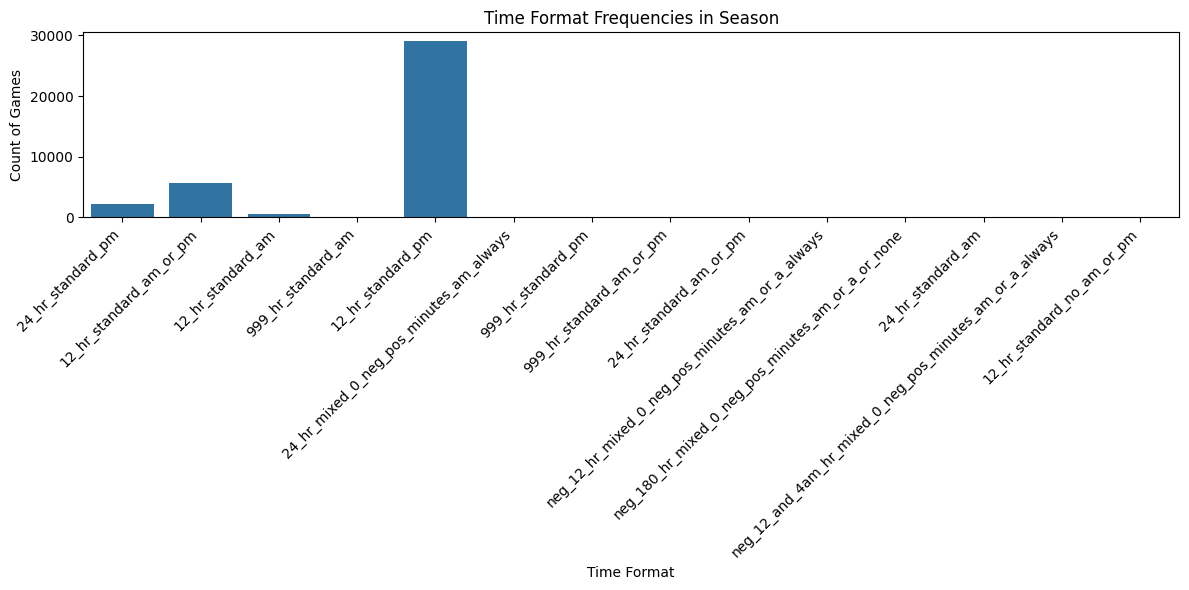

<Figure size 640x480 with 0 Axes>

In [113]:
# CHOSEN_SEASONS = ['1996-97', '1997-98', '1998-99', '1999-00']
CHOSEN_SEASONS = os.listdir('../pbp_data/nba/') 

plot_time_patterns(get_total_season_time_patterns(CHOSEN_SEASONS, PATTERNS))

## Converting the patterns into a standard format

The vast majority of the patterns are from 4 main categories:
- **12-hour standard PM**: This is the most common format, where the time is represented in 12-hour format with PM only.
- **12-hour standard AM or PM**: This format is like the 12-hour standard PM, but it can also include AM if the game passed over noon or midnight.
- **24-hour standard**: This format is represented in 24-hour format, where the time is represented in 0-23 hours.
- **12-hour standard AM**: This format is for games that begin and end entirely in the AM, such as 9:00 AM to 11:59 AM.

Each of these are easily converted into a standard time format, thankfully.

### Helper functions

In [ ]:
def fix_initial_am_rows(game_df: pd.DataFrame) -> pd.DataFrame:
    """
    There are many games where the first 1 or 2 rows may have WCTIMESTRING values that are 4:00 AM or some other
    random time that is clearly wrong. This function will make those rows match the time of the last row in
    the beginning sequence that has 12:00 in the PCTIMESTRING column, most often the jump ball row.
    """
    # Find the last row of which PCTIMESTRING is 12:00 and PERIOD is 1.
    first_meaningful_row_index = game_df[(game_df['PCTIMESTRING'] == '12:00') & (game_df['PERIOD'] == 1)].index.max()

    # Get the WCTIMESTRING value from that row.
    if pd.isna(first_meaningful_row_index):
        # If there is no such row, return the original DataFrame.
        return game_df
    correct_time = game_df.at[first_meaningful_row_index, 'WCTIMESTRING']

    # Replace all preceding rows' WCTIMESTRING values with this correct time.
    game_df.loc[:first_meaningful_row_index - 1, 'WCTIMESTRING'] = correct_time

    return game_df

def fix_last_rows(game_df: pd.DataFrame) -> pd.DataFrame:
    """
    Fix the last rows of the game DataFrame where the WCTIMESTRING may be illogical, but
    the final play of the period was logical.
    """
    # Find the last row of which PCTIMESTRING is 0:00 and PERIOD is 4.
    zero_rows = game_df[(game_df['PCTIMESTRING'] == '0:00') & (game_df['PERIOD'] == 4)]
    if len(zero_rows) < 2:
        # If there are fewer than 2, nothing to fix
        return game_df

    # Use the second to last as the last meaningful row
    last_meaningful_row_index = zero_rows.index[-2]
    correct_time = game_df.at[last_meaningful_row_index, 'WCTIMESTRING']

    game_df.loc[last_meaningful_row_index + 1:, 'WCTIMESTRING'] = correct_time

    return game_df

def convert_12_hr_pm_to_24_hr(game_df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a sequence of 12-hour PM times to 24-hour format.
    """
    converted_times = []
    turnover_index = None

    # Find the turnover index (where the hour goes from 11 to 12)
    hours = []
    for time in game_df['WCTIMESTRING']:
        match = re.match(TFC['12_hr_standard_pm'], time)
        if not match:
            raise ValueError(f"Time string '{time}' does not match the expected 12-hour PM format.")
        hour, minute = map(int, match.groups())
        hours.append(hour)
    for i in range(1, len(hours)):
        if hours[i - 1] == 11 and hours[i] == 12:
            turnover_index = i
            break

    # Everything before the index adds 12 hours, everything after subtracts 12 hours.
    for i, time in enumerate(game_df['WCTIMESTRING']):
        match = re.match(TFC['12_hr_standard_pm'], time)
        hour, minute = map(int, match.groups())
        if turnover_index is not None:
            if i < turnover_index:
                # Before turnover: add 12 to hour except for 12 PM
                h = hour if hour == 12 else hour + 12
                converted_times.append(f"{h}:{minute:02}")
            else:
                # After turnover: subtract 12 from hour except for 12 PM
                h = 0 if hour == 12 else hour - 12
                converted_times.append(f"{h}:{minute:02}")
        else:
            # If no turnover, treat all as PM: add 12 except for 12 PM
            h = hour if hour == 12 else hour + 12
            converted_times.append(f"{h}:{minute:02}")
    return game_df.assign(WCTIMESTRING=converted_times)

def convert_24_hr_am_only_to_24_hr(time_str: str) -> str:
    """
    Convert a 24-hour time string with AM only to a 24-hour format
    """
    match = re.match(TFC['24_hr_standard_am'], time_str)
    if match:
        hour, minute = map(int, match.groups())
        return f"{hour}:{minute:02}" # Ignoring the AM entirely.
    else:
        raise ValueError(f"Time string '{time_str}' does not match the expected 24-hour AM format.")

def convert_24_hr_no_am_or_pm_to_24_hr(time_str: str) -> str:
    """
    Convert a 24-hour time string without AM or PM to a 24-hour format
    """
    match = re.match(TFC['24_hr_standard_no_am_or_pm'], time_str)
    if match:
        hour, minute = map(int, match.groups())
        return f"{hour}:{minute:02}"
    else:
        raise ValueError(f"Time string '{time_str}' does not match the expected 24-hour no AM/PM format.")

def convert_999_hr_pm_to_999_hr(time_str: str) -> str:
    """
    Convert a 999-hour time string with PM to a 24-hour format
    """
    match = re.match(TFC['999_hr_standard_pm'], time_str)
    if match:
        hour, minute = map(int, match.groups())
        return f"{hour}:{minute:02}" # Ignoring the PM entirely.
    else:
        raise ValueError(f"Time string '{time_str}' does not match the expected 999-hour PM format.")
    
def convert_999_hr_am_to_999_hr(time_str: str) -> str:
    """
    Convert a 999-hour time string with AM to a 24-hour format
    """
    match = re.match(TFC['999_hr_standard_am'], time_str)
    if match:
        hour, minute = map(int, match.groups())
        return f"{hour}:{minute:02}" # Ignoring the AM entirely since the game appears to ignore AM/PM despite having it.
    else:
        raise ValueError(f"Time string '{time_str}' does not match the expected 999-hour AM format.")
    
def convert_999_hr_am_or_pm_to_999_hr(game_df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a sequence of 999-hour AM/PM times to 24-hour format.
    """
    cleaner_df = fix_initial_am_rows(game_df)
    cleaner_df = fix_last_rows(cleaner_df)
    converted_times = []
    for time in cleaner_df['WCTIMESTRING']:
        match = re.match(TFC['999_hr_standard_am_or_pm'], time)
        if match:
            hour, minute = map(int, match.groups())
            converted_times.append(f"{hour}:{minute:02}")  # Ignoring the AM/PM entirely.
        else:
            raise ValueError(f"Time string '{time}' does not match the expected 999-hour AM/PM format.")
    return cleaner_df.assign(WCTIMESTRING=converted_times)
    
def convert_999_hr_standard_no_am_or_pm_to_999_hr(time_str: str) -> str:
    """
    Convert a 999-hour time string without AM or PM to a 24-hour format
    """
    match = re.match(TFC['999_hr_standard_no_am_or_pm'], time_str)
    if match:
        hour, minute = map(int, match.groups())
        return f"{hour}:{minute:02}"
    else:
        raise ValueError(f"Time string '{time_str}' does not match the expected 999-hour no AM/PM format.")

def convert_12_hr_no_am_or_pm_to_24_hr(time_str: str) -> str:
    """
    Convert a 12-hour time string without AM or PM to a 24-hour format
    """
    match = re.match(TFC['12_hr_standard_no_am_or_pm'], time_str)
    if match:
        hour, minute = map(int, match.groups())
        if hour == 12:  # Midnight case
            hour = 0
        return f"{hour}:{minute:02}"
    else:
        raise ValueError(f"Time string '{time_str}' does not match the expected 12-hour no AM/PM format.")
    
def convert_12_hr_am_only_to_24_hr(game_df: pd.DataFrame) -> pd.DataFrame:
    cleaner_df = fix_initial_am_rows(game_df)
    cleaner_df = fix_last_rows(cleaner_df)

    converted_times = []
    turnover_index = None

    # Find the turnover index (where the hour goes from 11 to 12)
    hours = []
    for time in cleaner_df['WCTIMESTRING']:
        match = re.match(TFC['12_hr_standard_am'], time)
        if not match:
            raise ValueError(f"Time string '{time}' does not match the expected 12-hour PM format.")
        hour, minute = map(int, match.groups())
        hours.append(hour)
    for i in range(1, len(hours)):
        if hours[i - 1] == 11 and hours[i] == 12:
            turnover_index = i
            break

    # Everything before the index stays the same, everything after 12:00 adds 12 hours.
    for i, time in enumerate(cleaner_df['WCTIMESTRING']):
        match = re.match(TFC['12_hr_standard_am'], time)
        hour, minute = map(int, match.groups())
        if turnover_index is not None:
            if i < turnover_index:
                # Before turnover: keep the hour as is
                converted_times.append(f"{hour}:{minute:02}")
            else:
                # After turnover: add 12 to hour except for 12 AM
                h = hour + 12 if hour != 12 else hour
                converted_times.append(f"{h}:{minute:02}")
        else:
            # If no turnover, treat all as AM: convert only 12 AM to 0, keep others
            h = 0 if hour == 12 else hour
            converted_times.append(f"{h}:{minute:02}")

    return cleaner_df.assign(WCTIMESTRING=converted_times)

def convert_12_hr_am_or_pm_to_24_hr(game_df: pd.DataFrame) -> pd.DataFrame:
    cleaner_df = fix_initial_am_rows(game_df)
    cleaner_df = fix_last_rows(cleaner_df)
    if cleaner_df['WCTIMESTRING'].str.match(TFC['12_hr_standard_pm']).all():
        return convert_12_hr_pm_to_24_hr(cleaner_df)
    else:
        converted_times = []
        for time in cleaner_df['WCTIMESTRING']:
            match = re.match(TFC['12_hr_standard_am_or_pm'], time)
            if match:
                hour, minute = map(int, match.groups())
                if 'PM' in time and hour != 12:
                    hour += 12
                elif 'AM' in time and hour == 12:
                    hour = 0
                converted_times.append(f"{hour}:{minute:02}")
            else:
                raise ValueError(f"Time string '{time}' does not match the expected 12-hour AM/PM format.")
            
    return cleaner_df.assign(WCTIMESTRING=converted_times)

def convert_24_hr_pm_to_24_hr(game_df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a 24-hour time dataframe with PM times to 24-hour format.
    """
    converted_times = []
    for time in game_df['WCTIMESTRING']:
        match = re.match(TFC['24_hr_standard_pm'], time)
        if match:
            hour, minute = map(int, match.groups())
            converted_times.append(f"{hour}:{minute:02}")  # Ignoring the PM entirely.
        else:
            raise ValueError(f"Time string '{time}' does not match the expected 24-hour PM format.")
    return game_df.assign(WCTIMESTRING=converted_times)
   
def convert_24_hr_am_or_pm_to_24_hr(game_df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a 24-hour time ddataframe with AM or PM to a 24-hour format
    """
    cleaner_df = fix_initial_am_rows(game_df)
    cleaner_df = fix_last_rows(cleaner_df)
    if cleaner_df['WCTIMESTRING'].str.match(TFC['24_hr_standard_pm']).all():
        return convert_24_hr_pm_to_24_hr(cleaner_df)
    else:
        converted_times = []
        for time in cleaner_df['WCTIMESTRING']:
            match = re.match(TFC['24_hr_standard_am_or_pm'], time)
            if match:
                hour, minute = map(int, match.groups())
                if 'PM' in time and hour != 12:
                    hour += 12
                elif 'AM' in time and hour == 12:
                    hour = 0
                converted_times.append(f"{hour}:{minute:02}")
            else:
                raise ValueError(f"Time string '{time}' does not match the expected 24-hour AM/PM format.")
    return cleaner_df.assign(WCTIMESTRING=converted_times)
    

### Creating a converted copy of the dataset.

In [ ]:
import os
import re

def convert_time_formats_in_season(season: str, patterns: dict) -> None:
    """
    Convert all time formats in the specified season's combined CSV file to a standard 24-hour format.
    """
    season_path = f'../pbp_data/nba/{season}/combined_{season}.csv'
    if not os.path.exists(season_path):
        print(f"Season file {season_path} does not exist.")
        return
    
    season_df = pd.read_csv(season_path)

    # Iterate through game IDs in the season DataFrame
    for game_id, group in season_df.groupby('GAME_ID'):

        # Get the first matching time format for the game
        time_format = get_first_matching_format(group, 'WCTIMESTRING', patterns)

        if time_format is None:
            print(f"Game ID {game_id} in season {season} has no matching time format")
            continue
        
        found = False

        if time_format == '12_hr_standard_pm':
            converted_df = convert_12_hr_pm_to_24_hr(group)
            season_df.loc[season_df['GAME_ID'] == game_id, 'WCTIMESTRING'] = converted_df['WCTIMESTRING'].values
            found = True
        elif time_format == '12_hr_standard_am':
            converted_df = convert_12_hr_am_only_to_24_hr(group)
            season_df.loc[season_df['GAME_ID'] == game_id, 'WCTIMESTRING'] = converted_df['WCTIMESTRING'].values
            found = True
        elif time_format == '12_hr_standard_am_or_pm':
            converted_df = convert_12_hr_am_or_pm_to_24_hr(group)
            season_df.loc[season_df['GAME_ID'] == game_id, 'WCTIMESTRING'] = converted_df['WCTIMESTRING'].values
            found = True
        if time_format == '24_hr_standard_pm':
            converted_df = convert_24_hr_pm_to_24_hr(group)
            season_df.loc[season_df['GAME_ID'] == game_id, 'WCTIMESTRING'] = converted_df['WCTIMESTRING'].values
            found = True
        elif time_format == '24_hr_standard_am':
            converted = group['WCTIMESTRING'].apply(convert_24_hr_am_only_to_24_hr).values
            season_df.loc[season_df['GAME_ID'] == game_id, 'WCTIMESTRING'] = converted
            found = True
        elif time_format == '24_hr_standard_am_or_pm':
            converted_df = convert_24_hr_am_or_pm_to_24_hr(group)
            season_df.loc[season_df['GAME_ID'] == game_id, 'WCTIMESTRING'] = converted_df['WCTIMESTRING'].values
            found = True
        elif time_format == '24_hr_standard_no_am_or_pm':
            converted = group['WCTIMESTRING'].apply(convert_24_hr_no_am_or_pm_to_24_hr).values
            season_df.loc[season_df['GAME_ID'] == game_id, 'WCTIMESTRING'] = converted
            found = True
        if time_format == '999_hr_standard_pm':
            converted = group['WCTIMESTRING'].apply(convert_999_hr_pm_to_999_hr).values
            season_df.loc[season_df['GAME_ID'] == game_id, 'WCTIMESTRING'] = converted
            found = True
        elif time_format == '999_hr_standard_am':
            converted = group['WCTIMESTRING'].apply(convert_999_hr_am_to_999_hr).values
            season_df.loc[season_df['GAME_ID'] == game_id, 'WCTIMESTRING'] = converted
            found = True
        elif time_format == '999_hr_standard_am_or_pm':
            converted = convert_999_hr_am_or_pm_to_999_hr(group)
            season_df.loc[season_df['GAME_ID'] == game_id, 'WCTIMESTRING'] = converted['WCTIMESTRING'].values
            found = True
        elif time_format == '999_hr_standard_no_am_or_pm':
            converted = group['WCTIMESTRING'].apply(convert_999_hr_standard_no_am_or_pm_to_999_hr).values
            season_df.loc[season_df['GAME_ID'] == game_id, 'WCTIMESTRING'] = converted
            found = True
        elif time_format == '999_hr_standard_no_am_or_pm':
            converted = group['WCTIMESTRING'].apply(convert_24_hr_no_am_or_pm_to_24_hr).values
            season_df.loc[season_df['GAME_ID'] == game_id, 'WCTIMESTRING'] = converted
            found = True
        if not found:
            # Erase that game from the DataFrame if the time format is unhandled
            print(f"Unhandled time format: {time_format} for game ID {game_id} in season {season}")
            season_df = season_df[season_df['GAME_ID'] != game_id]

    # Save the modified DataFrame back to the CSV file
    new_csv_path = f'../pbp_data/nba/{season}/converted_combined_{season}.csv'
    if os.path.exists(new_csv_path):
        print(f"File {new_csv_path} already exists. Overwriting it.")
    season_df.to_csv(new_csv_path, index=False)

# CHOSEN_SEASONS = os.listdir('../pbp_data/nba/')  # List of seasons to check, e.g. ['1996-97', '1997-98', ...]
CHOSEN_SEASONS = ['1997-98']
PATTERNS = TFC.copy()

for season in CHOSEN_SEASONS:
    print(f"Converting time formats in season {season}...")
    convert_time_formats_in_season(season, PATTERNS)

print("Time formats conversion completed for all seasons.")

Converting time formats in season 1997-98...
Unhandled time format: neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_always for game ID 29700144 in season 1997-98
Unhandled time format: neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_or_none for game ID 29700804 in season 1997-98
File ../pbp_data/nba/1997-98/converted_combined_1997-98.csv already exists. Overwriting it.
Time formats conversion completed for all seasons.


## Finding Bad Densities

In [41]:
import pandas as pd

def find_long_events_24_hour(pbp_game_df: pd.DataFrame, minutes_threshold: int = 20, event_num_diff: int = 1) -> pd.DataFrame:
    """
    Find long events in the play-by-play data of a game.
    
    A long event is an event where the time difference between it and the next event is greater than
    the specified threshold in minutes.

    This function assumes that the play-by-play data is sorted by time and that the time format is consistently
    in the 24-hour standard format without AM/PM, and that jumps may include the end of the quarter or halftime.

    Args:
        pbp_game_df (pd.DataFrame): DataFrame containing play-by-play data for a single game.
        minutes_threshold (int): The threshold in minutes to consider an event as long.
        event_num_diff (int): The number of consecutive long events to find. Defaults to 1.

    Returns:
        pd.DataFrame: DataFrame containing the long events found.
    """

    # Use two pointers to find ranges that exceed the time threshold
    long_events = []

    # Some games start with the "Start of 1st period" event but have a strange time for it that should be ignored.
    start_index = 0
    if "Jump Ball" not in str(pbp_game_df.iloc[1]['HOMEDESCRIPTION']) and "Start of 1st Period " in str(pbp_game_df.iloc[0]['NEUTRALDESCRIPTION']):
        start_index = 1
    elif "Jump Ball" in str(pbp_game_df.iloc[0]['HOMEDESCRIPTION']):
        start_index = 1
    elif "12:00" in str(pbp_game_df.iloc[1]['PCTIMESTRING']):
        start_index = 1

    for i in range(start_index, len(pbp_game_df) - event_num_diff):
        # Get the time strings
        start_event = pbp_game_df.iloc[i]
        end_event = pbp_game_df.iloc[i + event_num_diff]
        start_datetime = pd.to_datetime(start_event['WCTIMESTRING'], format='%H:%M')
        end_datetime = pd.to_datetime(end_event['WCTIMESTRING'], format='%H:%M')

        # Handle midnight rollover
        if end_datetime < start_datetime:
            end_datetime += pd.Timedelta(days=1)

        min_diff = (end_datetime - start_datetime)

        # Calculate the difference in minutes
        min_diff = (end_datetime - start_datetime)
        if min_diff > pd.Timedelta(minutes=minutes_threshold):
            # Setup tuple format
            long_event = {
                'GAME_ID': start_event['GAME_ID'],
                'EVENTNUM': start_event['EVENTNUM'],
                'START_TIME': start_event['WCTIMESTRING'],
                'END_TIME': end_event['WCTIMESTRING'],
                'MIN_DIFF': min_diff,
            }
            # Append to the list of long events
            long_events.append(long_event)

    return pd.DataFrame(long_events)

def find_long_events_999_hour(pbp_game_df: pd.DataFrame, minutes_threshold: int = 20, event_num_diff: int = 1) -> pd.DataFrame:
    """ 
    Find long events in the play-by-play data of a game in 999-hour format.
    """
    def parse_variable_hour_time(timestr):
        # Split on ':'
        hour, minute = timestr.split(':')
        return pd.Timedelta(hours=int(hour), minutes=int(minute))

    long_events = []

    # Some games start with the "Start of 1st period" event but have a strange time for it that should be ignored.
    start_index = 0
    if "Jump Ball" not in str(pbp_game_df.iloc[1]['HOMEDESCRIPTION']) and "Start of 1st Period " in str(pbp_game_df.iloc[0]['NEUTRALDESCRIPTION']):
        start_index = 1
    elif "Jump Ball" in str(pbp_game_df.iloc[0]['HOMEDESCRIPTION']):
        start_index = 1
    elif "12:00" in str(pbp_game_df.iloc[1]['PCTIMESTRING']):
        start_index = 1

    for i in range(start_index, len(pbp_game_df) - event_num_diff):
        # Get the time strings
        start_event = pbp_game_df.iloc[i]
        end_event = pbp_game_df.iloc[i + event_num_diff]

        start_datetime = parse_variable_hour_time(start_event['WCTIMESTRING'])
        end_datetime = parse_variable_hour_time(end_event['WCTIMESTRING'])

        # Calculate the difference in minutes
        min_diff = (end_datetime - start_datetime)
        if min_diff > pd.Timedelta(minutes=minutes_threshold):
            # Setup tuple format
            long_event = {
                'GAME_ID': start_event['GAME_ID'],
                'EVENTNUM': start_event['EVENTNUM'],
                'START_TIME': start_event['WCTIMESTRING'],
                'END_TIME': end_event['WCTIMESTRING'],
                'MIN_DIFF': min_diff,
            }
            # Append to the list of long events
            long_events.append(long_event)

    return pd.DataFrame(long_events)

def find_many_events_in_short_time_999_hour(pbp_game_df: pd.DataFrame, minutes_threshold: int = 0, event_num_diff: int = 10) -> pd.DataFrame:
    """
    Find unusually large number of events in a short time period in the play-by-play data of a game in 999-hour format.
    """
    def parse_variable_hour_time(timestr):
        # Split on ':'
        hour, minute = timestr.split(':')
        return pd.Timedelta(hours=int(hour), minutes=int(minute))
    
    many_events = []

    # Some games start with the "Start of 1st period" event but have a strange time for it that should be ignored.
    start_index = 0
    if "Jump Ball" not in str(pbp_game_df.iloc[1]['HOMEDESCRIPTION']) and "Start of 1st Period " in str(pbp_game_df.iloc[0]['NEUTRALDESCRIPTION']):
        start_index = 1
    elif "Jump Ball" in str(pbp_game_df.iloc[0]['HOMEDESCRIPTION']):
        start_index = 1
    elif "12:00" in str(pbp_game_df.iloc[1]['PCTIMESTRING']):
        start_index = 1

    for i in range(start_index, len(pbp_game_df) - event_num_diff + 1):
        start_event = pbp_game_df.iloc[i]
        end_event = pbp_game_df.iloc[i + event_num_diff - 1]
        
        start_datetime = parse_variable_hour_time(start_event['WCTIMESTRING'])
        end_datetime = parse_variable_hour_time(end_event['WCTIMESTRING'])

        # Calculate the difference in minutes
        min_diff = (end_datetime - start_datetime)

        # Debugging
        # print(f"i: {i}, Start time: {start_event['WCTIMESTRING']}, End time: {end_event['WCTIMESTRING']}, Min diff: {min_diff}")

        # If the difference is less than or equal to the threshold, we consider it a short time period
        # and we add the triggering event to the list. (Might even be negative if the times aren't in order.)
        if min_diff <= pd.Timedelta(minutes=minutes_threshold):
            many_event = {
                'GAME_ID': start_event['GAME_ID'],
                'EVENTNUM_START': start_event['EVENTNUM'],
                'EVENTNUM_END': end_event['EVENTNUM'],
                'EVENT_COUNT': event_num_diff,
                'START_TIME': start_event['WCTIMESTRING'],
                'END_TIME': end_event['WCTIMESTRING'],
            }
            many_events.append(many_event)
    return pd.DataFrame(many_events)

def find_many_events_in_short_time_24_hour(pbp_game_df: pd.DataFrame, minutes_threshold: int = 0, event_num_diff: int = 10) -> pd.DataFrame:
    """
    Find unusually large number of events in a short time period in the play-by-play data of a game.

    This function assumes that the play-by-play data is sorted by time and that the time format is consistently
    in the 24-hour format without AM/PM.

    Args:
        pbp_game_df (pd.DataFrame): DataFrame containing play-by-play data for a single game.
        minutes_threshold (int): How many minutes difference to consider a short time period. 0 means no change in minutes.
        event_num_diff (int): The number of consecutive events to find. Defaults to 10.

    Returns:
        pd.DataFrame: DataFrame containing events in which event_num_diff events occur within the specified minutes threshold.
    """
    # if len(pbp_game_df) < event_num_diff:
    #     return pd.DataFrame()

    many_events = []

    # Some games start with the "Start of 1st period" event but have a strange time for it that should be ignored.
    start_index = 0
    if "Jump Ball" not in str(pbp_game_df.iloc[1]['HOMEDESCRIPTION']) and "Start of 1st Period " in str(pbp_game_df.iloc[0]['NEUTRALDESCRIPTION']):
        start_index = 1
    elif "Jump Ball" in str(pbp_game_df.iloc[0]['HOMEDESCRIPTION']):
        start_index = 1
    elif "12:00" in str(pbp_game_df.iloc[1]['PCTIMESTRING']):
        start_index = 1

    for i in range(start_index, len(pbp_game_df) - event_num_diff + 1):
        start_event = pbp_game_df.iloc[i]
        end_event = pbp_game_df.iloc[i + event_num_diff - 1]
        start_datetime = pd.to_datetime(start_event['WCTIMESTRING'], format='%H:%M')
        end_datetime = pd.to_datetime(end_event['WCTIMESTRING'], format='%H:%M')

        # Handle midnight rollover
        if end_datetime < start_datetime:
            end_datetime += pd.Timedelta(days=1)

        # Calculate the difference in minutes
        min_diff = (end_datetime - start_datetime)

        # If the difference is less than or equal to the threshold, we consider it a short time period
        # and we add the triggering event to the list.
        if min_diff <= pd.Timedelta(minutes=minutes_threshold):
            many_event = {
                'GAME_ID': start_event['GAME_ID'],
                'EVENTNUM_START': start_event['EVENTNUM'],
                'EVENTNUM_END': end_event['EVENTNUM'],
                'EVENT_COUNT': event_num_diff,
                'START_TIME': start_event['WCTIMESTRING'],
                'END_TIME': end_event['WCTIMESTRING'],
                'HOMEDESCRIPTION': start_event['HOMEDESCRIPTION'],
            }
            many_events.append(many_event)
    return pd.DataFrame(many_events)

In [70]:
import pandas as pd
import os

# Counting how many bad densities are in a given season.

def sort_middle_rows_24_hr(game_df: pd.DataFrame) -> pd.DataFrame:
    """
    Sorts the middle rows of a game DataFrame by WCTIMESTRING, leaving the first and last rows unchanged.

    Takes into account the game may pass midnight, and sorts the before and after sections separately.
    """
    if len(game_df) <= 2:
        # If there are only 1 or 2 rows, no sorting is needed.
        return game_df
    
    # Find the turnover index (where the hour goes from 23 to 0)
    turnover_index = None
    hours = []
    for time in game_df['WCTIMESTRING']:
        match = re.match(TFC['24_hr_standard_no_am_or_pm'], time)
        if not match:
            raise ValueError(f"Time string '{time}' does not match the expected 12-hour PM format.")
        hour, minute = map(int, match.groups())
        hours.append(hour)
    for i in range(1, len(hours)):
        if hours[i - 1] == 23 and hours[i] == 0:
            turnover_index = i
            break
    
    if turnover_index is None:
        # If no turnover, sort the entire DataFrame by WCTIMESTRING
        sorted_df = game_df.sort_values(by='WCTIMESTRING', ascending=True).reset_index(drop=True)
        return sorted_df
    elif turnover_index:
        # Sort the first part before the turnover
        first_part = game_df.iloc[:turnover_index].sort_values(by='WCTIMESTRING', ascending=True).reset_index(drop=True)
        # Sort the second part after the turnover
        second_part = game_df.iloc[turnover_index:].sort_values(by='WCTIMESTRING', ascending=True).reset_index(drop=True)
        # Concatenate the two parts back together
        sorted_game_df = pd.concat([first_part, second_part], ignore_index=True)
        return sorted_game_df             

def count_long_events_by_season(seasons: list[str], league: str, minutes_threshold: int = 40, event_num_diff: int = 1) -> pd.DataFrame:
    """
    Count the number of long events in the play-by-play data of each season.
    """
    long_event_counts = {season: [] for season in seasons}
    for season in seasons:
        season_path = f'../pbp_data/{league}/{season}/converted_combined_{season}.csv'
        if not os.path.exists(season_path):
            print(f"Season file {season_path} does not exist.")
            continue

        season_df = pd.read_csv(season_path)
        for game_id, group in season_df.groupby('GAME_ID'):
            time_format = get_first_matching_format(group, 'WCTIMESTRING', TFC)
            if time_format is None:
                print(f"Game ID {game_id} in season {season} has no matching time format")
                print("Unique WCTIMESTRING values:", group['WCTIMESTRING'].unique())
                continue
            elif time_format == '12_hr_standard_no_am_or_pm' or time_format == '24_hr_standard_no_am_or_pm':
                long_events = find_long_events_24_hour(group, minutes_threshold, event_num_diff)
                sorted_game_df = group.sort_values(by='EVENTNUM', ascending=True).reset_index(drop=True)
                long_events_sorted_nums = find_long_events_24_hour(sorted_game_df, minutes_threshold, event_num_diff)
                sorted_game_df_times = sort_middle_rows_24_hr(group)
                long_events_sorted_times = find_long_events_24_hour(sorted_game_df_times, minutes_threshold, event_num_diff)
                if not long_events_sorted_nums.empty and not long_events.empty and not long_events_sorted_times.empty:
                    long_event_counts[season].append(game_id)
            elif time_format == '999_hr_standard_no_am_or_pm':
                long_events = find_long_events_999_hour(group, minutes_threshold, event_num_diff)
                sorted_game_df = group.sort_values(by='EVENTNUM', ascending=True).reset_index(drop=True)
                sorted_game_df_times = group.sort_values(by='WCTIMESTRING', ascending=True).reset_index(drop=True)
                long_events_sorted_nums = find_long_events_999_hour(sorted_game_df, minutes_threshold, event_num_diff)
                long_events_sorted_times = find_long_events_999_hour(sorted_game_df_times, minutes_threshold, event_num_diff)
                if not long_events_sorted_nums.empty and not long_events.empty and not long_events_sorted_times.empty:
                    long_event_counts[season].append(game_id)
            else:
                print(f"Unhandled long-event time format: {time_format} for game ID {game_id} in season {season}")
                print("Unique WCTIMESTRING values:", group['WCTIMESTRING'].unique())
        
    final_dataframe = []
    for season, game_ids in long_event_counts.items():
        for game_id in game_ids:
            final_dataframe.append((season, game_id))
    return pd.DataFrame(final_dataframe, columns=['Season', 'GAME_ID'])

def count_many_events_by_season(seasons: list[str], league: str, minutes_threshold: int = 0, event_num_diff: int = 15) -> pd.DataFrame:
    """
    Count the number of many events in the play-by-play data of each season.
    """
    many_event_counts = {season: [] for season in seasons}
    for season in seasons:
        season_path = f'../pbp_data/{league}/{season}/converted_combined_{season}.csv'
        if not os.path.exists(season_path):
            print(f"Season file {season_path} does not exist.")
            continue

        season_df = pd.read_csv(season_path)
        for game_id, group in season_df.groupby('GAME_ID'):

            time_format = get_first_matching_format(group, 'WCTIMESTRING', TFC)
            if time_format is None:
                print(f"Game ID {game_id} in season {season} has no matching time format")
                print("Unique WCTIMESTRING values:", group['WCTIMESTRING'].unique())
                continue

            elif time_format == '12_hr_standard_no_am_or_pm' or time_format == '24_hr_standard_no_am_or_pm':
                many_events = find_many_events_in_short_time_24_hour(group, minutes_threshold, event_num_diff)
                sorted_game_df = group.sort_values(by='EVENTNUM', ascending=True).reset_index(drop=True)
                many_events_sorted = find_many_events_in_short_time_24_hour(sorted_game_df, minutes_threshold, event_num_diff)
                if not many_events_sorted.empty and not many_events.empty:
                    many_event_counts[season].append(game_id)
            elif time_format == '999_hr_standard_no_am_or_pm':
                many_events = find_many_events_in_short_time_999_hour(group, minutes_threshold, event_num_diff)
                sorted_game_df = group.sort_values(by='EVENTNUM', ascending=True).reset_index(drop=True)
                many_events_sorted = find_many_events_in_short_time_999_hour(sorted_game_df, minutes_threshold, event_num_diff)
                if not many_events_sorted.empty and not many_events.empty:
                    many_event_counts[season].append(game_id)
            else:
                print(f"Unhandled many-event time format: {time_format} for game ID {game_id} in season {season}")
                print("Unique WCTIMESTRING values:", group['WCTIMESTRING'].unique())

    # Returns dataframe with two columns: 'Season' and 'GAME_ID'. 
    # For each key season, make the key and one of the values in the list a row.
    final_dataframe = []
    for season, game_ids in many_event_counts.items():
        for game_id in game_ids:
            final_dataframe.append((season, game_id))
    return pd.DataFrame(final_dataframe, columns=['Season', 'GAME_ID'])

def count_games_by_season(seasons: list[str], league: str) -> pd.DataFrame:
    """
    Count the number of games in each season.
    """
    game_counts = {season: 0 for season in seasons}
    for season in seasons:
        season_path = f'../pbp_data/{league}/{season}/converted_combined_{season}.csv'
        if not os.path.exists(season_path):
            print(f"Season file {season_path} does not exist.")
            continue

        season_df = pd.read_csv(season_path)
        game_counts[season] = season_df['GAME_ID'].nunique()
    
    return pd.DataFrame(list(game_counts.items()), columns=['Season', 'Game Count'])

def get_density_percentage(CHOSEN_SEASONS, game_count, league, minutes_threshold, event_num_diff) -> pd.DataFrame:
    many_events_by_season = count_many_events_by_season(CHOSEN_SEASONS, 'nba', minutes_threshold=minutes_threshold, event_num_diff=event_num_diff)
    percent_of_high_densities = (many_events_by_season['GAME_ID'].nunique() / game_count['Game Count'].sum()) * 100
    print(f"Percent of High Densities at {event_num_diff}:")
    print(f"{percent_of_high_densities:.2f}%")
    print(f"High Densities at {event_num_diff}:")
    return many_events_by_season
    

In [27]:
CHOSEN_SEASONS = ['1996-97']
long_events_by_season = count_long_events_by_season(CHOSEN_SEASONS, 'nba', minutes_threshold=40, event_num_diff=2)
print("Long Events by Season:")
print(long_events_by_season.to_string(index=False, header=True))

KeyboardInterrupt: 

In [31]:
CHOSEN_SEASONS = ['1996-97']
game_count = count_games_by_season(CHOSEN_SEASONS, 'nba')

many_events_by_season = get_density_percentage(CHOSEN_SEASONS, game_count, 'nba', minutes_threshold=0, event_num_diff=15)
print(many_events_by_season.to_string(index=False, header=True))
many_events_by_season = get_density_percentage(CHOSEN_SEASONS, game_count, 'nba', minutes_threshold=0, event_num_diff=20)
print(many_events_by_season.to_string(index=False, header=True))
many_events_by_season = get_density_percentage(CHOSEN_SEASONS, game_count, 'nba', minutes_threshold=0, event_num_diff=25)
print(many_events_by_season.to_string(index=False, header=True))
many_events_by_season = get_density_percentage(CHOSEN_SEASONS, game_count, 'nba', minutes_threshold=0, event_num_diff=30)
print(many_events_by_season.to_string(index=False, header=True))

Percent of High Densities at 15:
3.49%
High Densities at 15:
 Season  GAME_ID
1996-97 29600002
1996-97 29600055
1996-97 29600062
1996-97 29600065
1996-97 29600176
1996-97 29600217
1996-97 29600226
1996-97 29600233
1996-97 29600248
1996-97 29600337
1996-97 29600378
1996-97 29600404
1996-97 29600441
1996-97 29600466
1996-97 29600499
1996-97 29600503
1996-97 29600507
1996-97 29600514
1996-97 29600527
1996-97 29600530
1996-97 29600540
1996-97 29600552
1996-97 29600585
1996-97 29600603
1996-97 29600624
1996-97 29600657
1996-97 29600679
1996-97 29600707
1996-97 29600804
1996-97 29600816
1996-97 29600831
1996-97 29600879
1996-97 29600958
1996-97 29601046
1996-97 29601132
1996-97 29601141
1996-97 29601152
1996-97 29601160
1996-97 29601187
1996-97 49600002
1996-97 49600016
1996-97 49600022
1996-97 49600055
1996-97 49600057
 Season  GAME_ID
1996-97 29600002
1996-97 29600055
1996-97 29600062
1996-97 29600065
1996-97 29600176
1996-97 29600217
1996-97 29600226
1996-97 29600233
1996-97 29600248
1996

In [32]:
CHOSEN_SEASONS = ['1997-98']
game_count = count_games_by_season(CHOSEN_SEASONS, 'nba')

many_events_by_season = get_density_percentage(CHOSEN_SEASONS, game_count, 'nba', minutes_threshold=0, event_num_diff=15)
print(many_events_by_season.to_string(index=False, header=True))
many_events_by_season = get_density_percentage(CHOSEN_SEASONS, game_count, 'nba', minutes_threshold=0, event_num_diff=20)
print(many_events_by_season.to_string(index=False, header=True))
many_events_by_season = get_density_percentage(CHOSEN_SEASONS, game_count, 'nba', minutes_threshold=0, event_num_diff=25)
print(many_events_by_season.to_string(index=False, header=True))
many_events_by_season = get_density_percentage(CHOSEN_SEASONS, game_count, 'nba', minutes_threshold=0, event_num_diff=30)
print(many_events_by_season.to_string(index=False, header=True))

Percent of High Densities at 15:
3.97%
High Densities at 15:
 Season  GAME_ID
1997-98 29700002
1997-98 29700020
1997-98 29700026
1997-98 29700076
1997-98 29700152
1997-98 29700154
1997-98 29700206
1997-98 29700218
1997-98 29700256
1997-98 29700271
1997-98 29700281
1997-98 29700298
1997-98 29700325
1997-98 29700358
1997-98 29700375
1997-98 29700471
1997-98 29700523
1997-98 29700530
1997-98 29700570
1997-98 29700593
1997-98 29700608
1997-98 29700619
1997-98 29700630
1997-98 29700715
1997-98 29700729
1997-98 29700743
1997-98 29700744
1997-98 29700791
1997-98 29700803
1997-98 29700814
1997-98 29700825
1997-98 29700851
1997-98 29700852
1997-98 29700862
1997-98 29700875
1997-98 29700897
1997-98 29700903
1997-98 29700923
1997-98 29700936
1997-98 29700946
1997-98 29700980
1997-98 29701023
1997-98 29701032
1997-98 29701045
1997-98 29701075
1997-98 29701079
1997-98 29701084
1997-98 29701120
1997-98 29701158
1997-98 49700045
 Season  GAME_ID
1997-98 29700002
1997-98 29700020
1997-98 29700026
1997

In [74]:
def show_long_events(df: pd.DataFrame, game_id: int, minutes_threshold: int = 40, 
                     event_num_diff: int = 1) -> pd.DataFrame:
    game_df = df[df['GAME_ID'] == game_id]

    time_format = get_first_matching_format(game_df, 'WCTIMESTRING', TFC)

    long_events = pd.DataFrame()
    long_events_sorted = pd.DataFrame()
    if time_format == '12_hr_standard_no_am_or_pm' or time_format == '24_hr_standard_no_am_or_pm':
        long_events = find_long_events_24_hour(game_df, minutes_threshold, event_num_diff)
        sorted_game_df = game_df.sort_values(by='EVENTNUM', ascending=True).reset_index(drop=True)
        long_events_sorted = find_long_events_24_hour(sorted_game_df, minutes_threshold, event_num_diff)
        sorted_game_df_times = sort_middle_rows_24_hr(game_df)
        long_events_sorted_times = find_long_events_24_hour(sorted_game_df_times, minutes_threshold, event_num_diff)
    elif time_format == '999_hr_standard_no_am_or_pm':
        long_events = find_long_events_999_hour(game_df, minutes_threshold, event_num_diff)
        sorted_game_df = game_df.sort_values(by='EVENTNUM', ascending=True).reset_index(drop=True)
        long_events_sorted = find_long_events_999_hour(sorted_game_df, minutes_threshold, event_num_diff)
        sorted_game_df_times = game_df.sort_values(by='WCTIMESTRING', ascending=True).reset_index(drop=True)
        long_events_sorted_times = find_long_events_999_hour(sorted_game_df_times, minutes_threshold, event_num_diff)
    
    if not long_events_sorted.empty and not long_events.empty and not long_events_sorted_times.empty:
        print("Long Events in Game:")
        print(long_events.to_string(index=False, header=True))
        print("Sorted Long Events in Game:")
        print(long_events_sorted.to_string(index=False, header=True))
        print("Sorted by Time Long Events in Game:")
        print(long_events_sorted_times.to_string(index=False, header=True))
    else:
        print(f"Game {game_id} is clean.")

def show_many_events(df: pd.DataFrame, game_id: int, minutes_threshold: int = 0, event_num_diff: int = 15) -> pd.DataFrame:
    game_df = df[df['GAME_ID'] == game_id]

    time_format = get_first_matching_format(game_df, 'WCTIMESTRING', TFC)

    many_events = pd.DataFrame()
    many_events_sorted = pd.DataFrame()

    if time_format == '12_hr_standard_no_am_or_pm' or time_format == '24_hr_standard_no_am_or_pm':
        many_events = find_many_events_in_short_time_24_hour(game_df, minutes_threshold, event_num_diff)
        sorted_game_df = game_df.sort_values(by='EVENTNUM', ascending=True).reset_index(drop=True)
        many_events_sorted = find_many_events_in_short_time_24_hour(sorted_game_df, minutes_threshold, event_num_diff)
        sorted_game_df_times = sort_middle_rows_24_hr(game_df)
        many_events_sorted_times = find_many_events_in_short_time_24_hour(sorted_game_df_times, minutes_threshold, event_num_diff)
    elif time_format == '999_hr_standard_no_am_or_pm':
        many_events = find_many_events_in_short_time_999_hour(game_df, minutes_threshold, event_num_diff)
        sorted_game_df = game_df.sort_values(by='EVENTNUM', ascending=True).reset_index(drop=True)
        many_events_sorted = find_many_events_in_short_time_999_hour(sorted_game_df, minutes_threshold, event_num_diff)
        sorted_game_df_times = game_df.sort_values(by='WCTIMESTRING', ascending=True).reset_index(drop=True)
        many_events_sorted_times = find_many_events_in_short_time_999_hour(sorted_game_df_times, minutes_threshold, event_num_diff)
    
    if not many_events_sorted.empty and not many_events.empty and not many_events_sorted_times.empty:
        print("Many Events in Game:")
        print(many_events.to_string(index=False, header=True))
        print("Sorted Many Events in Game:")
        print(many_events_sorted.to_string(index=False, header=True))
        print("Sorted by Time Many Events in Game:")
        print(many_events_sorted_times.to_string(index=False, header=True))

game_ids = many_events_by_season.GAME_ID.to_list()
CHOSEN_SEASON = '1997-98'
path = f'../pbp_data/nba/{CHOSEN_SEASON}/converted_combined_{CHOSEN_SEASON}.csv'
tdf = pd.read_csv(path)
for game_id in [29700851]:
    # show_long_events(tdf, event, minutes_threshold=40, event_num_diff=2)
    print(game_id)
    show_many_events(tdf, game_id, minutes_threshold=0, event_num_diff=20)

# show_many_events(tdf, 29600503, minutes_threshold=0, event_num_diff=30)


29700851
Many Events in Game:
 GAME_ID  EVENTNUM_START  EVENTNUM_END  EVENT_COUNT START_TIME END_TIME                      HOMEDESCRIPTION
29700851              49           108           20      11:46    11:46                                  NaN
29700851              50           111           20      11:46    11:46 Strickland Bad Pass Turnover (P1.T1)
29700851              51           113           20      11:46    11:46                                  NaN
29700851              64           118           20      11:46    11:46        MISS Murray 25' 3PT Jump Shot
29700851              68           124           20      11:46    11:46                                  NaN
29700851              74           131           20      11:46    11:46                                  NaN
29700851              75           134           20      11:46    11:46               MISS Strickland  Layup
Sorted Many Events in Game:
 GAME_ID  EVENTNUM_START  EVENTNUM_END  EVENT_COUNT START_TIME END_TIM

In [ ]:
# Testing

game_id = 29700851
path = '../pbp_data/nba/1996-97/converted_combined_1996-97.csv'
df = pd.read_csv(path)
game_df = df[df['GAME_ID'] == game_id]

# game_df['PADDED_TIME'] = game_df['WCTIMESTRING'].apply(
#     lambda x: f"{int(x.split(':')[0]):02}:{int(x.split(':')[1]):02}"
# )

# sorted_df = game_df.sort_values(by='PADDED_TIME', ascending=True).reset_index(drop=True)
# res = find_many_events_in_short_time_24_hour(sorted_df, minutes_threshold=0, event_num_diff=20)

# sorted_times_df = game_df.sort_values(by='PCTIMESTRING', ascending=False).reset_index(drop=True)
# res = find_many_events_in_short_time_24_hour(sorted_times_df, minutes_threshold=0, event_num_diff=20)

print(game_df.to_string(index=False, header=True))
for i, row in game_df.iterrows():
    desc = next((d for d in [row['HOMEDESCRIPTION'], row['NEUTRALDESCRIPTION'], row['VISITORDESCRIPTION']] if pd.notna(d) and str(d).strip() != ''), '')
    print(f"Row {i}: EVENTNUM = {row['EVENTNUM']}, WCTIMESTRING = {row['WCTIMESTRING']}, PCTIMESTRING = {row['PCTIMESTRING']}, PERIOD = {row['PERIOD']}, DESCRIPTION = {desc}")

 GAME_ID  EVENTNUM  EVENTMSGTYPE  EVENTMSGACTIONTYPE  PERIOD WCTIMESTRING PCTIMESTRING                                    HOMEDESCRIPTION                 NEUTRALDESCRIPTION                                    VISITORDESCRIPTION     SCORE SCOREMARGIN  PERSON1TYPE  PLAYER1_ID     PLAYER1_NAME  PLAYER1_TEAM_ID PLAYER1_TEAM_CITY PLAYER1_TEAM_NICKNAME PLAYER1_TEAM_ABBREVIATION  PERSON2TYPE  PLAYER2_ID     PLAYER2_NAME  PLAYER2_TEAM_ID PLAYER2_TEAM_CITY PLAYER2_TEAM_NICKNAME PLAYER2_TEAM_ABBREVIATION  PERSON3TYPE  PLAYER3_ID    PLAYER3_NAME  PLAYER3_TEAM_ID PLAYER3_TEAM_CITY PLAYER3_TEAM_NICKNAME PLAYER3_TEAM_ABBREVIATION  VIDEO_AVAILABLE_FLAG
29600065         0            12                   0       1        23:44        12:00                                                NaN Start of 1st Period (11:44 PM EST)                                                   NaN       NaN         NaN          0.0           0              NaN              NaN               NaN                   NaN        

In [69]:
path = '../pbp_data/nba/1997-98/combined_1997-98.csv'
df = pd.read_csv(path)
game_id = 29700946
res = get_first_matching_format(df[df['GAME_ID'] == game_id], 'WCTIMESTRING', TFC)
print(f"Time format for game {game_id}: {res}")

res_df = convert_12_hr_am_or_pm_to_24_hr(df[df['GAME_ID'] == 29700946])
# print(res_df[['EVENTNUM', 'WCTIMESTRING']].to_string(index=False, header=True))

res_two = get_first_matching_format(res_df, 'WCTIMESTRING', TFC)
print(f"Time format for converted game {game_id}: {res_two}")

sorted_times_df = res_df.sort_values(by='WCTIMESTRING', ascending=True).reset_index(drop=True)

find_many_events_in_short_time_24_hour(sorted_times_df, minutes_threshold=0, event_num_diff=15)

Time format for game 29700946: 12_hr_standard_am_or_pm
Time format for converted game 29700946: 24_hr_standard_no_am_or_pm


,GAME_ID,EVENTNUM_START,EVENTNUM_END,EVENT_COUNT,START_TIME,END_TIME,HOMEDESCRIPTION
0,29700946,108,1,15,11:42,11:42,NaN
1,29700946,105,2,15,11:42,11:42,NaN
2,29700946,104,3,15,11:42,11:42,MISS Reid 4' Hook Shot
3,29700946,103,69,15,11:42,11:42,NaN
4,29700946,102,38,15,11:42,11:42,NaN
5,29700946,98,36,15,11:42,11:42,Reid S.FOUL (P1.T1)
6,29700946,92,40,15,11:42,11:42,NaN
7,29700946,87,43,15,11:42,11:42,Dele Lost Ball Turnover (P1.T1)
8,29700946,81,47,15,11:42,11:42,NaN
9,29700946,76,55,15,11:42,11:42,NaN


### Fixed long events:
29600010: Event 513 starts at 6:09 and ends at 6:08, because the eventnum is out of order. (try long events beyond 1 play) (not detected after first fix for some reason)
29600020: Event 476 starts at 23:59 and ends at 12:00, because the original time format does not turnover PM -> AM
29600027: Event 249 starts at 23:57 and ends at 12:00 because the original time format does not turnover PM -> AM
29600028: Event 414 starts at 23:59 and ends at 12:00 because the original time format does not turnover PM -> AM
29600059: Event 0 starts at 4:00 AM and ends at 36:14 PM. Event 1 is the actual jump ball and the rest of the game is logical. (cleaned with a 999 hour format)
29600071: Event 394 original doesn't turnover PM -> AM, so it starts at 23:59 and ends at 12:00 converted.
29600077: Event 0 starts at 21:16 but then 22:12 on first jump ball. rest of game is logical.
29600085: Multiple events but seems to be a result of EVENTNUM being out of order.
29600114: Starts at 4:00 AM
49600007: Starts at odd time. Jump ball forward appears fine.
29600121: Out of order and mislabeled EVENTNUMs. Try sorting by WCTIMESTRING.
29600360: Out of order and mislabeled EVENTNUMs. Try sorting by WCTIMESTRING.
29600481: 1997-01-10  BOS vs. NYK had a 30 minute halftime.
29601018: also a 30 minute halftime.
49600010: The very last row is 90:16, but the last play is 00:00, so we can replace it. 

### Not yet fixed long events:
29600443: Starting at 205, there appears to be missing events that causes a huge time jump. 

### Potentially 'fixable' high densities: 
29600062: Event 485 starts a sequence that remains at 14:11 PM, which is only in overtime.
29600065: Event 484 starts a sequence that remains at 2:04, which is only in overtime.
29600217: Event 516 starts a sequence that remains at 2:11, which is only in overtime.
29600233: Event 464 starts a sequence that remains at 1:31, which is only in overtime.
29600248: Event 470 -> Also overtime issue.
29600378: Event 422 -> Also overtime issue.
29700154: The last event suddenly jumps to 176 in 999 hour format, making conversion awkward because it's otherwise 12-hour standard.
29700206: Suddenly jumps to 64:28 PM on the last event, making conversion awkward because it's otherwise 12-hour standard.

### Unfixable high densities:
29600002: Event 159 starts a sequence that remains at a specific time despite the play clock passing 2 minutes, which is impossible.
29700002: Event 275 starts a sequence " "
29700256: Event 244 starts a sequence " " 
29700852: Event 452 starts a sequence " "
29700791: Way too many events that remain at a specific time.
29700946: Remains at a specific time despite the play clock passing 2 minutes, which is impossible.
29701045: " "
29701075: " " 
29701079: " "
29700593: " " 
29700851: " "


### Testing the Patterns

The below test suite is intended to verify that the regular expressions are functioning correctly.

In [108]:
# Old test suite for the original time formats.

# import unittest

# class TestTimeFormats(unittest.TestCase):
#     def test_12_standard(self):
#         valid = ['01:00 AM', '9:30 AM', '11:59 AM', '12:00 PM', '11:45 PM', '12:00 AM']
#         invalid = ['13:00 AM', '00:00 PM', '12:60 AM', '12:61 PM', '12:00', '99:00 AM', '99:00', 'AD32:00 PM', '12:00 AM PM']
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['12_standard'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['12_standard'])

#     def test_24_standard(self):
#         valid = ['00:00', '01:00', '12:30', '23:59', '22:15', '15:00', '09:05', '10:00']
#         invalid = ['24:00', '12:60', '12:61', '99:00', '99:59', '12:00 AM', '12:00 PM', '24:00 AM', '99:00', '99:00 PM', '12:00 AM PM', 'AD32:00 PM']
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['24_standard'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['24_standard'])

#     def test_24_am_pm_with_sticky_pm(self):
#         valid = ['00:00 AM', '01:00 AM', '12:30 PM', '23:59 PM', '22:15 PM', '15:00 PM', '09:05 AM', '10:00 PM']
#         invalid = ['24:00 AM', '12:60 PM', '12:61 AM', '99:00 PM', '99:59 AM', '12:00 AM', '24:00 PM', '99:00 AM', '99:00 AM', 'AD32:00 PM']
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['24_am_pm_with_sticky_pm'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['24_am_pm_with_sticky_pm'])

#     def test_24_optional_am_pm(self):
#         valid = ['00:00', '01:00', '12:30', '23:59', '22:15', '15:00', '09:05', '10:00', '01:00 AM', '12:30 PM']
#         invalid = ['24:00', '12:60', '12:61', '99:00', '99:59', '12:00 AM', '24:00 AM', '99:00 PM', '99:00 AM', 'AD32:00 PM']
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['24_optional_am_pm'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['24_optional_am_pm'])
    
#     def test_99_hr_am_pm_with_sticky_pm(self):
#         valid = ['00:00 AM', '01:00 AM', '12:30 PM', '23:59 PM', '22:15 PM', '15:00 PM', '09:05 AM', '10:00 PM',
#                  '99:00 PM', '99:59 PM', '99:30 PM', '99:59 PM']
#         invalid = ['24:00 AM', '12:60 PM', '12:61 AM', '100:59 AM', '12:00 AM',
#                    '100:00 AM', '100:00 PM', 'AD32:00 PM']
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['99_hr_am_pm_with_sticky_pm'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['99_hr_am_pm_with_sticky_pm'])
    
#     def test_99_hr_optional_am_pm(self):
#         valid = ['00:00', '01:00', '12:30', '23:59', '22:15', '15:00', '09:05', '10:00',
#                  '99:00', '99:59', '99:30', '99:59 PM', '09:05 AM', '10:00 PM']
#         invalid = ['12:60', '12:61', '100:59 AM', '12:00 AM',
#                    '100:00 AM', '100:00 PM', 'AD32:00 PM']
        
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['99_hr_optional_am_pm'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['99_hr_optional_am_pm'])

#     def test_0_or_1_hr_0_minus_minutes_am_only_with_turnover(self):
#         valid = ['0:0-51 AM', '0:58 AM', '0:0-45 AM', '0:0-20 AM', '1:58 AM', '0:0-51 AM', '0:0-20 AM']
#         invalid = ['0:1-60 AM', '0:0-60 AM', '0:0-61 PM', '0:0-61 AM', '0:0-60 PM',
#                    '0:0-30 PM', '0:0-29 PM', '0:0-59 PM', '1:0-51 PM', '1:0-60 AM',
#                    '0:0-00 PM', '1:0-51 PM', '1:0-60 PM', '1:0-61 AM', '1:0-61 PM', '1:0-60 AM',]
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['0_or_1_hr_0_minus_minutes_am_only_with_turnover'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['0_or_1_hr_0_minus_minutes_am_only_with_turnover'])

#     def test_0_or_1_hr_0_minus_minutes_pm_only_with_turnover(self):
#         valid = ['0:0-51 PM', '0:58 PM', '0:0-45 PM', '0:0-20 PM', '1:58 PM', '0:0-51 PM', '0:0-20 PM']
#         invalid = ['0:1-60 PM', '0:0-60 PM', '0:0-61 AM', '0:0-61 PM', '0:0-60 AM',
#                    '0:0-30 AM', '0:0-29 AM', '0:0-59 AM', '1:0-51 AM', '1:0-60 PM',
#                    '0:0-00 AM', '1:0-51 PM']
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['0_or_1_hr_0_minus_minutes_pm_only_with_turnover'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['0_or_1_hr_0_minus_minutes_pm_only_with_turnover'])

#     def test_0_hr_0_minus_minutes_turnover(self):
#         valid = ['0:0-51 AM', '0:58 AM', '0:0-45 PM', '0:0-20 PM', '0:0-51 PM', '0:58 PM', '0:0-45 AM', '0:0-20 AM']
#         invalid = ['0:1-51 AM', '0:1-51 PM', '0:1-51', '0:1-60 PM', '0:0-60 PM', '0:0-61 AM', '0:0-61 PM', '0:0-60 AM', '0:1-60 AM',
#                    '1:0-51 AM', '1:0-51 PM', '1:0-51', '1:0-60 PM', '1:0-61 AM', '1:0-61 PM', '1:0-60 AM',
#                    '99:0-51 AM', '99:0-51 PM', '99:0-51', '99:0-60 PM', '99:0-61 AM', '99:0-61 PM', '99:0-60 AM',
#                    '12:0-51 AM', '12:0-51 PM', '12:0-51', '12:0-60 PM', '12:0-61 AM', '12:0-61 PM', '12:0-60 AM']
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['0_hr_0_minus_minutes_turnover'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['0_hr_0_minus_minutes_turnover'])

#     def test_259_hr_am_pm_with_sticky_pm(self):
#         valid = [
#             "4:00 AM", "0:00 AM", "11:59 AM", "12:00 PM", "16:00 PM", "23:59 PM", "24:00 PM", "99:00 PM", "99:59 PM", "100:00 PM",
#             "199:59 PM", "200:16 PM", "200:20 PM"
#         ]
#         invalid = [
#             "13:00 AM", "12:00 AM", "0:00 PM", "200:20 AM", "200:16 AM", "200:00 AM", "1:00 A", "1:00", "12:00", "200:00"
#         ]
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['259_hr_am_pm_with_sticky_pm'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['259_hr_am_pm_with_sticky_pm'])

#     def test_minus_12_hr_0_minus_minutes_am_or_a_no_turnover(self):
#         valid = ['-10:0-7 AM', '-10:0-6 AM', '-10:0-5 AM', '-10:0-3 AM', '-10:0-2 AM', '-10:0-1 AM', '-10:00 AM',
#             '-9:0-59 AM', '-9:0-57 AM', '-9:0-56 AM', '-9:0-55 AM', '-9:0-54 AM', '-9:0-53 AM', '-9:0-52 AM',
#             '-9:0-50 AM', '-9:0-49 AM', '-9:0-48 AM', '-9:0-47 AM', '-9:0-46 AM', '-9:0-45 AM', '-9:0-44 AM',
#             '-9:0-43 AM', '-9:0-42 AM', '-9:0-41 AM', '-9:0-40 AM', '-0:0-10 AM', '-0:0-10 A', '-0:0-3 AM', '-0:0-3 A']
#         invalid = ['0:00 AM', '11:59 AM', '12:00 PM', '23:59 PM', '25:00 PM', '259:59 PM', '0:0-20 AM',
#             '1:05 AM', '-0:05 AM']
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['minus_12_hr_0_minus_minutes_am_or_a_no_turnover'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['minus_12_hr_0_minus_minutes_am_or_a_no_turnover'])

#     def test_259_hr_both_am_pm(self):
#         valid = [
#             "0:00 AM", "11:58 AM", "11:59 AM", "12:00 PM", "12:01 PM", "1:51 PM", "25:59 PM", "25:30 AM",
#             "176:57 AM", "259:59 PM", "259:59 AM"
#         ]
#         invalid = ['0:00 A', '12:50 P', '12:00', '', '-9:0-40 AM', '-0:0-10 AM', '-0:0-10 A', '-0:0-3 AM', '-0:0-3 A', '0:0-20 AM', '-0:05 AM']
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['259_hr_both_am_pm'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['259_hr_both_am_pm'])

#     def test_minus_199_hr_0_minus_minutes_optional_am(self):
#         valid = [
#             "-180:0-25", "-180:0-9 A", "-179:00 AM", "-199:0-59", "-199:0-58 A", "-199:0-57 AM"
#         ]

#         invalid = [
#             "-180:0-25 PM", "-179:00 PM", "-199:0-59 PM", "-199:0-58 PM", "-199:0-57 PM",
#             "-180:0-25 P", "-179:00 P", "-199:0-59 P", "-199:0-58 P", "-199:0-57 P",
#             "-200:0-59", "-200:0-58 A", "-200:0-57 AM", "-200:0-56 PM", "-200:0-55 P",
#             "4:00 AM", "4:00 PM", "4:00 A", "4:00 P", "4:00", "12:00 AM", "12:00 PM", "12:00 A", "12:00 P",
#             "0:00 AM", "0:00 PM", "0:00 A", "0:00 P", "13:00 AM", "13:00 PM", "13:00 A", "13:00 P",
#             "24:00 AM", "24:00 PM", "24:00 A", "24:00 P", "25:00 PM", "25:00 P", "25:00",
#             "99:00 PM", "99:00 P", "99:00", "100:00 PM", "100:00 P", "100:00"
#         ]
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['minus_199_hr_0_minus_minutes_optional_am_or_a'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['minus_199_hr_0_minus_minutes_optional_am_or_a'])

#     def test_minus_12_hr_0_minus_minutes_positive_00_minutes_optional_am_or_a_with_4am_exception_and_minus_00_minutes_am_only_exception(self):
#         valid = [
#             "-10:0-48 A", "-10:0-9 AM", "-9:0-59 AM", "-8:0-44 AM", "4:00 AM", "-10:00 AM", "-9:00 AM"
#         ]
#         invalid = [
#             "-10:0-48 PM", "-10:0-9 PM", "-9:0-59 PM", "-8:0-44 PM", "-10:0-62 AM", "-10:0-62 PM",
#             "-10:0-62 A", "-10:0-62 P", "-10:0-61 AM", "-10:0-61 PM", "-10:0-61 A", "-10:0-61 P",
#             "4:00 PM", "-10:0-48 P", "-10:0-9 P", "-9:0-59 P", "-8:0-44 P", "4:00 P", "11:59 AM",
#             "11:59 A", "11:59", "12:01 PM", "12:01 P", "12:01", "12:00 AM", "12:00 A", "12:00", 
#             "0:00 AM", "0:00 A", "0:00", "13:00 AM", "13:00 A", "13:00", "13:01 PM", "13:01 P", "13:01",
#             "24:00 AM", "24:00 A", "24:00", "24:01 PM", "24:01 P", "24:01",
#             "25:00 PM", "25:00 P", "25:00", "99:00 PM", "99:00 P", "99:00", "100:00 PM", "100:00 P", "100:00"
#         ]
#         for time in valid:
#             self.assertRegex(time, TIME_FORMATS['minus_12_hr_0_minus_minutes_positive_00_minutes_optional_am_or_a_with_4am_exception_and_minus_00_minutes_am_only_exception'])
#         for time in invalid:
#             self.assertNotRegex(time, TIME_FORMATS['minus_12_hr_0_minus_minutes_positive_00_minutes_optional_am_or_a_with_4am_exception_and_minus_00_minutes_am_only_exception'])

#     unittest.main(argv=[''], verbosity=2, exit=False)

In [ ]:
import unittest
import copy

invalid_lines = {
    1: ['0:00', '1:30', '11:59', '12:59', '3:45', '9:59', '15:30', '23:45', '59:59', '90:00', '180:00'],
    2: ['0:00 AM', '1:30 AM', '11:59 AM', '12:59 AM', '3:45 AM', '9:59 AM', '15:30 AM', '23:45 AM', '59:59 AM', '90:00 AM', '180:00 AM'],
    3: ['0:00 A', '1:30 A', '11:59 A', '12:59 A', '3:45 A', '9:59 A', '15:30 A', '23:45 A', '59:59 A', '90:00 A', '180:00 A'],
    4: ['0:00 PM', '1:30 PM', '11:59 PM', '12:59 PM', '3:45 PM', '9:59 PM', '15:30 PM', '23:45 PM', '59:59 PM', '90:00 PM', '180:00 PM'],
    5: ['0:00 P', '1:30 P', '11:59 P', '12:59 P', '3:45 P', '9:59 P', '15:30 P', '23:45 P', '59:59 P', '90:00 P', '180:00 P'],
    6: ['0:0', '1:3', '11:5', '12:5', '3:4', '9:5', '15:3', '23:4', '59:5', '90:0', '180:0'],
    7: ['0:0 AM', '1:3 AM', '11:5 AM', '12:5 AM', '3:4 AM', '9:5 AM', '15:3 AM', '23:4 AM', '59:5 AM', '90:0 AM', '180:0 AM'],
    8: ['0:0 A', '1:3 A', '11:5 A', '12:5 A', '3:4 A', '9:5 A', '15:3 A', '23:4 A', '59:5 A', '90:0 A', '180:0 A'],
    9: ['0:0 PM', '1:3 PM', '11:5 PM', '12:5 PM', '3:4 PM', '9:5 PM', '15:3 PM', '23:4 PM', '59:5 PM', '90:0 PM', '180:0 PM'],
    10: ['0:0 P', '1:3 P', '11:5 P', '12:5 P', '3:4 P', '9:5 P', '15:3 P', '23:4 P', '59:5 P', '90:0 P', '180:0 P'],
    11: ['0:0-00', '1:0-30', '11:0-59', '12:0-59', '3:0-45', '9:0-15', '15:0-05', '23:0-03', '59:0-01', '90:0-00', '180:0-00'],
    12: ['0:0-0', '1:0-3', '11:0-5', '12:0-5', '3:0-4', '9:0-5', '15:0-3', '23:0-4', '59:0-5', '90:0-0', '180:0-0'],
    13: ['0:0-00 AM', '1:0-30 AM', '11:0-59 AM', '12:0-59 AM', '3:0-45 AM', '9:0-15 AM', '15:0-05 AM', '23:0-03 AM', '59:0-01 AM', '90:0-00 AM', '180:0-00 AM'],
    14: ['0:0-00 A', '1:0-30 A', '11:0-59 A', '12:0-59 A', '3:0-45 A', '9:0-15 A', '15:0-05 A', '23:0-03 A', '59:0-01 A', '90:0-00 A', '180:0-00 A'],
    15: ['0:0-0 A', '1:0-3 A', '11:0-5 A', '12:0-5 A', '3:0-4 A', '9:0-5 A', '15:0-3 A', '23:0-4 A', '59:0-5 A', '90:0-0 A', '180:0-0 A'],
    16: ['0:00AM', '1:30AM', '11:59AM', '12:59AM', '3:45AM', '9:59AM', '15:30AM', '23:45AM', '59:59AM', '90:00AM', '180:00AM'],
    17: ['0:00A', '1:30A', '11:59A', '12:59A', '3:45A', '9:59A', '15:30A', '23:45A', '59:59A', '90:00A', '180:00A'],
    18: ['0:00PM', '1:30PM', '11:59PM', '12:59PM', '3:45PM', '9:59PM', '15:30PM', '23:45PM', '59:59PM', '90:00PM', '180:00PM'],
    19: ['0:00P', '1:30P', '11:59P', '12:59P', '3:45P', '9:59P', '15:30P', '23:45P', '59:59P', '90:00P', '180:00P'],
    20: ['0:00-00', '1:30-30', '11:59-59', '12:59-59', '3:45-45', '9:15-15', '15:30-30', '23:45-45', '59:59-59', '90:00-00', '180:00-00'],
    21: ['00:00', '01:30', '011:59', '012:59', '03:45', '09:15', '015:30', '023:45', '059:59', '090:00', '0180:00'],
    22: ['00:00 AM', '01:30 AM', '011:59 AM', '012:59 AM', '03:45 AM', '09:15 AM', '015:30 AM', '023:45 AM', '059:59 AM', '090:00 AM', '0180:00 AM'],
    23: ['00:00 A', '01:30 A', '011:59 A', '012:59 A', '03:45 A', '09:15 A', '015:30 A', '023:45 A', '059:59 A', '090:00 A', '0180:00 A'],
    24: ['00:00 PM', '01:30 PM', '011:59 PM', '012:59 PM', '03:45 PM', '09:15 PM', '015:30 PM', '023:45 PM', '059:59 PM', '090:00 PM', '0180:00 PM'],
    25: ['00:00 P', '01:30 P', '011:59 P', '012:59 P', '03:45 P', '09:15 P', '015:30 P', '023:45 P', '059:59 P', '090:00 P', '0180:00 P'],
    26: ['00:0-00', '01:0-30', '011:0-59', '012:0-59', '03:0-45', '09:0-15', '015:0-05', '023:0-03', '059:0-01', '090:0-00', '0180:0-00'],
    27: ['00:0-0', '01:0-3', '011:0-5', '012:0-5', '03:0-4', '09:0-5', '015:0-3', '023:0-4', '059:0-5', '090:0-0', '0180:0-0'],
    28: ['00:0-00 AM', '01:0-30 AM', '011:0-59 AM', '012:0-59 AM', '03:0-45 AM', '09:0-15 AM', '015:0-05 AM', '023:0-03 AM', '059:0-01 AM', '090:0-00 AM', '0180:0-00 AM'],
    29: ['00:0-00 A', '01:0-30 A', '011:0-59 A', '012:0-59 A', '03:0-45 A', '09:0-15 A', '015:0-05 A', '023:0-03 A', '059:0-01 A', '090:0-00 A', '0180:0-00 A'],
    30: ['00:0-0 A', '01:0-3 A', '011:0-5 A', '012:0-5 A', '03:0-4 A', '09:0-5 A', '015:0-3 A', '023:0-4 A', '059:0-5 A', '090:0-0 A', '0180:0-0 A'],
    31: ['00:00AM', '01:30AM', '011:59AM', '012:59AM', '03:45AM', '09:15AM', '015:30AM', '023:45AM', '059:59AM', '090:00AM', '0180:00AM'],
    32: ['00:00A', '01:30A', '011:59A', '012:59A', '03:45A', '09:15A', '015:30A', '023:45A', '059:59A', '090:00A', '0180:00A'],
    33: ['00:00PM', '01:30PM', '011:59PM', '012:59PM', '03:45PM', '09:15PM', '015:30PM', '023:45PM', '059:59PM', '090:00PM', '0180:00PM'],
    34: ['00:00P', '01:30P', '011:59P', '012:59P', '03:45P', '09:15P', '015:30P', '023:45P', '059:59P', '090:00P', '0180:00P'],
    35: ['00:0-00', '01:0-30', '011:0-59', '012:0-59', '03:0-45', '09:0-15', '015:0-05', '023:0-03', '059:0-01', '090:0-00', '0180:0-00'],
    36: ['0:60', '1:61', '11:99', '12:100', '3:61', '9:99', '15:100', '23:102', '59:101', '90:102', '180:103'],
    37: ['00:60', '01:61', '011:99', '012:100', '03:61', '09:99', '015:100', '023:102', '059:101', '090:102', '0180:103'],
    38: ['0:0-60', '1:30-61', '11:59-99', '12:59-100', '3:45-61', '9:15-99', '15:30-100', '23:45-102', '59:59-101', '90:00-102', '180:00-103'],
    39: ['hello', 'world', 'hi0:00', 'test1:30', 'example12:59', 'sample3:45', 'demo9:59', 'check4:00', 'verify4:15', 'confirm4:30', 'validate4:45'],
    40: ['-0:00', '-1:30', '-11:59', '-12:59', '-3:45', '-9:59', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00'],
    41: ['-0:00 AM', '-1:30 AM', '-11:59 AM', '-12:59AM', '-3:45 AM', '-9:59 AM', '-15:30 AM', '-23:45 AM', '-59:59 AM', '-90:00 AM', '-180:00 AM'],
    42: ['-0:00 A', '-1:30 A', '-11:59 A', '-12:59 A', '-3:45 A', '-9:59 A', '-15:30 A', '-23:45 A', '-59:59 A', '-90:00 A', '-180:00 A'],
    43: ['-0:00 PM', '-1:30 PM', '-11:59 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM', '-15:30 PM', '-23:45 PM', '-59:59 PM', '-90:00 PM', '-180:00 PM'],
    44: ['-0:00 P', '-1:30 P', '-11:59 P', '-12:59 P', '-3:45 P', '-9:59 P', '-15:30 P', '-23:45 P', '-59:59 P', '-90:00 P', '-180:00 P'],
    45: ['-0:0', '-1:3', '-11:5', '-12:5', '-3:4', '-9:5', '-15:3', '-23:4', '-59:5', '-90:0', '-180:0'],
    46: ['-0:0 AM', '-1:3 AM', '-11:5 AM', '-12:5 AM', '-3:4 AM', '-9:5 AM', '-15:3 AM', '-23:4 AM', '-59:5 AM', '-90:0 AM', '-180:0 AM'],
    47: ['-0:0 A', '-1:3 A', '-11:5 A', '-12:5 A', '-3:4 A', '-9:5 A', '-15:3 A', '-23:4 A', '-59:5 A', '-90:0 A', '-180:0 A'],
    48: ['-0:0 PM', '-1:3 PM', '-11:5 PM', '-12:5 PM', '-3:4 PM', '-9:5 PM', '-15:3 PM', '-23:4 PM', '-59:5 PM', '-90:0 PM', '-180:0 PM'],
    49: ['-0:0 P', '-1:3 P', '-11:5 P', '-12:59 P', '-3:4 P', '-9:5 P', '-15:3 P', '-23:4 P', '-59:5 P', '-90:0 P', '-180:0 P'],
    50: ['-0:0-00', '-1:0-30', '-11:0-59', '-12:0-59', '-3:0-45', '-9:0-15', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00'],
    51: ['-0:0-0', '-1:0-3', '-11:0-5', '-12:0-5', '-3:0-4', '-9:0-5', '-15:0-3', '-23:0-4', '-59:0-5', '-90:0-0', '-180:0-0'],
    52: ['-0:0-00 AM', '-1:0-30 AM', '-11:0-59 AM', '-12:0-59 AM', '-3:0-45 AM', '-9:0-15 AM', '-15:0-05 AM', '-23:0-03 AM', '-59:0-01 AM', '-90:0-00 AM', '-180:0-00 AM'],
    53: ['-0:0-00 A', '-1:0-30 A', '-11:0-59 A', '-12:0-59 A', '-3:0-45 A', '-9:0-15 A', '-15:0-05 A', '-23:0-03 A', '-59:0-01 A', '-90:0-00 A', '-180:0-00 A'],
    54: ['-0:0-0 A', '-1:0-3 A', '-11:0-5 A', '-12:0-5 A', '-3:0-4 A', '-9:0-5 A', '-15:0-3 A', '-23:0-4 A', '-59:0-5 A', '-90:0-0 A', '-180:0-0 A'],
    55: ['-0:00AM', '-1:30AM', '-11:59AM', '-12:59AM', '-3:45AM', '-9:59AM', '-15:30AM', '-23:45AM', '-59:59AM', '-90:00AM', '-180:00AM'],
    56: ['-0:00A', '-1:30A', '-11:59A', '-12:59A', '-3:45A', '-9:59A', '-15:30A', '-23:45A', '-59:59A', '-90:00A', '-180:00A'],
    57: ['-0:00PM', '-1:30PM', '-11:59PM', '-12:59PM', '-3:45PM', '-9:59PM', '-15:30PM', '-23:45PM', '-59:59PM', '-90:00PM', '-180:00PM'],
    58: ['-0:00P', '-1:30P', '-11:59P', '-12:59P', '-3:45P', '-9:59P', '-15:30P', '-23:45P', '-59:59P', '-90:00P', '-180:00P'],
    59: ['-0:00-00', '-1:30-30', '-11:59-59', '-12:59-59', '-3:45-45', '-9:15-15', '-15:30-30', '-23:45-45', '-59:59-59', '-90:00-00', '-180:00-00'],
    60: ['-00:00', '-01:30', '-011:59', '-012:59', '-03:45', '-09:15', '-015:30', '-023:45', '-059:59', '-090:00', '-0180:00'],
    61: ['-00:00 AM', '-01:30 AM', '-011:59 AM', '-012:59 AM', '-03:45 AM', '-09:15 AM', '-015:30 AM', '-023:45 AM', '-059:59 AM', '-090:00 AM', '-0180:00 AM'],
    62: ['-00:00 A', '-01:30 A', '-011:59 A', '-012:59 A', '-03:45 A', '-09:15 A', '-015:30 A', '-023:45 A', '-059:59 A', '-090:00 A', '-0180:00 A'],
    63: ['-00:00 PM', '-01:30 PM', '-011:59 PM', '-012:59 PM', '-03:45 PM', '-09:15 PM', '-015:30 PM', '-023:45 PM', '-059:59 PM', '-090:00 PM', '-0180:00 PM'],
    64: ['-00:00 P', '-01:30 P', '-011:59 P', '-012:59 P', '-03:45 P', '-09:15 P', '-015:30 P', '-023:45 P', '-059:59 P', '-090:00 P', '-0180:00 P'],
    65: ['-00:0-00', '-01:0-30', '-011:0-59', '-012:0-59', '-03:0-45', '-09:0-15', '-015:0-05', '-023:0-03', '-059:0-01', '-090:0-00', '-0180:0-00'],
    66: ['-00:0-0', '-01:0-3', '-011:0-5', '-012:0-5', '-03:0-4', '-09:0-5', '-015:0-3', '-023:0-4', '-059:0-5', '-090:0-0', '-0180:0-0'],
    67: ['-00:0-00 AM', '-01:0-30 AM', '-011:0-59 AM', '-012:0-59 AM', '-03:0-45 AM', '-09:0-15 AM', '-015:0-05 AM', '-023:0-03 AM', '-059:0-01 AM', '-090:0-00 AM', '-0180:0-00 AM'],
    68: ['-00:0-00 A', '-01:0-30 A', '-011:0-59 A', '-012:0-59 A', '-03:0-45 A', '-09:0-15 A', '-015:0-05 A', '-023:0-03 A', '-059:0-01 A', '-090:0-00 A', '-0180:0-00 A'],
    69: ['-00:0-0 A', '-01:0-3 A', '-011:0-5 A', '-012:0-5 A', '-03:0-4 A', '-09:0-5 A', '-015:0-3 A', '-023:0-4 A', '-059:0-5 A', '-090:0-0 A', '-0180:0-0 A'],
    70: ['-00:00AM', '-01:30AM', '-011:59AM', '-012:59AM', '-03:45AM', '-09:15AM', '-015:30AM', '-023:45AM', '-059:59AM', '-090:00AM', '-0180:00AM'],
    71: ['-00:00A', '-01:30A', '-011:59A', '-012:59A', '-03:45A', '-09:15A', '-015:30A', '-023:45A', '-059:59A', '-090:00A', '-0180:00A'],
    72: ['-00:00PM', '-01:30PM', '-011:59PM', '-012:59PM', '-03:45PM', '-09:15PM', '-015:30PM', '-023:45PM', '-059:59PM', '-090:00PM', '-0180:00PM'],
    73: ['-00:00P', '-01:30P', '-011:59P', '-012:59P', '-03:45P', '-09:15P', '-015:30P', '-023:45P', '-059:59P', '-090:00P', '-0180:00P'],
    74: ['-00:0-00', '-01:0-30', '-011:0-59', '-012:0-59', '-03:0-45', '-09:0-15', '-015:0-05', '-023:0-03', '-059:0-01', '-090:0-00', '-0180:0-00'],
    75: ['-hello', '-world', '-hi0:00', '-test1:30', '-example12:59', '-sample3:45', '-demo9:59', '-check4:00', '-verify4:15', '-confirm4:30', '-validate4:45'],
    76: ['-0:60', '-1:61', '-11:99', '-12:100', '-3:61', '-9:99', '-15:100', '-23:102', '-59:101', '-90:102', '-180:103'],
    77: ['-00:60', '-01:61', '-011:99', '-012:100', '-03:61', '-09:99', '-015:100', '-023:102', '-059:101', '-090:102', '-0180:103'],
    78: ['-0:0-60', '-1:30-61', '-11:59-99', '-12:59-100', '-3:45-61', '-9:15-99', '-15:30-100', '-23:45-102', '-59:59-101', '-90:00-102', '-180:00-103'],
    79: ['-0:0-00 PM', '-1:0-30 PM', '-11:0-59 PM', '-12:0-59 PM', '-3:0-45 PM', '-9:0-15 PM', '-15:0-05 PM', '-23:0-03 PM', '-59:0-01 PM', '-90:0-00 PM', '-180:0-00 PM'],
    80: ['-0:0-00 P', '-1:0-30 P', '-11:0-59 P', '-12:0-59 P', '-3:0-45 P', '-9:0-15 P', '-15:0-05 P', '-23:0-03 P', '-59:0-01 P', '-90:0-00 P', '-180:0-00 P'],
}

class TestTimeFormatSections(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)
        
    def test_12_hr(self):
        pattern = r'^' + TFS['12_hr'] + r':'
        valid = ['1:', '12:', '11:59', '2:30', '9:45 AM', '3:15 PM']
        invalid = ['0:', '13:', '24:', '00:00', '13:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr(self):
        pattern = r'^' + TFS['24_hr'] + r':'
        valid = ['0:', '1:', '12:', '23:59', '15:30', '22:45']
        invalid = ['24:', '25:', '00:00', '01:00', '013:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_36_hr(self):
        pattern = r'^' + TFS['36_hr'] + r':'
        valid = ['0:', '1:', '12:', '35:59', '25:30', '30:45']
        invalid = ['36:', '37:', '00:00', '01:00', '40:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_48_hr(self):
        pattern = r'^' + TFS['48_hr'] + r':'
        valid = ['0:', '1:', '12:', '48:59', '25:30', '40:45', '3:45 AM']
        invalid = ['49:', '50:', '00:00', '01:00', '60:00', '49:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_72_hr(self):
        pattern = r'^' + TFS['72_hr'] + r':'
        valid = ['0:', '1:', '12:', '72:59', '25:30', '60:45', '3:45 PM']
        invalid = ['73:', '74:', '00:00', '01:00', '80:00', '100:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_96_hr(self):
        pattern = r'^' + TFS['96_hr'] + r':'
        valid = ['0:', '1:', '12:', '96:59', '25:30', '80:45', '3:45 PM']
        invalid = ['97:', '98:', '00:00', '01:00', '100:00', '150:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_360_hr(self):
        pattern = r'^' + TFS['360_hr'] + r':'
        valid = ['0:', '1:', '12:', '360:59', '250:30', '180:45', '3:45 PM']
        invalid = ['361:', '400:', '00:00', '01:00', '500:00', '1000:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr(self):
        pattern = r'^' + TFS['999_hr'] + r':'
        valid = ['0:', '1:', '12:', '999:59', '250:30', '180:45', '3:45 PM']
        invalid = ['1000:', '1001:', '00:00', '01:00', '1500:00', '2000:00', '-1:00']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr(self):
        pattern = r'^' + TFS['neg_12_hr'] + r':'
        valid = ['-0:', '-1:', '-12:', '-11:59', '-2:30', '-9:45']
        invalid = ['0:', '1:', '12:', '13:', '24:', '00:00', '13:00']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr(self):
        pattern = r'^' + TFS['neg_180_hr'] + r':'
        valid = ['-0:', '-1:', '-12:', '-180:59', '-90:30', '-45:45']
        invalid = ['0:', '1:', '12:', '13:', '181:', '200:', '00:00', '250:00']
        self._test_regex(pattern, valid, invalid)
    
    def test_neg_12_and_4am_hr(self):
        pattern = r'^' + TFS['neg_12_and_4am_hr']
        valid = ['-0:', '-1:00 AM', '-12:00 AM', '4:00 AM']
        invalid = ['0:00 AM', '1:00 AM', '12:00 PM', '13:00 PM', '24:00 AM']
        self._test_regex(pattern, valid, invalid)

    def test_60_min(self):
        pattern = r':' + TFS['60_min']
        valid = ['0:00', '0:30', '1:00', '12:59', '23:45', '59:59', '3:45 AM', '-1:30 PM']
        invalid = ['0:60', '1:60', '12:61', '3:61 AM', '-5:61 PM']
        self._test_regex(pattern, valid, invalid)

    def test_0_neg_min(self):
        pattern = r':' + TFS['0_neg_min']
        valid = ['0:0-00', '0:0-30', '0:0-59', '1:0-00', '1:0-30', '-1:0-59', '0:0-00 AM', '0:0-30 PM', '103:0-00 AM', '1:0-30 PM', '-1:0-5', '2:0-9 PM']
        invalid = ['0:0-60', '1:0-61', '12:0-61', '3:0-62 AM', '-5:0-63 PM', '3:45 AM', '4:00 PM', '-10:23 AM', '0:-10', '3:-05 P']
        self._test_regex(pattern, valid, invalid)

    def test_mixed_0_neg_pos_min(self):
        pattern = r':' + TFS['mixed_0_neg_pos_min']
        valid = ['1:0-6', '0:0-00', '0:0-30', '0:0-59', '0:00', '0:30', '0:59', '1:0-00', '1:0-30', '1:59', '-1:0-59', '-1:30', '0:0-00 AM', '0:0-30 PM', '0:59 AM', '103:0-00 AM', '103:30 PM', '103:59 AM', '1:0-30 PM']
        invalid = ['0:0-60', '0:60', '1:0-61', '1:61', '12:0-61', '12:61', '3:0-62 AM', '3:62 AM', '-5:0-63 PM', '-5:63 PM', '0:-10', '3:-05 P']
        self._test_regex(pattern, valid, invalid)

    def test_no_am_or_pm_always(self):
        pattern = TFS['no_am_or_pm_always']
        valid = ['0:00', '1:30', '12:59', '23:45', '59:59', '3:45', '-1:30']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM', '-1:30 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM',
                   '1:30 A', '12:59 P']
        self._test_regex(pattern, valid, invalid)

    def test_am_always(self):
        pattern = TFS['am_always']
        valid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM', '-1:30 AM']
        invalid = ['0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM', '3:45', '-1:30',
                   '0:00', '1:30 A', '12:59 P', '23:45', '59:59']
        self._test_regex(pattern, valid, invalid)

    def test_pm_always(self):
        pattern = TFS['pm_always']
        valid = ['0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM', '-1:30 AM', '3:45', '-1:30',
                   '0:00', '1:30 P', '12:59 A', '23:45', '59:59']
        self._test_regex(pattern, valid, invalid)

    def test_am_or_pm_always(self):
        pattern = TFS['am_or_pm_always']
        valid = ['0:00 AM', '1:30 PM', '12:59 AM', '23:45 PM', '59:59 AM', '3:45 PM', '-1:30 AM']
        invalid = ['3:45', '-1:30', '0:00', '1:30 A', '12:59 P', '23:45', '59:59']
        self._test_regex(pattern, valid, invalid)

    def test_am_or_a_always(self):
        pattern = TFS['am_or_a_always']
        valid = ['0:00 AM', '1:30 A', '12:59 AM', '3:45 A', '59:59 AM', '3:45 AM', '-1:30 A', '-1:30 AM']
        invalid = ['0:00 PM', '1:30 P', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM', '3:45', '-1:30']
        self._test_regex(pattern, valid, invalid)
        
    def test_am_or_a_or_none(self):
        pattern = TFS['am_or_a_or_none']
        valid = ['0:00 AM', '1:30 A', '12:59 AM', '3:45 A', '59:59 AM', '3:45 AM', '-1:30 A', '-1:30 AM',
                 '0:00', '1:30', '12:59', '23:45', '59:59', '3:45', '-1:30']
        invalid = ['0:00 PM', '1:30 P', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM']
        self._test_regex(pattern, valid, invalid)

class TestCombinedTimeFormats12(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)        

    def test_12_hr_standard_am_or_a_or_none(self):
        pattern = TFC['12_hr_standard_am_or_a_or_none']
        valid = ['1:00 AM', '12:30 A', '11:59 AM', '2:45 A', '9:15 AM', '1:00', '12:30', '11:59', '2:45', '9:15']
        invalid = ['0:00', '13:00', '24:00', '00:00', '13:30', '-1:00', '1:00 PM', '12:30 PM', '11:59 PM', '2:45 PM', '9:15 PM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_standard_no_am_or_pm(self):
        pattern = TFC['12_hr_standard_no_am_or_pm']
        valid = ['1:00', '12:30', '11:59', '2:45', '9:15']
        invalid = ['0:00', '13:00', '24:00', '00:00', '13:30', '-1:00',
                   '1:00 AM', '12:30 AM', '11:59 AM', '2:45 AM', '9:15 AM',
                   '1:00 PM', '12:30 PM', '11:59 PM', '2:45 PM', '9:15 PM',
                   '1:00 A', '12:30 P', '11:59 P', '2:45 A', '9:15 P']
        self._test_regex(pattern, valid, invalid)
    
    def test_12_hr_standard_am(self):
        pattern = TFC['12_hr_standard_am']
        valid = ['1:00 AM', '12:30 AM', '11:59 AM', '2:45 AM', '9:15 AM']
        invalid = ['0:00 AM', '13:00 AM', '24:00 AM', '00:00 AM', '13:30 AM', '-1:00 AM',
                   '1:00 PM', '12:30 PM', '11:59 PM', '2:45 PM', '9:15 PM',
                   '1:00', '12:30', '11:59', '2:45', '9:15',
                   '0:00', '13:00', '24:00', '00:00', '13:30', '-1:00',
                   '1:00 A', '12:30 P', '11:59 P', '2:45 A', '9:15 P']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_standard_pm(self):
        pattern = TFC['12_hr_standard_pm']
        valid = ['1:00 PM', '12:30 PM', '11:59 PM', '2:45 PM', '9:15 PM']
        invalid = ['0:00 PM', '13:00 PM', '24:00 PM', '00:00 PM', '13:30 PM', '-1:00 PM',
                   '1:00 AM', '12:30 AM', '11:59 AM', '2:45 AM', '9:15 AM',
                   '1:00', '12:30', '11:59', '2:45', '9:15',
                   '0:00', '13:00', '24:00', '00:00', '13:30', '-1:00',
                   '1:00 A', '12:30 P', '11:59 P', '2:45 A', '9:15 P']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_standard_am_or_pm(self):
        pattern = TFC['12_hr_standard_am_or_pm']
        valid = ['1:00 AM', '12:30 PM', '11:59 AM', '2:45 PM', '9:15 AM']
        invalid = ['0:00 AM', '13:00 PM', '24:00 AM', '00:00 PM', '13:30 AM', '-1:00 PM',
                   '1:00', '12:30', '11:59', '2:45', '9:15',
                   '0:00', '13:00', '24:00', '00:00', '13:30', '-1:00',
                   '1:00 A', '12:30 P', '11:59 P', '2:45 A', '9:15 P']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_standard_am_or_a(self):
        pattern = TFC['12_hr_standard_am_or_a']
        valid = ['1:00 AM', '12:30 A', '11:59 AM', '2:45 A', '9:15 AM']
        invalid = ['0:00 AM', '13:00 A', '24:00 AM', '00:00 A', '13:30 A', '-1:00 A',
                   '1:00 PM', '12:30 P', '11:59 PM', '2:45 P', '9:15 PM',
                   '1:00', '12:30', '11:59', '2:45', '9:15',
                   '0:00', '13:00', '24:00', '00:00', '13:30', '-1:00',
                   '1:00 P', '12:30 P', '11:59 P', '2:45 P', '9:15 P']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_0_neg_minutes_no_am_or_pm_always(self):
        pattern = TFC['12_hr_0_neg_minutes_no_am_or_pm_always']
        valid = ['1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15', '1:0-2', '2:0-9', '1:0-3', '2:0-59']
        invalid = ['0:0-00', '13:0-00', '24:0-00', '00:0-00', '13:0-30', '-1:0-00', '1:0-00 AM', '12:0-30 AM', 
                   '103:0-00 AM', '1:0-30 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_0_neg_minutes_am_always(self):
        pattern = TFC['12_hr_0_neg_minutes_am_always']
        valid = ['1:0-2 AM', '1:0-00 AM', '12:0-30 AM', '11:0-59 AM', '2:0-45 AM', '9:0-15 AM']
        invalid = ['0:0-00 AM', '13:0-00 AM', '24:0-00 AM', '00:0-00 AM', '13:0-30 AM', '-1:0-00 AM', '1:0-00', '12:0-30', '1:0-03 PM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_0_neg_minutes_pm_always(self):
        pattern = TFC['12_hr_0_neg_minutes_pm_always']
        valid = ['1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM']
        invalid = ['0:0-00 PM', '13:0-00 PM', '24:0-00 PM', '00:0-00 PM', '13:0-30 PM', '-1:0-00 PM', '1:0-00', '12:0-30']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_0_neg_minutes_am_or_pm_always(self):
        pattern = TFC['12_hr_0_neg_minutes_am_or_pm_always']
        valid = ['1:0-00 AM', '12:0-30 PM', '11:0-59 AM', '2:0-45 PM', '9:0-15 AM', '1:0-00 PM', '12:0-30 PM']
        invalid = ['0:0-00 AM', '13:0-00 PM', '24:0-00 AM', '00:0-00 PM', '13:0-30 AM', '-1:0-00 PM', '1:0-00', '12:0-30']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_0_neg_minutes_am_or_a_always(self):
        pattern = TFC['12_hr_0_neg_minutes_am_or_a_always']
        valid = ['1:0-00 AM', '12:0-30 A', '11:0-59 AM', '2:0-45 A', '9:0-15 AM', '1:0-00 A', '12:0-30 A', '2:0-05 A', '2:0-5 A']
        invalid = ['0:0-00 AM', '13:0-00 A', '24:0-00 AM', '00:0-00 A', '13:0-30 AM', '-1:0-00 A', '1:0-00', '12:0-30']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_0_neg_minutes_am_or_a_or_none(self):
        pattern = TFC['12_hr_0_neg_minutes_am_or_a_or_none']
        valid = ['1:0-00 AM', '12:0-30 A', '11:0-59 AM', '2:0-45 A', '9:0-15 AM', '1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15', '1:0-5 A', '12:0-5 AM',
                 '1:0-00 A', '12:0-30 A', '2:0-05 A', '2:0-5 A']
        invalid = ['0:0-00', '13:0-00', '24:0-00', '00:0-00', '13:0-30', '-1:0-00', '1:0-00 PM', '12:0-30 PM', '1:0-5 PM', '12:0-5 PM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always(self):
        pattern = TFC['12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always']
        valid = ['1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15', '1:00', '12:30', '11:59', '2:45', '9:15',
            '10:0-05', '3:0-9', '8:0-00', '7:0-59']
        invalid = ['0:0-00', '13:0-00', '24:0-00', '00:0-00', '13:0-30', '-1:0-00', '1:0-00 AM', '12:0-30 AM', '1:00 AM', '12:30 AM',
                   '1:0-60', '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_mixed_0_neg_pos_minutes_am_always(self):
        pattern = TFC['12_hr_mixed_0_neg_pos_minutes_am_always']
        valid = ['1:0-2 AM', '1:0-00 AM', '12:0-30 AM', '11:0-59 AM', '2:0-45 AM', '9:0-15 AM',
                 '1:00 AM', '12:30 AM', '11:59 AM', '2:45 AM', '9:15 AM',
                 '10:0-05 AM', '3:0-9 AM', '8:0-00 AM', '7:0-59 AM']
        invalid = ['0:0-00 AM', '13:0-00 AM', '24:0-00 AM', '00:0-00 AM', '13:0-30 AM', '-1:0-00 AM', '1:0-00', 
                   '12:0-30', '1:00', '12:30', '1:0-60 AM', '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_mixed_0_neg_pos_minutes_pm_always(self):
        pattern = TFC['12_hr_mixed_0_neg_pos_minutes_pm_always']
        valid = ['1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                 '1:00 PM', '12:30 PM', '11:59 PM', '2:45 PM', '9:15 PM',
                 '10:0-05 PM', '3:0-9 PM', '8:0-00 PM', '7:0-59 PM']
        invalid = ['0:0-00 PM', '13:0-00 PM', '24:0-00 PM', '00:0-00 PM', '13:0-30 PM', '-1:0-00 PM', '1:0-00', 
                   '12:0-30', '1:00', '12:30', '1:0-60 PM', '12:0-61 PM', '2:0-99 PM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_mixed_0_neg_pos_minutes_am_or_pm_always(self):
        pattern = TFC['12_hr_mixed_0_neg_pos_minutes_am_or_pm_always']
        valid = ['1:0-00 AM', '12:0-30 PM', '11:0-59 AM', '2:0-45 PM', '9:0-15 AM',
                 '1:0-00 PM', '12:0-30 PM',
                 '1:00 AM', '12:30 PM', '11:59 AM', '2:45 PM', '9:15 AM',
                 '1:00 PM', '12:30 PM',
                 '10:0-05 AM', '3:0-9 PM', '8:0-00 AM', '7:0-59 PM']
        invalid = ['0:0-00 AM', '13:0-00 PM', '24:0-00 AM', '00:0-00 PM', '13:0-30 AM', '-1:0-00 PM', '1:0-00', 
                   '12:0-30', '1:00', '12:30', '1:0-60 AM', '12:0-61 PM', '2:0-99 AM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_mixed_0_neg_pos_minutes_am_or_a_always(self):
        pattern = TFC['12_hr_mixed_0_neg_pos_minutes_am_or_a_always']
        valid = ['1:0-00 AM', '12:0-30 A', '11:0-59 AM', '2:0-45 A', '9:0-15 AM',
                 '1:0-00 A', '12:0-30 A',
                 '1:00 AM', '12:30 A', '11:59 AM', '2:45 A', '9:15 AM',
                 '10:0-05 AM', '3:0-9 A', '8:0-00 AM', '7:0-59 A']
        invalid = ['0:0-00 AM', '13:0-00 A', '24:0-00 AM', '00:0-00 A', '13:0-30 AM', '-1:0-00 A', '1:0-00', 
                   '12:0-30', '1:00', '12:30', '1:0-60 AM', '12:0-61 A', '2:0-99 AM', '9:0-100 A', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none(self):
        pattern = TFC['12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none']
        valid = ['1:0-00 AM', '12:0-30 A', '11:0-59 AM', '2:0-45 A', '9:0-15 AM',
                 '1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15',
                 '1:00 AM', '12:30 A', '11:59 AM', '2:45 A', '9:15 AM',
                 '10:0-05 AM', '3:0-9 A', '8:0-00 AM', '7:0-59 A']
        invalid = ['0:0-00', '13:0-00', '24:0-00', '00:0-00', '13:0-30', '-1:0-00', '1:0-00 PM', '12:0-30 PM', '1:0-60 PM', '12:0-61 PM', '2:0-99 PM', '9:0-100 PM',
                   '1:60', '12:61', '2:99', '9:100', '1:3 PM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

class TestCombinedTimeFormats24(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)

    def test_24_hr_standard_no_am_or_pm(self):
        pattern = TFC['24_hr_standard_no_am_or_pm']
        valid = ['0:00', '1:30', '12:59', '23:45', '3:45']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM', '-1:30 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM',
                   '1:30 A', '12:59 P', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_standard_am(self):
        pattern = TFC['24_hr_standard_am']
        valid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '3:45 AM']
        invalid = ['0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM',
                   '1:30', '12:59', '23:45', '59:59', '3:45', '-1:30',
                   '0:00', '1:30 A', '12:59 P', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_standard_pm(self):
        pattern = TFC['24_hr_standard_pm']
        valid = ['0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '15:59 PM', '22:45 PM']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '15:59 AM', '22:45 AM',
                   '1:30', '12:59', '23:45', '15:59', '22:45',
                   '24:00 PM', '25:00 PM', '00:00 PM', '01:00 PM', '013:00 PM', '-1:00 PM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_standard_am_or_pm(self):
        pattern = TFC['24_hr_standard_am_or_pm']
        valid = ['0:00 AM', '1:30 PM', '12:59 AM', '23:45 PM', '15:59 AM', '22:45 PM']
        invalid = ['1:30', '12:59', '23:45', '15:59', '22:45',
                   '24:00 AM', '25:00 PM', '00:00 PM', '01:00 AM', '013:00 PM', '-1:00 PM', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_standard_am_or_a(self):
        pattern = TFC['24_hr_standard_am_or_a']
        valid = ['0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '15:59 AM', '22:45 A']
        invalid = ['0:00 PM', '1:30 P', '12:59 PM', '23:45 PM', '15:59 PM', '22:45 PM',
                   '1:30', '12:59', '23:45', '15:59', '22:45',
                   '24:00 AM', '25:00 AM', '00:00 AM', '01:00 AM', '013:00 AM', '-1:00 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_standard_am_or_a_or_none(self):
        pattern = TFC['24_hr_standard_am_or_a_or_none']
        valid = ['0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '15:59 AM', '22:45 A',
                 '0:00', '1:30', '12:59', '23:45', '15:59', '22:45']
        invalid = ['0:00 PM', '1:30 P', '12:59 PM', '23:45 PM', '15:59 PM', '22:45 PM', 
                   '24:00', '25:00', '00:00', '01:00', '013:00', '-1:00', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_0_neg_minutes_no_am_or_pm_always(self):
        pattern = TFC['24_hr_0_neg_minutes_no_am_or_pm_always']
        valid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15']
        invalid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '3:0-15 AM',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60', 
                   '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_0_neg_minutes_am_always(self):
        pattern = TFC['24_hr_0_neg_minutes_am_always']
        valid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '3:0-15 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60 AM', 
                   '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_0_neg_minutes_pm_always(self):
        pattern = TFC['24_hr_0_neg_minutes_pm_always']
        valid = ['0:0-00 PM', '1:0-30 PM', '12:0-59 PM', '23:0-45 PM', '3:0-15 PM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00 AM', '12:0-30 AM', '11:0-59 AM', '2:0-45 AM', '9:0-15 AM', '1:0-60 PM', 
                   '12:0-61 PM', '2:0-99 PM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_0_neg_minutes_am_or_pm_always(self):
        pattern = TFC['24_hr_0_neg_minutes_am_or_pm_always']
        valid = ['0:0-00 AM', '1:0-30 PM', '12:0-59 AM', '23:0-45 PM', '3:0-15 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15', '1:0-60 AM', 
                   '12:0-61 PM', '2:0-99 AM', '9:0-100 PM', '1:60', '12:61', '2:99', 
                   '9:100', '1:3 AM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_0_neg_minutes_am_or_a_always(self):
        pattern = TFC['24_hr_0_neg_minutes_am_or_a_always']
        valid = ['0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '3:0-15 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60 AM', 
                   '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_0_neg_minutes_am_or_a_or_none(self):
        pattern = TFC['24_hr_0_neg_minutes_am_or_a_or_none']
        valid = ['0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '3:0-15 AM',
                 '0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15']
        invalid = ['1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60', 
                   '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3',
                   '1:3 PM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always(self):
        pattern = TFC['24_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always']
        valid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15', '0:00', '1:30', '12:59', '23:45', '3:15']
        invalid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '3:0-15 AM',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '3:15 AM', '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '3:15 PM',
                   '1:0-60', '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_mixed_0_neg_pos_minutes_am_always(self):
        pattern = TFC['24_hr_mixed_0_neg_pos_minutes_am_always']
        valid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '3:0-15 AM', '0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '3:15 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '3:15 PM', '0:00', '1:30', '12:59', '23:45', '3:15'
                   '1:0-60 AM', '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_mixed_0_neg_pos_minutes_pm_always(self):
        pattern = TFC['24_hr_mixed_0_neg_pos_minutes_pm_always']
        valid = ['0:0-00 PM', '1:0-30 PM', '12:0-59 PM', '23:0-45 PM', '3:0-15 PM', '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '3:15 PM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00 AM', '12:0-30 AM', '11:0-59 AM', '2:0-45 AM', '9:0-15 AM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '3:15 AM', '0:00', '1:30', '12:59', '23:45', '3:15',
                   '1:0-60 PM', '12:0-61 PM', '2:0-99 PM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_mixed_0_neg_pos_minutes_am_or_pm_always(self):
        pattern = TFC['24_hr_mixed_0_neg_pos_minutes_am_or_pm_always']
        valid = ['0:0-00 AM', '1:0-30 PM', '12:0-59 AM', '23:0-45 PM', '3:0-15 AM', 
                 '0:00 AM', '1:30 PM', '12:59 AM', '23:45 PM', '3:15 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15',
                   '0:00', '1:30', '12:59', '23:45', '3:15', '1:0-60 AM', 
                   '12:0-61 PM', '2:0-99 AM', '9:0-100 PM', 
                   '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_mixed_0_neg_pos_minutes_am_or_a_always(self):
        pattern = TFC['24_hr_mixed_0_neg_pos_minutes_am_or_a_always']
        valid = ['0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '3:0-15 AM', '0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '3:15 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '3:15 PM', '0:00', '1:30', '12:59', '23:45', '3:15',
                   '1:0-60 AM', '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_24_hr_mixed_0_neg_pos_minutes_am_or_a_or_none(self):
        pattern = TFC['24_hr_mixed_0_neg_pos_minutes_am_or_a_or_none']
        valid = ['0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '3:0-15 AM', '0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '3:15 AM',
                 '0:0-00', '1:0-30', '12:0-59', '23:0-45', '3:0-15', '0:00', '1:30', '12:59', '23:45', '3:15']
        invalid = ['1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '3:15 PM',
                   '1:0-60', '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3',
                   '1:3 PM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

class TestCombinedTimeFormats999(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)

    def test_999_hr_standard_no_am_or_pm(self):
        pattern = TFC['999_hr_standard_no_am_or_pm']
        valid = ['0:00', '1:30', '12:59', '23:45', '59:59', '3:45', '900:00', '999:59']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM', '-1:30 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM',
                   '1:30 A', '12:59 P', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_standard_am(self):
        pattern = TFC['999_hr_standard_am']
        valid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM', '900:00 AM', '999:59 AM']
        invalid = ['0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '-1:30 PM',
                   '1:30', '12:59', '23:45', '59:59', '3:45', '-1:30',
                   '0:00', '1:30 A', '12:59 P', '1:3', '1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_standard_pm(self):
        pattern = TFC['999_hr_standard_pm']
        valid = ['0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '900:00 PM', '999:59 PM']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '3:45 AM',
                   '1:30', '12:59', '23:45', '59:59', '3:45', '00:00 PM', '01:00 PM', '013:00 PM', '-1:00 PM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_standard_am_or_pm(self):
        pattern = TFC['999_hr_standard_am_or_pm']
        valid = ['0:00 AM', '4:00 AM', '1:30 PM', '12:59 AM', '23:45 PM', '59:59 AM', '3:45 PM', '900:00 AM', '999:59 PM']
        invalid = ['1:30', '12:59', '23:45', '59:59', '3:45',
                   '00:00 AM', '01:00 PM', '013:00 AM', '-1:00 PM', '1:3', '1:3 AM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_standard_am_or_a(self):
        pattern = TFC['999_hr_standard_am_or_a']
        valid = ['0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '59:59 AM', '3:45 A', '900:00 AM', '999:59 A']
        invalid = ['0:00 PM', '1:30 P', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '900:00 PM', '999:59 P',
                   '1:30', '12:59', '23:45', '59:59', '3:45', '00:00 AM', '01:00 AM', '013:00 AM', '-1:00 AM', '1:3 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_standard_am_or_a_or_none(self):
        pattern = TFC['999_hr_standard_am_or_a_or_none']
        valid = ['0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '59:59 AM', '3:45 A', '900:00 AM', '999:59 A',
                 '0:00', '1:30', '12:59', '23:45', '59:59', '3:45', '900:00', '999:59']
        invalid = ['0:00 PM', '1:30 P', '12:59 PM', '23:45 PM', '59:59 PM', '3:45 PM', '900:00 PM', '999:59 P',
                   '00:00', '01:00', '013:00', '-1:00', '1:3', '1:3 PM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_0_neg_minutes_no_am_or_pm_always(self):
        pattern = TFC['999_hr_0_neg_minutes_no_am_or_pm_always']
        valid = ['0:0-5', '0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59']
        invalid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '59:0-15 AM', '900:0-00 AM', '999:0-59 AM',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60', '12:0-61', 
                   '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_0_neg_minutes_am_always(self):
        pattern = TFC['999_hr_0_neg_minutes_am_always']
        valid = ['0:0-5 AM', '0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '59:0-15 AM', '900:0-00 AM', '999:0-59 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60 AM', '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_0_neg_minutes_pm_always(self):
        pattern = TFC['999_hr_0_neg_minutes_pm_always']
        valid = ['0:0-5 PM', '0:0-00 PM', '1:0-30 PM', '12:0-59 PM', '23:0-45 PM', '59:0-15 PM', '900:0-00 PM', '999:0-59 PM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00 AM', '12:0-30 AM', '11:0-59 AM', '2:0-45 AM', '9:0-15 AM', '1:0-60 PM', '12:0-61 PM', '2:0-99 PM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_0_neg_minutes_am_or_pm_always(self):
        pattern = TFC['999_hr_0_neg_minutes_am_or_pm_always']
        valid = ['0:0-5 AM', '0:0-5 PM', '0:0-00 AM', '1:0-30 PM', '12:0-59 AM', '23:0-45 PM', '59:0-15 AM', '900:0-00 PM', '999:0-59 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15', '1:0-60 AM', '12:0-61 PM', '2:0-99 AM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_0_neg_minutes_am_or_a_always(self):
        pattern = TFC['999_hr_0_neg_minutes_am_or_a_always']
        valid = ['0:0-5 AM', '0:0-5 A', '0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '59:0-15 AM', '900:0-00 A', '999:0-59 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60 AM', '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_0_neg_minutes_am_or_a_or_none(self):
        pattern = TFC['999_hr_0_neg_minutes_am_or_a_or_none']
        valid = ['0:0-5 AM', '0:0-5 A', '0:0-5', '0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '59:0-15 AM', '900:0-00 A', '999:0-59 AM',
                 '0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59']
        invalid = ['1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '1:0-60', '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3', '1:3 PM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always(self):
        pattern = TFC['999_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always']
        valid = ['0:0-5', '0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                 '0:00', '1:30', '12:59', '23:45', '59:59', '900:00', '999:59']
        invalid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '59:0-15 AM', '900:0-00 AM', '999:0-59 AM',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '900:00 AM', '999:59 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '900:00 PM', '999:59 PM',
                   '1:0-60', '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_mixed_0_neg_pos_minutes_am_always(self):
        pattern = TFC['999_hr_mixed_0_neg_pos_minutes_am_always']
        valid = ['0:0-5 AM', '0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '23:0-45 AM', '59:0-15 AM', '900:0-00 AM', '999:0-59 AM',
                 '0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '900:00 AM', '999:59 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '900:00 PM', '999:59 PM',
                   '0:00', '1:30', '12:59', '23:45', '59:59', '900:00', '999:59',
                   '1:0-60 AM', '12:0-61 AM', '2:0-99 AM', '9:0-100 AM', '1:60', '12:61', '2:99', '9:100', '1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_mixed_0_neg_pos_minutes_pm_always(self):
        pattern = TFC['999_hr_mixed_0_neg_pos_minutes_pm_always']
        valid = ['0:0-5 PM', '0:0-00 PM', '1:0-30 PM', '12:0-59 PM', '23:0-45 PM', '59:0-15 PM', '900:0-00 PM', '999:0-59 PM',
                 '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '900:00 PM', '999:59 PM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00 AM', '12:0-30 AM', '11:0-59 AM', '2:0-45 AM', '9:0-15 AM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '23:45 AM', '59:59 AM', '900:00 AM', '999:59 AM',
                   '0:00', '1:30', '12:59', '23:45', '59:59', '900:00', '999:59',
                   '1:0-60 PM', '12:0-61 PM', '2:0-99 PM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_mixed_0_neg_pos_minutes_am_or_pm_always(self):
        pattern = TFC['999_hr_mixed_0_neg_pos_minutes_am_or_pm_always']
        valid = ['0:0-5 AM', '0:0-5 PM', '0:0-00 AM', '1:0-30 PM', '12:0-59 AM', '23:0-45 PM', '59:0-15 AM', '900:0-00 PM', '999:0-59 AM',
                 '0:00 AM', '1:30 PM', '12:59 AM', '23:45 PM', '59:59 AM', '900:00 PM', '999:59 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00', '12:0-30', '11:0-59', '2:0-45', '9:0-15',
                   '0:00', '1:30', '12:59', '23:45', '59:59', '900:00', '999:59',
                   '1:0-60 AM', '12:0-61 PM', '2:0-99 AM', '9:0-100 PM', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_mixed_0_neg_pos_minutes_am_or_a_always(self):
        pattern = TFC['999_hr_mixed_0_neg_pos_minutes_am_or_a_always']
        valid = ['0:0-5 AM', '0:0-5 A', '0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '59:0-15 AM', '900:0-00 A', '999:0-59 AM',
                 '0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '59:59 AM', '900:00 A', '999:59 AM']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                   '1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM',
                   '0:00 PM', '1:30 P', '12:59 PM', '23:45 P', '59:59 PM', '900:00 P', '999:59 P',
                   '0:00', '1:30', '12:59', '23:45', '59:59', '900:00', '999:59',
                   '1:0-60 AM', '12:0-61 A', '2:0-99 AM', '9:0-100 A', '1:60', '12:61', '2:99', '9:100', '1:3 AM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

    def test_999_hr_mixed_0_neg_pos_minutes_am_or_a_or_none(self):
        pattern = TFC['999_hr_mixed_0_neg_pos_minutes_am_or_a_or_none']
        valid = ['0:0-5 AM', '0:0-5 A', '0:0-5', '0:0-00 AM', '1:0-30 A', '12:0-59 AM', '23:0-45 A', '59:0-15 AM', '900:0-00 A', '999:0-59 AM',
                 '0:0-00', '1:0-30', '12:0-59', '23:0-45', '59:0-15', '900:0-00', '999:0-59',
                 '0:00 AM', '1:30 A', '12:59 AM', '23:45 A', '59:59 AM', '900:00 A', '999:59 AM',
                 '0:00', '1:30', '12:59', '23:45', '59:59', '900:00', '999:59']
        invalid = ['1:0-00 PM', '12:0-30 PM', '11:0-59 PM', '2:0-45 PM', '9:0-15 PM', '0:00 PM', '1:30 PM', '12:59 PM', '23:45 PM', '59:59 PM', '900:00 PM', '999:59 PM',
                   '1:0-60', '12:0-61', '2:0-99', '9:0-100', '1:60', '12:61', '2:99', '9:100', '1:3', '1:3 PM', '1:3 A']
        self._test_regex(pattern, valid, invalid)

class TestCombinedTimeFormatsNeg12(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)

    def test_neg_12_hr_standard_no_am_or_pm(self):
        pattern = TFC['neg_12_hr_standard_no_am_or_pm']
        valid = ['-0:00', '-1:30', '-12:59', '-3:45', '-9:59']
        invalid = ['0:00', '1:30', '12:59', '23:45', '59:59', '3:45', '1:30 AM', '12:59 PM', 
                   '1:30 PM', '12:59 AM', '1:3', '-1:3']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_standard_am(self):
        pattern = TFC['neg_12_hr_standard_am']
        valid = ['-0:00 AM', '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:59 AM']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM', '1:30', '12:59', '-1:3 AM',
                   '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM',
                   '0:00', '1:30', '12:59', '3:45', '-1:3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_standard_pm(self):
        pattern = TFC['neg_12_hr_standard_pm']
        valid = ['-0:00 PM', '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM']
        invalid = ['0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM', '1:30', '12:59', '-1:3 PM',
                   '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:59 AM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '0:00', '1:30', '12:59', '3:45', '-1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_standard_am_or_pm(self):
        pattern = TFC['neg_12_hr_standard_am_or_pm']
        valid = ['-0:00 AM', '-1:30 PM', '-12:59 AM', '-3:45 PM', '-9:59 AM']
        invalid = ['0:00', '1:30', '12:59', '3:45', '-1:3', '-1:3 AM', '-1:3 PM'
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_standard_am_or_a(self):
        pattern = TFC['neg_12_hr_standard_am_or_a']
        valid = ['-0:00 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:59 AM']
        invalid = ['0:00', '1:30', '12:59', '3:45', '-1:3', '-1:3 AM', '-1:3 A',
                   '0:00 PM', '1:30 P', '12:59 PM', '3:45 P',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_standard_am_or_a_or_none(self):
        pattern = TFC['neg_12_hr_standard_am_or_a_or_none']
        valid = ['-0:00 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:59 AM',
                 '-0:00', '-1:30', '-12:59', '-3:45', '-9:59']
        invalid = ['0:00', '1:30', '12:59', '3:45', '-1:3', '-1:3 AM', '-1:3 A',
                   '0:00 PM', '1:30 P', '12:59 PM', '3:45 P',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM',
                   '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_0_neg_minutes_no_am_or_pm_always(self):
        pattern = TFC['neg_12_hr_0_neg_minutes_no_am_or_pm_always']
        valid = ['-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15', '-0:0-5', '-1:0-9', '-2:0-7', '-5:0-3']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '3:0-45', '9:0-15',
                   '0:00', '1:30', '12:59', '3:45', '9:59', '-1:3', '-1:0-60', 
                   '-12:0-61', '-3:0-99', '-9:0-100', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-30 AM', '-12:0-59 PM', '-3:0-45 AM', '-9:0-15 PM', '1:0-5', '12:0-9',
                   '-2:0-8 AM', '-5:0-2 A', '-7:0-1 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_0_neg_minutes_am_always(self):
        pattern = TFC['neg_12_hr_0_neg_minutes_am_always']
        valid = ['-0:0-00 AM', '-1:0-30 AM', '-12:0-59 AM', '-3:0-45 AM', '-9:0-15 AM', '-2:0-7 AM', '-5:0-3 AM']
        invalid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '3:0-45 AM', '9:0-15 AM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM', '9:59 AM',
                   '0:00', '1:30', '12:59', '3:45', '9:59',
                   '-1:3 AM', '-1:0-60 AM', '-12:0-61 AM', '-3:0-99 AM', '-9:0-100 AM',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 PM', '-5:0-3 A']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_0_neg_minutes_pm_always(self):
        pattern = TFC['neg_12_hr_0_neg_minutes_pm_always']
        valid = ['-0:0-00 PM', '-1:0-30 PM', '-12:0-59 PM', '-3:0-45 PM', '-9:0-15 PM', '-2:0-7 PM', '-5:0-3 PM']
        invalid = ['0:0-00 PM', '1:0-30 PM', '12:0-59 PM', '3:0-45 PM', '9:0-15 PM',
                   '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15',
                   '-1:0-60 PM', '-12:0-61 PM', '-3:0-99 PM', '-9:0-100 PM',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 AM', '-5:0-3 A']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_0_neg_minutes_am_or_pm_always(self):
        pattern = TFC['neg_12_hr_0_neg_minutes_am_or_pm_always']
        valid = ['-0:0-00 AM', '-1:0-30 PM', '-12:0-59 AM', '-3:0-45 PM', '-9:0-15 AM', '-2:0-7 AM', '-5:0-3 PM']
        invalid = ['0:0-00 AM', '1:0-30 PM', '12:0-59 AM', '3:0-45 PM', '9:0-15 AM',
                   '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15',
                   '-1:0-60 AM', '-12:0-61 PM', '-3:0-99 AM', '-9:0-100 PM',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7', '-5:0-3']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_0_neg_minutes_am_or_a_always(self):
        pattern = TFC['neg_12_hr_0_neg_minutes_am_or_a_always']
        valid = ['-0:0-00 AM', '-1:0-30 A', '-12:0-59 AM', '-3:0-45 A', '-9:0-15 AM', '-2:0-7 AM', '-5:0-3 A']
        invalid = ['0:0-00 AM', '1:0-30 A', '12:0-59 AM', '3:0-45 A', '9:0-15 AM',
                   '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15',
                   '-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 PM', '-5:0-3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_0_neg_minutes_am_or_a_or_none(self):
        pattern = TFC['neg_12_hr_0_neg_minutes_am_or_a_or_none']
        valid = ['-0:0-00 AM', '-1:0-30 A', '-12:0-59 AM', '-3:0-45 A', '-9:0-15 AM',
                 '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15', '-2:0-7', '-5:0-3']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '3:0-45', '9:0-15',
                   '-1:0-60', '-12:0-61', '-3:0-99', '-9:0-100',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A', '-7:0-1 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always(self):
        pattern = TFC['neg_12_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always']
        valid = ['-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-2:0-15', '-1:30', '-12:59', '-3:45', '-9:15', '-2:0-7', '-5:0-3']
        invalid = ['-1:0-60', '-12:0-61', '-3:0-99', '-9:0-100', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-00 AM', '-12:0-30 AM', '-3:0-59 AM', '-9:0-45 AM', '-2:0-15 AM',
                   '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:15 AM',
                   '-2:0-8 AM', '-5:0-2 A', '-7:0-1 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_mixed_0_neg_pos_minutes_am_always(self):
        pattern = TFC['neg_12_hr_mixed_0_neg_pos_minutes_am_always']
        valid = ['-1:0-00 AM', '-12:0-30 AM', '-3:0-59 AM', '-9:0-45 AM', '-2:0-15 AM', '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:15 AM', '-2:0-7 AM', '-5:0-3 AM']
        invalid = ['-1:0-60 AM', '-12:0-61 AM', '-3:0-99 AM', '-9:0-100 AM', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-2:0-15',
                   '-1:30', '-12:59', '-3:45', '-9:15',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 PM', '-5:0-3 A']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_mixed_0_neg_pos_minutes_pm_always(self):
        pattern = TFC['neg_12_hr_mixed_0_neg_pos_minutes_pm_always']
        valid = ['-1:0-00 PM', '-12:0-30 PM', '-3:0-59 PM', '-9:0-45 PM', '-2:0-15 PM', '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:15 PM', '-2:0-7 PM', '-5:0-3 PM']
        invalid = ['-1:0-60 PM', '-12:0-61 PM', '-3:0-99 PM', '-9:0-100 PM', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-2:0-15',
                   '-1:30', '-12:59', '-3:45', '-9:15',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 AM', '-5:0-3 A']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_mixed_0_neg_pos_minutes_am_or_pm_always(self):
        pattern = TFC['neg_12_hr_mixed_0_neg_pos_minutes_am_or_pm_always']
        valid = ['-1:0-00 AM', '-12:0-30 PM', '-3:0-59 AM', '-9:0-45 PM', '-2:0-15 AM', '-1:30 PM', '-12:59 AM', '-3:45 PM', '-9:15 AM', '-2:0-7 AM', '-5:0-3 PM']
        invalid = ['-1:0-60 AM', '-12:0-61 PM', '-3:0-99 AM', '-9:0-100 PM', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-2:0-15',
                   '-1:30', '-12:59', '-3:45', '-9:15',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7', '-5:0-3']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_always(self):
        pattern = TFC['neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_always']
        valid = ['-1:0-00 AM', '-12:0-30 A', '-3:0-59 AM', '-9:0-45 A', '-2:0-15 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:15 AM', '-2:0-7 AM', '-5:0-3 A']
        invalid = ['-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-2:0-15',
                   '-1:30', '-12:59', '-3:45', '-9:15',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 PM', '-5:0-3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none(self):
        pattern = TFC['neg_12_hr_mixed_0_neg_pos_minutes_am_or_a_or_none']
        valid = ['-1:0-00 AM', '-12:0-30 A', '-3:0-59 AM', '-9:0-45 A', '-2:0-15 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:15 AM',
                 '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-2:0-15', '-1:30', '-12:59', '-3:45', '-9:15', '-2:0-7', '-5:0-3']
        invalid = ['-1:0-60', '-12:0-61', '-3:0-99', '-9:0-100', '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A', '-7:0-1 PM']
        self._test_regex(pattern, valid, invalid)

class TestCombinedTimeFormatsNeg180(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)

    def test_neg_180_hr_standard_no_am_or_pm(self):
        pattern = TFC['neg_180_hr_standard_no_am_or_pm']
        valid = ['-0:00', '-1:30', '-12:59', '-3:45', '-9:59', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        invalid = ['0:00', '1:30', '12:59', '23:45', '59:59', '3:45', '1:30 AM', '11:59 AM', '100:00 AM', 
                   '0:00 AM', '15:30 AM', '23:45 AM', '59:59 AM', '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM', 
                   '9:59 PM', '15:30 PM', '23:45 PM', '59:59 PM', '1:3', '-1:3', '-1:3 AM', '-1:3 PM',
                   '-1:3 A', '-1:3 P', '5:45 A', '5:45 P', '5:45 AM', '5:45 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_standard_am(self):
        pattern = TFC['neg_180_hr_standard_am']
        valid = ['-0:00 AM', '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:59 AM', '-15:30 AM', '-23:45 AM', '-59:59 AM', '-90:00 AM', '-180:00 AM']
        invalid = ['0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM', '9:59 AM', '15:30 AM', '23:45 AM', '59:59 AM',
                   '-0:00 PM', '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM', '-15:30 PM', '-23:45 PM', '-59:59 PM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM', '9:59 PM', '15:30 PM', '23:45 PM',
                   '-1:3 AM', '-1:3 A']
        self._test_regex(pattern, valid, invalid)
    
    def test_neg_180_hr_standard_pm(self):
        pattern = TFC['neg_180_hr_standard_pm']
        valid = ['-0:00 PM', '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM', '-15:30 PM', '-23:45 PM', '-59:59 PM', '-90:00 PM', '-180:00 PM']
        invalid = ['0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM', '9:59 PM', '15:30 PM', '23:45 PM', '59:59 PM',
                   '-0:00 AM', '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:59 AM', '-15:30 AM', '-23:45 AM', '-59:59 AM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '0:00 AM', '1:30 AM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_standard_am_or_pm(self):
        pattern = TFC['neg_180_hr_standard_am_or_pm']
        valid = ['-0:00 AM', '-1:30 PM', '-12:59 AM', '-3:45 PM', '-9:59 AM', '-15:30 PM', '-23:45 AM', '-59:59 PM', '-90:00 AM', '-180:00 PM']
        invalid = ['0:00', '1:30', '12:59', '3:45', '-1:3', '-1:3 AM', '-1:3 PM',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_standard_am_or_a(self):
        pattern = TFC['neg_180_hr_standard_am_or_a']
        valid = ['-0:00 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:59 AM', '-15:30 A', '-23:45 AM', '-59:59 A', '-90:00 AM', '-180:00 A']
        invalid = ['0:00', '1:30', '12:59', '3:45', '-1:3', '-1:3 AM', '-1:3 A',
                   '0:00 PM', '1:30 P', '12:59 PM', '3:45 P',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_standard_am_or_a_or_none(self):
        pattern = TFC['neg_180_hr_standard_am_or_a_or_none']
        valid = ['-0:00 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:59 AM', '-15:30 A', '-23:45 AM', '-59:59 A', '-90:00 AM', '-180:00 A',
                 '-0:00', '-1:30', '-12:59', '-3:45', '-9:59', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        invalid = ['0:00', '1:30', '12:59', '3:45', '-1:3', '-1:3 AM', '-1:3 A',
                   '0:00 PM', '1:30 P', '12:59 PM', '3:45 P',
                   '0:00 AM', '1:30 AM', '12:59 AM', '3:45 AM',
                   '0:00 PM', '1:30 PM', '12:59 PM', '3:45 PM',
                   '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_0_neg_minutes_no_am_or_pm_always(self):
        pattern = TFC['neg_180_hr_0_neg_minutes_no_am_or_pm_always']
        valid = ['-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '3:0-45', '9:0-15',
                   '1:30 AM', '12:59 PM', '3:45 PM', '9:59 PM',
                   '1:30 PM', '12:59 AM', '3:45 AM',
                   '1:3 AM', '-1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_0_neg_minutes_am_always(self):
        pattern = TFC['neg_180_hr_0_neg_minutes_am_always']
        valid = ['-0:0-00 AM', '-1:0-30 AM', '-12:0-59 AM', '-3:0-45 AM', '-9:0-15 AM', '-15:0-05 AM', '-23:0-03 AM', '-59:0-01 AM', '-90:0-00 AM', '-180:0-00 AM']
        invalid = ['0:0-00 AM', '1:0-30 AM', '12:0-59 AM', '3:0-45 AM', '9:0-15 AM',
                   '1:30 AM', '12:59 AM', '3:45 AM', '9:59 AM',
                   '1:30 PM', '12:59 PM', '3:45 PM', '9:59 PM',
                   '1:3 AM', '-1:3 AM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_0_neg_minutes_pm_always(self):
        pattern = TFC['neg_180_hr_0_neg_minutes_pm_always']
        valid = ['-0:0-00 PM', '-1:0-30 PM', '-12:0-59 PM', '-3:0-45 PM', '-9:0-15 PM', '-15:0-05 PM', '-23:0-03 PM', '-59:0-01 PM', '-90:0-00 PM', '-180:0-00 PM']
        invalid = ['0:0-00 PM', '1:0-30 PM', '12:0-59 PM', '3:0-45 PM', '9:0-15 PM',
                   '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15',
                   '-1:0-60 PM', '-12:0-61 PM', '-3:0-99 PM', '-9:0-100 PM',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 AM', '-5:0-3 A']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_0_neg_minutes_am_or_pm_always(self):
        pattern = TFC['neg_180_hr_0_neg_minutes_am_or_pm_always']
        valid = ['-0:0-00 AM', '-1:0-30 PM', '-12:0-59 AM', '-3:0-45 PM', '-9:0-15 AM', '-15:0-05 PM', '-23:0-03 AM', '-59:0-01 PM', '-90:0-00 AM', '-180:0-00 PM']
        invalid = ['0:0-00 AM', '1:0-30 PM', '12:0-59 AM', '3:0-45 PM', '9:0-15 AM',
                   '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15',
                   '-1:0-60 AM', '-12:0-61 PM', '-3:0-99 AM', '-9:0-100 PM',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7', '-5:0-3']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_0_neg_minutes_am_or_a_always(self):
        pattern = TFC['neg_180_hr_0_neg_minutes_am_or_a_always']
        valid = ['-0:0-00 AM', '-1:0-30 A', '-12:0-59 AM', '-3:0-45 A', '-9:0-15 AM', '-15:0-05 A', '-23:0-03 AM', '-59:0-01 A', '-90:0-00 AM', '-180:0-00 A']
        invalid = ['0:0-00 AM', '1:0-30 A', '12:0-59 AM', '3:0-45 A', '9:0-15 AM',
                   '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15',
                   '-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-2:0-8', '-5:0-2', '-7:0-1', '-2:0-7 PM', '-5:0-3 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_0_neg_minutes_am_or_a_or_none(self):
        pattern = TFC['neg_180_hr_0_neg_minutes_am_or_a_or_none']
        valid = ['-0:0-00 AM', '-1:0-30 A', '-12:0-59 AM', '-3:0-45 A', '-9:0-15 AM', '-15:0-05 A', '-23:0-03 AM', '-59:0-01 A', '-90:0-00 AM', '-180:0-00 A',
                 '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00']
        invalid = ['0:0-00', '1:0-30', '12:0-59', '3:0-45', '9:0-15',
                   '-1:0-60', '-12:0-61', '-3:0-99', '-9:0-100',
                   '-1:60', '-12:61', '-3:99', '-9:100',
                   '-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A', '-7:0-1 PM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always(self):
        pattern = TFC['neg_180_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always']
        valid = ['-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00',
                 '-1:30', '-12:59', '-3:45', '-9:15', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        invalid = ['-1:0-60', '-12:0-61', '-3:0-99', '-9:0-100', '-15:0-61', '-23:0-99', '-59:0-100', '-90:0-101', '-180:0-102',
                   '-1:60', '-12:61', '-3:99', '-9:100', '-15:61', '-23:99', '-59:100', '-90:101', '-180:102',
                   '-1:0-00 AM', '-12:0-30 AM', '-3:0-59 AM', '-9:0-45 AM', '-15:0-05 AM', '-23:0-03 AM', '-59:0-01 AM', '-90:0-00 AM', '-180:0-00 AM',
                   '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:15 AM', '-15:30 AM', '-23:45 AM', '-59:59 AM', '-90:00 AM', '-180:00 AM']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_mixed_0_neg_pos_minutes_am_always(self):
        pattern = TFC['neg_180_hr_mixed_0_neg_pos_minutes_am_always']
        valid = ['-1:0-00 AM', '-12:0-30 AM', '-3:0-59 AM', '-9:0-45 AM', '-15:0-05 AM', '-23:0-03 AM', '-59:0-01 AM', '-90:0-00 AM', '-180:0-00 AM',
                 '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:15 AM', '-15:30 AM', '-23:45 AM', '-59:59 AM', '-90:00 AM', '-180:00 AM']
        invalid = ['-1:0-60 AM', '-12:0-61 AM', '-3:0-99 AM', '-9:0-100 AM', '-15:0-61 AM', '-23:0-99 AM', '-59:0-100 AM', '-90:0-101 AM', '-180:0-102 AM',
                   '-1:60', '-12:61', '-3:99', '-9:100', '-15:61', '-23:99', '-59:100', '-90:101', '-180:102',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00',
                   '-1:30', '-12:59', '-3:45', '-9:15', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_mixed_0_neg_pos_minutes_pm_always(self):
        pattern = TFC['neg_180_hr_mixed_0_neg_pos_minutes_pm_always']
        valid = ['-1:0-00 PM', '-12:0-30 PM', '-3:0-59 PM', '-9:0-45 PM', '-15:0-05 PM', '-23:0-03 PM', '-59:0-01 PM', '-90:0-00 PM', '-180:0-00 PM',
                 '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:15 PM', '-15:30 PM', '-23:45 PM', '-59:59 PM', '-90:00 PM', '-180:00 PM']
        invalid = ['-1:0-60 PM', '-12:0-61 PM', '-3:0-99 PM', '-9:0-100 PM', '-15:0-61 PM', '-23:0-99 PM', '-59:0-100 PM', '-90:0-101 PM', '-180:0-102 PM',
                   '-1:60', '-12:61', '-3:99', '-9:100', '-15:61', '-23:99', '-59:100', '-90:101', '-180:102',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00',
                   '-1:30', '-12:59', '-3:45', '-9:15', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_mixed_0_neg_pos_minutes_am_or_pm_always(self):
        pattern = TFC['neg_180_hr_mixed_0_neg_pos_minutes_am_or_pm_always']
        valid = ['-1:0-00 AM', '-12:0-30 PM', '-3:0-59 AM', '-9:0-45 PM', '-15:0-05 AM', '-23:0-03 PM', '-59:0-01 AM', '-90:0-00 PM', '-180:0-00 AM',
                 '-1:30 PM', '-12:59 AM', '-3:45 PM', '-9:15 AM', '-15:30 PM', '-23:45 AM', '-59:59 PM', '-90:00 AM', '-180:00 PM']
        invalid = ['-1:0-60 AM', '-12:0-61 PM', '-3:0-99 AM', '-9:0-100 PM', '-15:0-61 AM', '-23:0-99 PM', '-59:0-100 AM', '-90:0-101 PM', '-180:0-102 AM',
                   '-1:60', '-12:61', '-3:99', '-9:100', '-15:61', '-23:99', '-59:100', '-90:101', '-180:102',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00',
                   '-1:30', '-12:59', '-3:45', '-9:15', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_always(self):
        pattern = TFC['neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_always']
        valid = ['-1:0-00 AM', '-12:0-30 A', '-3:0-59 AM', '-9:0-45 A', '-15:0-05 AM', '-23:0-03 A', '-59:0-01 AM', '-90:0-00 A', '-180:0-00 AM',
                 '-1:30 A', '-12:59 AM', '-3:45 A', '-9:15 AM', '-15:30 A', '-23:45 AM', '-59:59 A', '-90:00 AM', '-180:00 A']
        invalid = ['-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A', '-15:0-61 AM', '-23:0-99 A', '-59:0-100 AM', '-90:0-101 A', '-180:0-102 AM',
                   '-1:60', '-12:61', '-3:99', '-9:100', '-15:61', '-23:99', '-59:100', '-90:101', '-180:102',
                   '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00',
                   '-1:30', '-12:59', '-3:45', '-9:15', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        self._test_regex(pattern, valid, invalid)

    def test_neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_or_none(self):
        pattern = TFC['neg_180_hr_mixed_0_neg_pos_minutes_am_or_a_or_none']
        valid = ['-1:0-00 AM', '-12:0-30 A', '-3:0-59 AM', '-9:0-45 A', '-15:0-05 AM', '-23:0-03 A', '-59:0-01 AM', '-90:0-00 A', '-180:0-00 AM',
                 '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-15:0-05', '-23:0-03', '-59:0-01', '-90:0-00', '-180:0-00',
                 '-1:30 A', '-12:59 AM', '-3:45 A', '-9:15 AM', '-15:30 A', '-23:45 AM', '-59:59 A', '-90:00 AM', '-180:00 A',
                 '-1:30', '-12:59', '-3:45', '-9:15', '-15:30', '-23:45', '-59:59', '-90:00', '-180:00']
        invalid = ['-1:0-60', '-12:0-61', '-3:0-99', '-9:0-100', '-15:0-61', '-23:0-99', '-59:0-100', '-90:0-101', '-180:0-102',
                   '-1:60', '-12:61', '-3:99', '-9:100', '-15:61', '-23:99', '-59:100', '-90:101', '-180:102',
                   '-1:0-60 AM', '-12:0-61 A', '-3:0-99 AM', '-9:0-100 A', '-7:0-1 PM']
        self._test_regex(pattern, valid, invalid)

class TestCombinedTimeFormatsNeg12And4AM(unittest.TestCase):
    def _test_regex(self, pattern, valid, invalid):
        """Helper function to test regex patterns."""
        for time in valid:
            self.assertRegex(time, pattern)
        for time in invalid:
            self.assertNotRegex(time, pattern)

    def test_neg_12_hr_and_4am_standard_no_am_or_pm(self):
        pattern = TFC['neg_12_and_4am_hr_standard_no_am_or_pm']
        valid = ['-0:00', '-1:30', '-12:59', '-3:45', '-9:59', '-4:00', '-4:15', '-4:30', '-4:45']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(40)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]

        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_standard_am(self):
        pattern = TFC['neg_12_and_4am_hr_standard_am']
        valid = ['-0:00 AM', '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:59 AM', '-4:00 AM', '-4:15 AM', '-4:30 AM', '-4:45 AM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(41)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_standard_pm(self):
        pattern = TFC['neg_12_and_4am_hr_standard_pm']
        valid = ['-0:00 PM', '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:59 PM', '-4:00 PM', '-4:15 PM', '-4:30 PM', '-4:45 PM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(43)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)               

    def test_neg_12_hr_and_4am_standard_am_or_pm(self):
        pattern = TFC['neg_12_and_4am_hr_standard_am_or_pm']
        valid = ['-0:00 AM', '-1:30 AM', '-11:59 AM', '-12:59 PM', '-12:00 AM', '-3:45 PM', '-9:59 AM', '-4:00 PM', '-4:15 AM', '-4:30 PM', '-4:45 AM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(41)
        invalid.pop(43)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_standard_am_or_a(self):
        pattern = TFC['neg_12_and_4am_hr_standard_am_or_a']
        valid = ['-0:00 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:59 AM', '-4:00 A', '-4:15 A', '-4:30 A', '-4:45 A']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(41)
        invalid.pop(42)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_standard_am_or_a_or_none(self):
        pattern = TFC['neg_12_and_4am_hr_standard_am_or_a_or_none']
        valid = ['-0:00 AM', '-1:30 A', '-12:59 AM', '-3:45 A', '-9:59 AM', '-4:00 A', '-4:15 A', '-4:30 A', '-4:45 A',
                 '-0:00', '-1:30', '-12:59', '-3:45', '-9:59', '-4:00', '-4:15', '-4:30', '-4:45']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(40)
        invalid.pop(41)
        invalid.pop(42)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_0_neg_minutes_no_am_or_pm_always(self):
        pattern = TFC['neg_12_and_4am_hr_0_neg_minutes_no_am_or_pm_always']
        valid = ['-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15', '-4:0-00', '-4:0-15', '-4:0-30', '-4:0-45']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(50)
        invalid.pop(51)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_0_neg_minutes_am_always(self):
        pattern = TFC['neg_12_and_4am_hr_0_neg_minutes_am_always']
        valid = ['-0:0-00 AM', '-1:0-30 AM', '-12:0-59 AM', '-3:0-45 AM', '-9:0-15 AM', '-4:0-00 AM', '-4:0-15 AM', '-4:0-30 AM', '-4:0-45 AM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(52)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_0_neg_minutes_pm_always(self):
        pattern = TFC['neg_12_and_4am_hr_0_neg_minutes_pm_always']
        valid = ['-0:0-00 PM', '-1:0-30 PM', '-12:0-59 PM', '-3:0-45 PM', '-9:0-15 PM', '-4:0-00 PM', '-4:0-15 PM', '-4:0-30 PM', '-4:0-45 PM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(79)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_0_neg_minutes_am_or_pm_always(self):
        pattern = TFC['neg_12_and_4am_hr_0_neg_minutes_am_or_pm_always']
        valid = ['-0:0-00 AM', '-1:0-30 PM', '-12:0-59 AM', '-3:0-45 PM', '-9:0-15 AM', '-4:0-00 PM', '-4:0-15 AM', '-4:0-30 PM', '-4:0-45 AM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(52)
        invalid.pop(79)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_0_neg_minutes_am_or_a_always(self):
        pattern = TFC['neg_12_and_4am_hr_0_neg_minutes_am_or_a_always']
        valid = ['-0:0-00 AM', '-1:0-30 A', '-12:0-59 AM', '-3:0-45 A', '-9:0-15 AM', '-4:0-00 A', '-4:0-15 A', '-4:0-30 A', '-4:0-45 A']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(52)
        invalid.pop(53)
        invalid.pop(54)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_0_neg_minutes_am_or_a_or_none(self):
        pattern = TFC['neg_12_and_4am_hr_0_neg_minutes_am_or_a_or_none']
        valid = ['-0:0-00 AM', '-1:0-30 A', '-12:0-59 AM', '-3:0-45 A', '-9:0-15 AM', '-4:0-00 A', '-4:0-15 A', '-4:0-30 A', '-4:0-45 A',
                 '-0:0-00', '-1:0-30', '-12:0-59', '-3:0-45', '-9:0-15', '-4:0-00', '-4:0-15', '-4:0-30', '-4:0-45']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(50)
        invalid.pop(51)
        invalid.pop(52)
        invalid.pop(53)
        invalid.pop(54)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_mixed_0_neg_pos_minutes_no_am_or_pm_always(self):
        pattern = TFC['neg_12_and_4am_hr_mixed_0_neg_pos_minutes_no_am_or_pm_always']
        valid = ['-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-4:0-00', '-4:0-15', '-4:0-30', '-4:0-45',
                 '-1:30', '-12:59', '-3:45', '-9:15', '-4:00', '-4:15', '-4:30', '-4:45']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(40)
        invalid.pop(50)
        invalid.pop(51)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_mixed_0_neg_pos_minutes_am_always(self):
        pattern = TFC['neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_always']
        valid = ['-1:0-00 AM', '-12:0-30 AM', '-3:0-59 AM', '-9:0-45 AM', '-4:0-00 AM', '-4:0-15 AM', '-4:0-30 AM', '-4:0-45 AM',
                 '-1:30 AM', '-12:59 AM', '-3:45 AM', '-9:15 AM', '-4:00 AM', '-4:15 AM', '-4:30 AM', '-4:45 AM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(41)
        invalid.pop(52)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_mixed_0_neg_pos_minutes_pm_always(self):
        pattern = TFC['neg_12_and_4am_hr_mixed_0_neg_pos_minutes_pm_always']
        valid = ['-1:0-00 PM', '-12:0-30 PM', '-3:0-59 PM', '-9:0-45 PM', '-4:0-00 PM', '-4:0-15 PM', '-4:0-30 PM', '-4:0-45 PM',
                 '-1:30 PM', '-12:59 PM', '-3:45 PM', '-9:15 PM', '-4:00 PM', '-4:15 PM', '-4:30 PM', '-4:45 PM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(43)
        invalid.pop(79)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_mixed_0_neg_pos_minutes_am_or_pm_always(self):
        pattern = TFC['neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_pm_always']
        valid = ['-1:0-00 AM', '-12:0-30 PM', '-3:0-59 AM', '-9:0-45 PM', '-4:0-00 PM', '-4:0-15 AM', '-4:0-30 PM', '-4:0-45 AM',
                 '-1:30 PM', '-12:59 AM', '-3:45 PM', '-9:15 AM', '-4:00 PM', '-4:15 AM', '-4:30 PM', '-4:45 AM']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(41)
        invalid.pop(43)
        invalid.pop(52)
        invalid.pop(79)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_mixed_0_neg_pos_minutes_am_or_a_always(self):
        pattern = TFC['neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_a_always']
        valid = ['-1:0-00 AM', '-12:0-30 A', '-3:0-59 AM', '-9:0-45 A', '-4:0-00 A', '-4:0-15 A', '-4:0-30 A', '-4:0-45 A',
                 '-1:30 A', '-12:59 AM', '-3:45 A', '-9:15 AM', '-4:00 A', '-4:15 A', '-4:30 A', '-4:45 A']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(41)
        invalid.pop(42)
        invalid.pop(52)
        invalid.pop(53)
        invalid.pop(54)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)

    def test_neg_12_hr_and_4am_mixed_0_neg_pos_minutes_am_or_a_or_none(self):
        pattern = TFC['neg_12_and_4am_hr_mixed_0_neg_pos_minutes_am_or_a_or_none']
        valid = ['-1:0-00 AM', '-12:0-30 A', '-3:0-59 AM', '-9:0-45 A', '-4:0-00 A', '-4:0-15 A', '-4:0-30 A', '-4:0-45 A',
                 '-1:0-00', '-12:0-30', '-3:0-59', '-9:0-45', '-4:0-00', '-4:0-15', '-4:0-30', '-4:0-45',
                 '-1:30 A', '-12:59 AM', '-3:45 A', '-9:15 AM', '-4:00 A', '-4:15 A', '-4:30 A', '-4:45 A',
                 '-1:30', '-12:59', '-3:45', '-9:15', '-4:00', '-4:15', '-4:30', '-4:45']
        invalid = copy.deepcopy(invalid_lines)
        invalid.pop(40)
        invalid.pop(41)
        invalid.pop(42)
        invalid.pop(50)
        invalid.pop(51)
        invalid.pop(52)
        invalid.pop(53)
        invalid.pop(54)
        invalid_flat = [item for sublist in invalid.values() for item in sublist]
        self._test_regex(pattern, valid, invalid_flat)


unittest.main(argv=[''], verbosity=1, exit=False)  # Run the tests without exiting the notebook

In [185]:
import unittest

class TestConvert12HrPMTo24Hr(unittest.TestCase):

    invalid_times = [
        "12:00 AM",  # Midnight case
        "3:15 AM",   # AM case
        "03:15 PM",  # Leading zero in hour
        "15:15",     # 24-hour format
        "rando_word5:00 PM",  # Invalid format
        "2:0-50 PM",  # Invalid minute format
        ]

    def test_noon(self):
        self.assertEqual(convert_12_hr_pm_to_24_hr("12:00 PM"), "12:00")

    def test_valid_time(self):
        self.assertEqual(convert_12_hr_pm_to_24_hr("3:15 PM"), "15:15")

    def test_invalid_times(self):
        for time_str in self.invalid_times:
            with self.subTest(time_str=time_str):
                with self.assertRaises(ValueError):
                    convert_12_hr_pm_to_24_hr(time_str)

class TestConvert24HrPMTo24Hr(unittest.TestCase):

    invalid_times = [
        "12:00 AM",  # Midnight case
        "3:15 AM",   # AM case
        "03:15 PM",  # Leading zero in hour
        "15:15",     # 24-hour format
        "rando_word5:00 PM",  # Invalid format
        "2:0-50 PM",  # Invalid minute format
        "35:00 PM",  # Invalid hour
        ]
    
    def test_noon(self):
        self.assertEqual(convert_24_hr_pm_to_24_hr("12:00 PM"), "12:00")
    
    def test_midnight(self):
        self.assertEqual(convert_24_hr_pm_to_24_hr("0:00 PM"), "0:00")

    def test_valid_time(self):
        self.assertEqual(convert_24_hr_pm_to_24_hr("15:15 PM"), "15:15")

    def test_invalid_times(self):
        for time_str in self.invalid_times:
            with self.subTest(time_str=time_str):
                with self.assertRaises(ValueError):
                    convert_24_hr_pm_to_24_hr(time_str)

class TestConvert12HrAMOrPMTo24Hr(unittest.TestCase):

    invalid_times = [
        "100:00 AM",  # Invalid hour
        "100:00 PM",  # Invalid hour
        "-1:00 AM",  # Negative hour
        "-1:00 PM",  # Negative hour
        "12:400 AM",  # Invalid minuts
        "12:400 PM",  # Invalid minutes
        "23:59 PM",  # Invalid hour for 12-hour format
    ]

    def test_midnight(self):
        self.assertEqual(convert_12_hr_am_or_pm_to_24_hr("12:00 AM"), "0:00")

    def test_noon(self):
        self.assertEqual(convert_12_hr_am_or_pm_to_24_hr("12:00 PM"), "12:00")

    def test_valid_case(self):
        self.assertEqual(convert_12_hr_am_or_pm_to_24_hr("1:40 PM"), "13:40")

    def test_invalid_times(self):
        for time_str in self.invalid_times:
            with self.subTest(time_str=time_str):
                with self.assertRaises(ValueError):
                    convert_12_hr_am_or_pm_to_24_hr(time_str)

class TestConvert12HrAMOnlyTo24Hr(unittest.TestCase):

    invalid_times = [
        "100:00 AM",  # Invalid hour
        "100:00 PM",  # Invalid hour
        "-1:00 AM",  # Negative hour
        "-1:00 PM",  # Negative hour
        "12:400 AM",  # Invalid minutes
        "12:400 PM",  # Invalid minutes
        "23:59 PM",  # Invalid hour for 12-hour format
        "01:20 AM",  # Leading zero in hour
    ]

    def test_midnight(self):
        self.assertEqual(convert_12_hr_am_only_to_24_hr("12:00 AM"), "0:00")

    def test_noon(self):
        with self.assertRaises(ValueError):
            convert_12_hr_am_only_to_24_hr("12:00 PM")

    def test_valid_case(self):
        self.assertEqual(convert_12_hr_am_only_to_24_hr("1:40 AM"), "1:40")

    def test_leading_zero(self):
        self.assertEqual(convert_12_hr_am_only_to_24_hr("12:45 AM"), "0:45")

    def test_invalid_times(self):
        for time_str in self.invalid_times:
            with self.subTest(time_str=time_str):
                with self.assertRaises(ValueError):
                    convert_12_hr_am_only_to_24_hr(time_str)

class TestConvert24HrAMOrPMTo24Hr(unittest.TestCase):

    invalid_times = [
        "100:00 AM",  # Invalid hour
        "100:00 PM",  # Invalid hour
        "-1:00 AM",  # Negative hour
        "-1:00 PM",  # Negative hour
        "12:400 AM",  # Invalid minutes
        "12:400 PM",  # Invalid minutes
    ]

    def test_midnight(self):
        self.assertEqual(convert_24_hr_am_or_pm_to_24_hr("0:00 AM"), "0:00")

    def test_noon(self):
        self.assertEqual(convert_24_hr_am_or_pm_to_24_hr("12:00 PM"), "12:00")

    def test_valid_case(self):
        self.assertEqual(convert_24_hr_am_or_pm_to_24_hr("13:40 PM"), "13:40")

    def test_valid_case_2(self):
        self.assertEqual(convert_24_hr_am_or_pm_to_24_hr("23:59 PM"), "23:59")

    def test_invalid_times(self):
        for time_str in self.invalid_times:
            with self.subTest(time_str=time_str):
                with self.assertRaises(ValueError):
                    convert_24_hr_am_or_pm_to_24_hr(time_str)

class TestConvert999HrPMTo24Hr(unittest.TestCase):

    invalid_times = [
        "-1:00 AM",  # Negative hour
        "-1:00 PM",  # Negative hour
        "12:400 AM",  # Invalid minutes
        "12:400 PM",  # Invalid minutes
        "100:00 AM",  # Invalid hour
    ]

    def test_noon(self):
        self.assertEqual(convert_999_hr_pm_to_999_hr("12:00 PM"), "12:00")

    def test_valid_case(self):
        self.assertEqual(convert_999_hr_pm_to_999_hr("13:40 PM"), "13:40")

    def test_valid_case_2(self):
        self.assertEqual(convert_999_hr_pm_to_999_hr("23:59 PM"), "23:59")

    def test_valid_case_3(self):
        self.assertEqual(convert_999_hr_pm_to_999_hr("35:00 PM"), "35:00")

    def test_invalid_times(self):
        for time_str in self.invalid_times:
            with self.subTest(time_str=time_str):
                with self.assertRaises(ValueError):
                    convert_999_hr_pm_to_999_hr(time_str)

unittest.main(argv=[''], verbosity=1, exit=False)  # Run the tests without exiting the notebook

....................................................................................................................................................................
----------------------------------------------------------------------
Ran 164 tests in 0.340s

OK


In [ ]:
import unittest

class TestFindManyEventsInShortTime(unittest.TestCase):
    """
    Tests for finding many events in a short time period.

    Assumes 24-hour time format without AM/PM.
    """
    dupes_in_two_separate_places = {
        'GAME_ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'WCTIMESTRING': ['12:30', '12:30', '12:30', '12:30', '12:30',
                         '12:31', '12:31', '12:31', '12:32', '12:32',
                         '12:33', '12:33', '12:34', '12:34', '12:35',
                         '12:40', '12:40', '12:40', '12:40', '12:40'],
    }

    no_dupes = {
        'GAME_ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'WCTIMESTRING': ['12:30', '12:31', '12:32', '12:33', '12:34',
                         '12:35', '12:36', '12:37', '12:38', '12:39',
                         '12:40', '12:41', '12:42', '12:43', '12:44',
                         '12:45', '12:46', '12:47', '12:48', '12:49'],
    }

    some_dupes = {
        'GAME_ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'WCTIMESTRING': ['12:30', '12:30', '12:30', '12:30', '12:30',
                         '12:31', '12:31', '12:31', '12:32', '12:32',
                         '12:33', '12:33', '12:34', '12:34', '12:35',
                         '12:36', '12:37', '12:38', '12:39', '12:40'],
    }

    most_dupes = {
        'GAME_ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'WCTIMESTRING': ['12:30', '12:30', '12:30', '12:30', '12:30',
                        '12:30', '12:30', '12:30', '12:30', '12:30',
                        '12:30', '12:30', '12:30', '12:30', '12:30',
                        '12:30', '12:30', '12:30', '12:31', '12:31'],
    }

    no_dupes_with_12_and_13 = {
        'GAME_ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'WCTIMESTRING': ['12:50', '12:51', '12:52', '12:53', '12:54',
                         '12:55', '12:56', '12:57', '12:58', '12:59',
                         '13:00', '13:01', '13:02', '13:03', '13:04',
                         '13:05', '13:06', '13:07', '13:08', '13:09'],
    }

    some_dupes_with_12_and_13 = {
        'GAME_ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'WCTIMESTRING': ['12:50', '12:50', '12:50', '12:50', '12:50',
                         '12:51', '12:51', '12:51', '12:52', '12:52',
                         '12:53', '12:53', '12:54', '12:54', '12:55',
                         '12:56', '12:57', '12:58', '12:59', '13:00'],
    }

    most_dupes_with_12_and_13 = {
        'GAME_ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'WCTIMESTRING': ['12:59', '12:59', '12:59', '12:59', '12:59',
                        '12:59', '12:59', '12:59', '12:59', '12:59',
                        '12:59', '12:59', '12:59', '12:59', '12:59',
                        '12:59', '12:59', '12:59', '13:00', '13:00'],
    }

    turnover_no_dupes = {
        'GAME_ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'WCTIMESTRING': ['23:59', '00:00', '00:01', '00:02', '00:03',
                         '00:04', '00:05', '00:06', '00:07', '00:08',
                         '00:09', '00:10', '00:11', '00:12', '00:13',
                         '00:14', '00:15', '00:16', '00:17', '00:18'],
    }

    turnover_some_dupes_before = {
        'GAME_ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'WCTIMESTRING': ['23:58', '23:58', '23:58', '23:58', '23:58',
                         '00:00', '00:01', '00:02', '00:03', '00:04',
                         '00:05', '00:06', '00:07', '00:08', '00:09',
                         '00:10', '00:11', '00:12', '00:13', '00:14'],
    }

    turnover_some_dupes_after = {
        'GAME_ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'WCTIMESTRING': ['23:58', '23:59', '00:00', '00:01', '00:02',
                         '00:03', '00:04', '00:05', '00:06', '00:07',
                         '00:08', '00:09', '00:10', '00:11', '00:11',
                         '00:11', '00:11', '00:11', '00:11', '00:11'],
    }

    turnover_most_dupes_before = {
        'GAME_ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'WCTIMESTRING': ['23:58', '23:58', '23:58', '23:58', '23:58', 
                         '23:58', '23:58', '23:58', '23:58', '23:58', 
                         '23:58', '23:58', '23:58', '23:58', '23:58', 
                         '23:58', '23:58', '23:58', '00:00', '00:01'],
    }

    turnover_most_dupes_after = {
        'GAME_ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'WCTIMESTRING': ['23:58', '23:59', '00:00', '00:01', '00:02',
                         '00:03', '00:04', '00:04', '00:04', '00:04',
                         '00:04', '00:04', '00:04', '00:04', '00:04',
                         '00:04', '00:04', '00:04', '00:04', '00:05']
    }

    def test_find_many_events_in_short_time_dupes_in_two_separate_places(self):
        df = pd.DataFrame(self.dupes_in_two_separate_places)
        result = find_many_events_in_short_time_24_hour(df, minutes_threshold=1, event_num_diff=5)
        print("Duplicates in two separate places result:", result)
        self.assertFalse(result.empty, "Expected duplicates in the data.")

    def test_find_many_events_no_dupes(self):
        df = pd.DataFrame(self.no_dupes)
        result = find_many_events_in_short_time_24_hour(df, minutes_threshold=1, event_num_diff=10)
        self.assertTrue(result.empty, "Expected no duplicates in the data.")
    
    def test_find_many_events_some_dupes(self):
        df = pd.DataFrame(self.some_dupes)
        result = find_many_events_in_short_time_24_hour(df, minutes_threshold=1, event_num_diff=10)
        self.assertTrue(result.empty, "Expected some duplicates in the data.")

    def test_find_many_events_most_dupes(self):
        df = pd.DataFrame(self.most_dupes)
        result = find_many_events_in_short_time_24_hour(df, minutes_threshold=1, event_num_diff=10)
        self.assertFalse(result.empty, "Expected most duplicates in the data.")

    def test_find_many_events_no_dupes_with_12_and_13(self):
        df = pd.DataFrame(self.no_dupes_with_12_and_13)
        result = find_many_events_in_short_time_24_hour(df, minutes_threshold=1, event_num_diff=10)
        self.assertTrue(result.empty, "Expected no duplicates in the data with 12 and 13.")

    def test_find_many_events_some_dupes_with_12_and_13(self):
        df = pd.DataFrame(self.some_dupes_with_12_and_13)
        result = find_many_events_in_short_time_24_hour(df, minutes_threshold=1, event_num_diff=10)
        self.assertTrue(result.empty, "Expected some duplicates in the data with 12 and 13.")

    def test_find_many_events_most_dupes_with_12_and_13(self):
        df = pd.DataFrame(self.most_dupes_with_12_and_13)
        result = find_many_events_in_short_time_24_hour(df, minutes_threshold=1, event_num_diff=10)
        self.assertFalse(result.empty, "Expected most duplicates in the data with 12 and 13.")

class TestFindLongEvents24Hour(unittest.TestCase):
    """
    Tests long events in 24-hour format with a threshold of 2 minutes.

    Assumes that the time format is consistently in 24-hour format without AM/PM.
    """

    no_jump_data = {
        'GAME_ID': [1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5],
        'WCTIMESTRING': ['12:30', '12:31', '12:32', '12:33', '12:34'],
    }

    with_jump_data = {
        'GAME_ID': [1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5],
        'WCTIMESTRING': ['12:30', '12:31', '12:35', '12:36', '12:37'],
    }

    turnover_no_jump_data = {
        'GAME_ID': [1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5],
        'WCTIMESTRING': ['23:59', '0:00', '0:01', '0:02', '0:03'],
    }

    turnover_with_jump_data = {
        'GAME_ID': [1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5],
        'WCTIMESTRING': ['23:59', '0:00', '0:03', '0:04', '0:05'],
    }

    def test_find_long_events_no_jump(self):
        df = pd.DataFrame(self.no_jump_data)
        result = find_long_events_24_hour(df, minutes_threshold=2)
        self.assertTrue(result.empty, "Expected no long events in data without jumps.")

    def test_find_long_events_with_jump(self):
        df = pd.DataFrame(self.with_jump_data)
        result = find_long_events_24_hour(df, minutes_threshold=2)
        print("No jump data result:", result)
        self.assertFalse(result.empty, "Expected long events in data with jumps.")

    def test_find_long_events_turnover_no_jump(self):
        df = pd.DataFrame(self.turnover_no_jump_data)
        result = find_long_events_24_hour(df, minutes_threshold=2)
        self.assertTrue(result.empty, "Expected no long events in turnover data without jumps.")

    def test_find_long_events_turnover_with_jump(self):
        df = pd.DataFrame(self.turnover_with_jump_data)
        result = find_long_events_24_hour(df, minutes_threshold=2)
        self.assertFalse(result.empty, "Expected long events in turnover data with jumps.")

class TestFindLongEvents999Hour(unittest.TestCase):
    """
    Tests long events in 999-hour format with a threshold of 2 minutes.
    Assumes that the time format is consistently in 999-hour format without AM/PM.
    """
    no_jump_data = {
        'GAME_ID': [1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5],
        'WCTIMESTRING': ['120:30', '120:31', '120:32', '120:33', '120:34'],
    }

    with_jump_data = {
        'GAME_ID': [1, 1, 1, 1, 1],
        'EVENTNUM': [1, 2, 3, 4, 5],
        'WCTIMESTRING': ['112:30', '112:31', '112:35', '112:36', '112:37'],
    }

    def test_find_long_events_no_jump(self):
        df = pd.DataFrame(self.no_jump_data)
        result = find_long_events_999_hour(df, minutes_threshold=2)
        self.assertTrue(result.empty, "Expected no long events in data without jumps.")

    def test_find_long_events_with_jump(self):
        df = pd.DataFrame(self.with_jump_data)
        result = find_long_events_999_hour(df, minutes_threshold=2)
        print("No jump data result:", result)
        self.assertFalse(result.empty, "Expected long events in data with jumps.")

unittest.main(argv=[''], verbosity=1, exit=False)  # Run the tests without exiting the notebook